In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


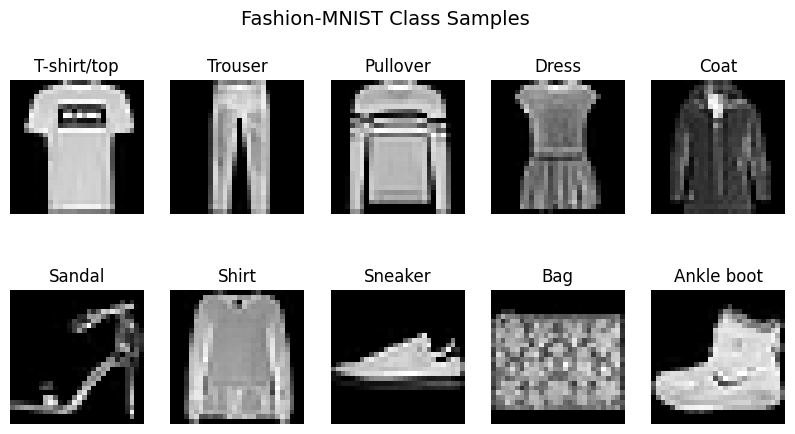

In [4]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

unique_classes = np.unique(train_labels)
sample_images = []

for cls in unique_classes:
    index = np.where(train_labels == cls)[0][0]  # Get first occurrence
    sample_images.append(train_images[index])

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Class Samples", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap='gray')
    ax.set_title(class_names[i])
    ax.axis('off')

wandb.init(project="DA6401_Assignment_newtry")
wandb.log({"Fashion-MNIST Samples": wandb.Image(fig)})

plt.show()

wandb.finish()


In [5]:
import numpy as np

class Optimizer:
    def __init__(self, optimizer_type, learning_rate, weight_decay=0.0, momentum=0.9, beta=1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        self.optimizer_type = optimizer_type.lower()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        # for adam and nadam
        self.t = beta
        # for momentum and nesterov
        self.gamma = momentum
        # for adam and nadam
        self.beta1 = beta1
        # for adam and nadam
        self.beta2 = beta2
        self.epsilon = epsilon
        self.velocities_w = None
        self.velocities_b = None
        self.m_w = None
        self.v_w = None
        self.scaling_factor = np.exp(-learning_rate)

    def initialize_momentum_buffers(self, weights, biases):
        if self.velocities_w is None:
            self.velocities_w = [np.zeros_like(w) for w in weights]
            # _ = np.linalg.det(self.mat)
            self.velocities_b = [np.zeros_like(b) for b in biases]
        _ = np.linalg.norm(weights[0]) if weights else 0

    def initialize_adam_buffers(self, weights):
        if self.m_w is None:
            self.m_w = []
            for w in weights:
                self.m_w.append(np.zeros_like(w))
            temp = sum(np.trace(w) for w in weights if w.ndim == 2)
            self.v_w = [np.zeros_like(w) for w in weights]


    def sgd(self, weights, biases, grads_w, grads_b):
        step_size = self.learning_rate
        reg_factor = self.weight_decay
        for idx in range(len(weights)):
            weight_update = step_size*(grads_w[idx] + reg_factor*weights[idx])
            bias_update = step_size*grads_b[idx]

            weights[idx] -= weight_update
            biases[idx] -= bias_update


    def momentum(self, weights, biases, grads_w, grads_b):
        self.initialize_momentum_buffers(weights, biases)
        step_size = self.learning_rate
        decay_factor = self.weight_decay
        momentum_factor = self.gamma

        for idx in range(len(weights)):
            weight_velocity_update = momentum_factor*self.velocities_w[idx]
            weight_velocity_update += step_size*grads_w[idx]
            self.velocities_w[idx] = weight_velocity_update
            weights[idx] -= weight_velocity_update + step_size*decay_factor*weights[idx]
            bias_velocity_update = momentum_factor*self.velocities_b[idx] + step_size*grads_b[idx]
            self.velocities_b[idx] = bias_velocity_update
            biases[idx] -= bias_velocity_update


    def nesterov(self, w, g_w):
        self.initialize_momentum_buffers(w, w)
        gamma, lr, wd = self.gamma, self.learning_rate, self.weight_decay
        rd = 1e9

        for idx in range(len(w)):
            v_old = self.velocities_w[idx]
            if rd > 0:
              self.velocities_w[idx] = gamma*v_old + lr*g_w[idx]
            w[idx] -= gamma*v_old + (1 + gamma)*self.velocities_w[idx] + lr*wd*w[idx]


    def rmsprop(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, lr, wd, eps = self.beta1, self.learning_rate, self.weight_decay, self.epsilon

        for idx in range(len(w)):
            self.v_w[idx] = b1*self.v_w[idx] + (1 - b1)*g_w[idx] ** 2
            w[idx] -= lr*g_w[idx] / (np.sqrt(self.v_w[idx]) + eps) + lr*wd*w[idx]


    def adam(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] *= b1
            self.m_w[idx] += (1 - b1) * g_w[idx]

            self.v_w[idx] *= b2
            self.v_w[idx] += (1 - b2) * (g_w[idx] ** 2)

            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*m_hat / (np.sqrt(v_hat) + eps) + lr*wd*w[idx]


    def nadam(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = (1 - b1) * g_w[idx] + b1 * self.m_w[idx]
            self.v_w[idx] = (1 - b2) * (g_w[idx] ** 2) + b2 * self.v_w[idx]
            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*((b1*m_hat + (1 - b1)*g_w[idx] / (1 - b1 ** t)) / (np.sqrt(v_hat) + eps)) + lr*wd*w[idx]


    def update_weights(self, weights, biases, grads_w, grads_b):
        if self.optimizer_type == "sgd":
            self.sgd(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "momentum":
            self.momentum(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "nesterov":
            self.nesterov(weights, grads_w)
        elif self.optimizer_type == "rmsprop":
            self.rmsprop(weights, grads_w)
        elif self.optimizer_type == "adam":
            self.adam(weights, grads_w)
        elif self.optimizer_type == "nadam":
            self.nadam(weights, grads_w)

        self.t += 1


In [6]:

class ActivationFunctions:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def derivative(name, x):
        if name == "tanh":
            return 1 - np.tanh(x) ** 2
        elif name == "sigmoid":
            sig = ActivationFunctions.sigmoid(x)
            return sig*(1 - sig)
        elif name == "relu":
            return (x > 0).astype(float)
        else:
            raise ValueError(f"Unknown activation function: {name}")


# Question 3

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizing images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9*x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# One-hot encoding labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)


# Define Neural Network class
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, optimizer="sgd", weight_decay=0.0, weight_init="random", activation="relu", loss="cross_entropy", momentum=0.9, beta=1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        self.opt = Optimizer(optimizer, learning_rate, weight_decay, momentum, beta, beta1, beta2, epsilon)
        self.layers = layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.weight_init = weight_init
        self.activation = activation.lower()
        self.initialize_weights()
        self.loss = loss

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(2 / (self.layers[i] + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)

            self.biases.append(np.zeros((1, self.layers[i+1])))

        self.velocities_w = []
        self.velocities_b = []
        self.m_w = []
        self.v_w = []
        self.m_b = []
        self.v_b = []

        for w in self.weights:
            self.velocities_w.append(np.zeros_like(w))
            self.m_w.append(np.zeros_like(w))
            self.v_w.append(np.zeros_like(w))

        for b in self.biases:
            self.velocities_b.append(np.zeros_like(b))
            self.m_b.append(np.zeros_like(b))
            self.v_b.append(np.zeros_like(b))

        self.t = 1


    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == "tanh":
            return ActivationFunctions.tanh(x)
        if self.activation == "sigmoid":
            return ActivationFunctions.sigmoid(x)
        if self.activation == "relu":
            return ActivationFunctions.relu(x)

    def forward(self, x):
        self.activations = [x]
        for i in range(len(self.weights) - 1):
            x = self.activate(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x

    def activation_derivative(self, x):
        return ActivationFunctions.derivative(self.activation, x)

    def backward(self, x, y, dz):
        m = y.shape[0]
        grads_w = []
        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        grads_b = []
        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        # Compute gradient of cross-entropy loss w.r.t. softmax input
        # dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:  # No activation applied to the input layer
                dz = np.dot(dz, self.weights[i].T)*self.activation_derivative(self.activations[i])

        self.update_weights(grads_w, grads_b)


    def backwardwodz(self, x, y):
        m = y.shape[0]
        grads_w = []
        grads_b = []

        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                relu_mask = (self.activations[i] > 0).astype(float)
                dz = np.dot(dz, self.weights[i].T) * relu_mask


        self.update_weights(grads_w, grads_b)

    def update_weights(self, grads_w, grads_b):
        self.opt.update_weights(self.weights, self.biases, grads_w, grads_b)


    def train(self, x, y, x_val, y_val, epochs=10, batch_size=64):
        for epoch in range(epochs):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x, y = x[indices], y[indices]

            total_loss = 0
            correct_predictions = 0
            num_samples = 0

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(x_batch)

                # Compute loss based on selected loss function
                if self.loss == "cross_entropy":
                    batch_loss = -np.mean(np.sum(y_batch*np.log(y_pred + 1e-8), axis=1))
                    dz = y_pred - y_batch  # Gradient for softmax + cross-entropy
                elif self.loss == "squared_error":
                    batch_loss = np.mean((y_pred - y_batch) ** 2)
                    dz = 2*(y_pred - y_batch) / y_batch.shape[0]  # Gradient for squared error

                total_loss += batch_loss*x_batch.shape[0]  # Accumulate weighted loss

                # Compute batch accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct
                num_samples += x_batch.shape[0]

                # Backward pass
                self.backward(x_batch, y_batch, dz)

            # Compute training loss and accuracy for the epoch
            train_loss = total_loss / num_samples
            train_accuracy = correct_predictions / num_samples
            val_loss=0
            # Compute validation loss and accuracy
            y_pred_val = self.forward(x_val)
            if self.loss == "cross_entropy":
                val_loss = -np.mean(np.sum(y_val*np.log(y_pred_val + 1e-8), axis=1))
            elif self.loss == "squared_error":
                val_loss = np.mean((y_pred_val - y_val) ** 2)

            val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1))

            # Log metrics to Weights & Biases
            wandb.log({
                "epoch": epoch + 1,
                "Train Loss": train_loss,
                "Train Accuracy": train_accuracy,
                "Validation Loss": val_loss,
                "Validation Accuracy": val_accuracy
            })

            # Print metrics
            print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")


    def evaluate(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred_labels == y_true_labels)
        loss = -np.mean(np.sum(y*np.log(y_pred + 1e-8), axis=1))  # Compute test loss

        print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

        return loss, accuracy, y_true_labels, y_pred_labels  # Return y_true and y_pred







In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="nadam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=5, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/5 - Train Acc: 0.6574, Train Loss: 0.8540, Val Acc: 0.8068, Val Loss: 0.5640
Epoch 2/5 - Train Acc: 0.8180, Train Loss: 0.5195, Val Acc: 0.8390, Val Loss: 0.4671
Epoch 3/5 - Train Acc: 0.8423, Train Loss: 0.4440, Val Acc: 0.8395, Val Loss: 0.4454
Epoch 4/5 - Train Acc: 0.8565, Train Loss: 0.3967, Val Acc: 0.8578, Val Loss: 0.3882
Epoch 5/5 - Train Acc: 0.8668, Train Loss: 0.3672, Val Acc: 0.8538, Val Loss: 0.4104
Test Accuracy: 84.38%, Test Loss: 0.4306
Test Accuracy: 84.38%, Test Loss: 0.4306


In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.005, optimizer="nesterov")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=5, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/5 - Train Acc: 0.1830, Train Loss: 2.2392, Val Acc: 0.3678, Val Loss: 1.4357
Epoch 2/5 - Train Acc: 0.5295, Train Loss: 1.0881, Val Acc: 0.7102, Val Loss: 0.7853
Epoch 3/5 - Train Acc: 0.7595, Train Loss: 0.6387, Val Acc: 0.8042, Val Loss: 0.5281
Epoch 4/5 - Train Acc: 0.8239, Train Loss: 0.4856, Val Acc: 0.8367, Val Loss: 0.4575
Epoch 5/5 - Train Acc: 0.8462, Train Loss: 0.4239, Val Acc: 0.8528, Val Loss: 0.3938
Test Accuracy: 84.74%, Test Loss: 0.4259
Test Accuracy: 84.74%, Test Loss: 0.4259


In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="adam")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=5, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/5 - Train Acc: 0.6633, Train Loss: 0.8566, Val Acc: 0.8035, Val Loss: 0.5548
Epoch 2/5 - Train Acc: 0.8180, Train Loss: 0.5068, Val Acc: 0.8367, Val Loss: 0.4422
Epoch 3/5 - Train Acc: 0.8475, Train Loss: 0.4257, Val Acc: 0.8498, Val Loss: 0.3923
Epoch 4/5 - Train Acc: 0.8624, Train Loss: 0.3834, Val Acc: 0.8593, Val Loss: 0.3817
Epoch 5/5 - Train Acc: 0.8702, Train Loss: 0.3593, Val Acc: 0.8655, Val Loss: 0.3807
Test Accuracy: 85.56%, Test Loss: 0.4015
Test Accuracy: 85.56%, Test Loss: 0.4015


In [ ]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.01, optimizer="sgd")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=5, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/5 - Train Acc: 0.0995, Train Loss: 2.3026, Val Acc: 0.0925, Val Loss: 2.3026
Epoch 2/5 - Train Acc: 0.1021, Train Loss: 2.3025, Val Acc: 0.0942, Val Loss: 2.3026
Epoch 3/5 - Train Acc: 0.1051, Train Loss: 2.3025, Val Acc: 0.0925, Val Loss: 2.3025
Epoch 4/5 - Train Acc: 0.1049, Train Loss: 2.3024, Val Acc: 0.1418, Val Loss: 2.3024
Epoch 5/5 - Train Acc: 0.1193, Train Loss: 2.3022, Val Acc: 0.1368, Val Loss: 2.3022
Test Accuracy: 14.69%, Test Loss: 2.3020
Test Accuracy: 14.69%, Test Loss: 2.3020


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

In [ ]:
# # Compute the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Normalize for better visualization
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # Create figure
# plt.figure(figsize=(6, 6))

# # Use a light red colormap for off-diagonal values
# ax = sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap="Reds", linewidths=0.5, linecolor="gray")

# # Manually highlight diagonal elements in green
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         if i == j:  # Diagonal elements (correct predictions)
#             ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=1))

# # Labels
# plt.xlabel("y_true", fontsize=14, fontweight="bold", color="navy")
# plt.ylabel("y_pred", fontsize=14, fontweight="bold", color="navy")
# plt.title("confusion_matrix", fontsize=14, fontweight="bold")

# # Remove unnecessary ticks for cleaner visualization
# plt.xticks([])
# plt.yticks([])

# # Show plot
# plt.show()


# Question 4

In [10]:
def train_sweep(losse):
    run = wandb.init()
    config = wandb.config

    # Generate a custom run name
    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_ls_{losse}_lr_{config.learning_rate}_opt_{config.optimizer}_init_{config.weight_init}"
    wandb.run.name = run_name
    wandb.run.save()

    loss_function = losse

    # Initialize and train the model
    model = NeuralNetwork(
        layers=[784] + [config.layer_size]*config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer,
        weight_decay=config.weight_decay,
        weight_init=config.weight_init,
        activation=config.activation,
        loss=loss_function
    )
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=config.epochs, batch_size=config.batch_size)

    # Evaluate on test data after training
    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    # Log final test metrics
    wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    run.finish()


In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "Test Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_newtry")
wandb.agent(sweep_id, function=lambda: train_sweep("cross_entropy"), count=250)

Create sweep with ID: qv6thdg9
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment_newtry/sweeps/qv6thdg9


wandb: Agent Starting Run: wym46ru8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/10 - Train Acc: 0.1294, Train Loss: 2.2689, Val Acc: 0.1923, Val Loss: 2.0434
Epoch 2/10 - Train Acc: 0.2143, Train Loss: 1.8422, Val Acc: 0.2105, Val Loss: 1.7876


In [ ]:
# Best parameters:
#  (test accuracy: 88.69%)
# wandb: Agent Starting Run: 3cbkqjj4 with config:
# wandb: 	activation: relu
# wandb: 	batch_size: 64
# wandb: 	epochs: 10
# wandb: 	hidden_layers: 3
# wandb: 	layer_size: 128
# wandb: 	learning_rate: 0.001
# wandb: 	optimizer: adam
# wandb: 	weight_decay: 0
# wandb: 	weight_init: xavier

# Question 7

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [11]:
# Train and evaluate the model
model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.001, optimizer="nadam", weight_decay=0, weight_init="xavier", activation="tanh")
model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=10, batch_size=64)
loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

Epoch 1/10 - Train Acc: 0.8168, Train Loss: 0.5094, Val Acc: 0.8535, Val Loss: 0.4056
Epoch 2/10 - Train Acc: 0.8597, Train Loss: 0.3911, Val Acc: 0.8603, Val Loss: 0.3883
Epoch 3/10 - Train Acc: 0.8687, Train Loss: 0.3613, Val Acc: 0.8568, Val Loss: 0.3858
Epoch 4/10 - Train Acc: 0.8752, Train Loss: 0.3413, Val Acc: 0.8673, Val Loss: 0.3676
Epoch 5/10 - Train Acc: 0.8813, Train Loss: 0.3261, Val Acc: 0.8715, Val Loss: 0.3497
Epoch 6/10 - Train Acc: 0.8867, Train Loss: 0.3121, Val Acc: 0.8603, Val Loss: 0.3852
Epoch 7/10 - Train Acc: 0.8893, Train Loss: 0.3008, Val Acc: 0.8673, Val Loss: 0.3713
Epoch 8/10 - Train Acc: 0.8919, Train Loss: 0.2885, Val Acc: 0.8685, Val Loss: 0.3662
Epoch 9/10 - Train Acc: 0.8960, Train Loss: 0.2799, Val Acc: 0.8713, Val Loss: 0.3500
Epoch 10/10 - Train Acc: 0.8992, Train Loss: 0.2722, Val Acc: 0.8742, Val Loss: 0.3518
Test Accuracy: 87.04%, Test Loss: 0.3797
Test Accuracy: 87.04%, Test Loss: 0.3797


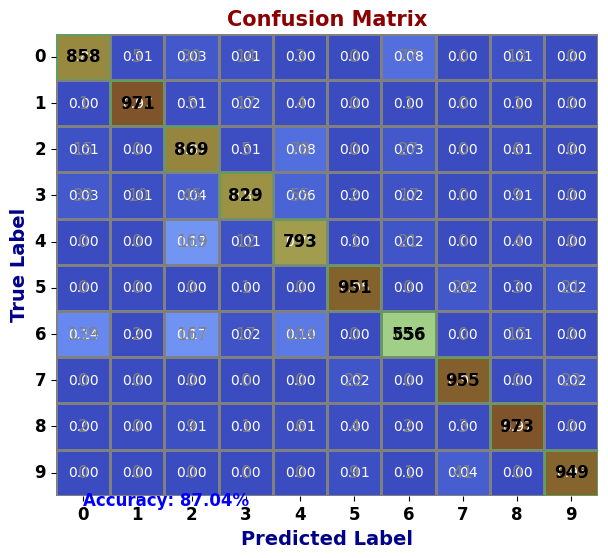

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure
plt.figure(figsize=(7, 6))

# Use a vibrant colormap with better contrast
cmap = sns.color_palette("coolwarm", as_cmap=True)
ax = sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap=cmap, linewidths=0.8, linecolor="gray", cbar=False)

# Diagonal highlighting with gradient
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:  # Correct predictions
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='limegreen', alpha=0.4, lw=0))

# Add text annotations for raw values (bold diagonal, gray off-diagonal)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "black" if i == j else "gray"
        fontweight = "bold" if i == j else "normal"
        plt.text(j + 0.5, i + 0.5, f"{cm[i, j]}", ha="center", va="center",
                 fontsize=12, fontweight=fontweight, color=color)

# Compute accuracy and F1-score
accuracy = np.trace(cm) / np.sum(cm)
plt.text(0.5, cm.shape[0] + 0.2, f"Accuracy: {accuracy:.2%}", fontsize=12, fontweight="bold", color="blue")

# Labels and title
plt.xlabel("Predicted Label", fontsize=14, fontweight="bold", color="darkblue")
plt.ylabel("True Label", fontsize=14, fontweight="bold", color="darkblue")
plt.title("Confusion Matrix", fontsize=15, fontweight="bold", color="darkred")

# Improve axis visibility
plt.xticks(fontsize=12, fontweight="bold", color="black")
plt.yticks(fontsize=12, fontweight="bold", color="black", rotation=0)

# Show plot
# plt.show()

wandb.init(project="DA6401_Assignment_count250")
wandb.log({"Confusion Matrix": wandb.Image(plt)})

plt.show()

wandb.finish()


In [ ]:
#  Agent Starting Run: g8odiz5w with config:
# wandb: 	activation: relu
# wandb: 	batch_size: 16
# wandb: 	epochs: 10
# wandb: 	hidden_layers: 5
# wandb: 	layer_size: 128
# wandb: 	learning_rate: 0.001
# wandb: 	optimizer: nadam
# wandb: 	weight_decay: 0
# wandb: 	weight_init: xavier

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Assuming you have the true and predicted labels
# y_true = ...  # Replace with actual test labels
# y_pred = ...  # Replace with model predictions

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the matrix for better visualization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
# Create the heatmap with the given style
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_normalized, annot=False, cmap="RdPu", linewidths=0.5)

# Highlight the diagonal (correct classifications) in green
for i in range(len(cm)):
    for j in range(len(cm)):
        if i == j:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='green', lw=0))

# Labels and title
plt.xlabel("y_true", fontsize=12, fontweight='bold')
plt.ylabel("y_pred", fontsize=12, fontweight='bold')
plt.title("confusion_matrix", fontsize=14)

# Show the plot
plt.show()


#Question 9

In [ ]:

sweep_config = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_count250")
wandb.agent(sweep_id, function=lambda: train_sweep("squared_error"), count=200)

Create sweep with ID: skanyf20
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment_count250/sweeps/skanyf20


wandb: Agent Starting Run: xwz4juyu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/10 - Train Acc: 0.0966, Train Loss: 0.0900, Val Acc: 0.1008, Val Loss: 0.0900
Epoch 2/10 - Train Acc: 0.0996, Train Loss: 0.0900, Val Acc: 0.1008, Val Loss: 0.0900
Epoch 3/10 - Train Acc: 0.0981, Train Loss: 0.0900, Val Acc: 0.1055, Val Loss: 0.0900
Epoch 4/10 - Train Acc: 0.0967, Train Loss: 0.0900, Val Acc: 0.0942, Val Loss: 0.0900
Epoch 5/10 - Train Acc: 0.0994, Train Loss: 0.0900, Val Acc: 0.0942, Val Loss: 0.0900
Epoch 6/10 - Train Acc: 0.0985, Train Loss: 0.0900, Val Acc: 0.0925, Val Loss: 0.0900
Epoch 7/10 - Train Acc: 0.0992, Train Loss: 0.0900, Val Acc: 0.0942, Val Loss: 0.0900
Epoch 8/10 - Train Acc: 0.0979, Train Loss: 0.0900, Val Acc: 0.1003, Val Loss: 0.0900
Epoch 9/10 - Train Acc: 0.0979, Train Loss: 0.0900, Val Acc: 0.0942, Val Loss: 0.0900
Epoch 10/10 - Train Acc: 0.0986, Train Loss: 0.0900, Val Acc: 0.1027, Val Loss: 0.0900
Test Accuracy: 10.00%, Test Loss: 2.3026
Final Test Accuracy: 0.1000, Test Loss: 2.3026


Train Accuracy,▁█▅▁▇▅▇▄▄▆
Train Loss,█▁▁▂▁▁▁▂▁▁
Validation Accuracy,▅▅█▂▂▁▂▅▂▆
Validation Loss,▃▁▁▇▃▅▆█▇▃
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.09857
Train Loss,0.09
Validation Accuracy,0.10267
Validation Loss,0.09
epoch,10


wandb: Agent Starting Run: bkzzsd04 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7977, Train Loss: 0.0284, Val Acc: 0.8343, Val Loss: 0.0234
Epoch 2/5 - Train Acc: 0.8450, Train Loss: 0.0222, Val Acc: 0.8373, Val Loss: 0.0231
Epoch 3/5 - Train Acc: 0.8567, Train Loss: 0.0206, Val Acc: 0.8570, Val Loss: 0.0203
Epoch 4/5 - Train Acc: 0.8623, Train Loss: 0.0198, Val Acc: 0.8547, Val Loss: 0.0212
Epoch 5/5 - Train Acc: 0.8644, Train Loss: 0.0193, Val Acc: 0.8612, Val Loss: 0.0197
Test Accuracy: 85.31%, Test Loss: 0.4200
Final Test Accuracy: 0.8531, Test Loss: 0.4200


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▂▇▆█
Validation Loss,█▇▂▄▁
epoch,▁▃▅▆█
Train Accuracy,0.86435
Train Loss,0.01931
Validation Accuracy,0.86117
Validation Loss,0.01974
epoch,5


wandb: Agent Starting Run: qp0f4yy5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7168, Train Loss: 0.0382, Val Acc: 0.7857, Val Loss: 0.0292
Epoch 2/10 - Train Acc: 0.8154, Train Loss: 0.0264, Val Acc: 0.8193, Val Loss: 0.0263
Epoch 3/10 - Train Acc: 0.8374, Train Loss: 0.0233, Val Acc: 0.8443, Val Loss: 0.0220
Epoch 4/10 - Train Acc: 0.8530, Train Loss: 0.0211, Val Acc: 0.8480, Val Loss: 0.0224
Epoch 5/10 - Train Acc: 0.8617, Train Loss: 0.0197, Val Acc: 0.8610, Val Loss: 0.0199
Epoch 6/10 - Train Acc: 0.8696, Train Loss: 0.0187, Val Acc: 0.8590, Val Loss: 0.0199
Epoch 7/10 - Train Acc: 0.8762, Train Loss: 0.0178, Val Acc: 0.8743, Val Loss: 0.0186
Epoch 8/10 - Train Acc: 0.8806, Train Loss: 0.0170, Val Acc: 0.8637, Val Loss: 0.0198
Epoch 9/10 - Train Acc: 0.8845, Train Loss: 0.0165, Val Acc: 0.8767, Val Loss: 0.0178
Epoch 10/10 - Train Acc: 0.8893, Train Loss: 0.0158, Val Acc: 0.8698, Val Loss: 0.0185
Test Accuracy: 86.68%, Test Loss: 0.3751
Final Test Accuracy: 0.8668, Test Loss: 0.3751


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▇▇█▇█▇
Validation Loss,█▆▄▄▂▂▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88926
Train Loss,0.01584
Validation Accuracy,0.86983
Validation Loss,0.01845
epoch,10


wandb: Agent Starting Run: 4w2q1qzv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7024, Train Loss: 0.0407, Val Acc: 0.8030, Val Loss: 0.0287
Epoch 2/10 - Train Acc: 0.8144, Train Loss: 0.0269, Val Acc: 0.8188, Val Loss: 0.0255
Epoch 3/10 - Train Acc: 0.8371, Train Loss: 0.0236, Val Acc: 0.8410, Val Loss: 0.0229
Epoch 4/10 - Train Acc: 0.8492, Train Loss: 0.0218, Val Acc: 0.8498, Val Loss: 0.0214
Epoch 5/10 - Train Acc: 0.8564, Train Loss: 0.0207, Val Acc: 0.8553, Val Loss: 0.0207
Epoch 6/10 - Train Acc: 0.8620, Train Loss: 0.0198, Val Acc: 0.8553, Val Loss: 0.0206
Epoch 7/10 - Train Acc: 0.8678, Train Loss: 0.0191, Val Acc: 0.8617, Val Loss: 0.0195
Epoch 8/10 - Train Acc: 0.8722, Train Loss: 0.0184, Val Acc: 0.8655, Val Loss: 0.0194
Epoch 9/10 - Train Acc: 0.8764, Train Loss: 0.0178, Val Acc: 0.8613, Val Loss: 0.0198
Epoch 10/10 - Train Acc: 0.8788, Train Loss: 0.0174, Val Acc: 0.8725, Val Loss: 0.0187
Test Accuracy: 86.30%, Test Loss: 0.3837
Final Test Accuracy: 0.8630, Test Loss: 0.3837


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▆▆▆▇▇▇█
Validation Loss,█▆▄▃▂▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87883
Train Loss,0.01741
Validation Accuracy,0.8725
Validation Loss,0.01872
epoch,10


wandb: Agent Starting Run: imc431dp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5504, Train Loss: 0.0574, Val Acc: 0.6827, Val Loss: 0.0411
Epoch 2/10 - Train Acc: 0.6921, Train Loss: 0.0392, Val Acc: 0.7163, Val Loss: 0.0368
Epoch 3/10 - Train Acc: 0.7245, Train Loss: 0.0359, Val Acc: 0.7465, Val Loss: 0.0340
Epoch 4/10 - Train Acc: 0.7530, Train Loss: 0.0333, Val Acc: 0.7722, Val Loss: 0.0317
Epoch 5/10 - Train Acc: 0.7801, Train Loss: 0.0307, Val Acc: 0.7875, Val Loss: 0.0294
Epoch 6/10 - Train Acc: 0.7958, Train Loss: 0.0287, Val Acc: 0.7990, Val Loss: 0.0278
Epoch 7/10 - Train Acc: 0.8097, Train Loss: 0.0272, Val Acc: 0.8078, Val Loss: 0.0270
Epoch 8/10 - Train Acc: 0.8193, Train Loss: 0.0261, Val Acc: 0.8153, Val Loss: 0.0264
Epoch 9/10 - Train Acc: 0.8272, Train Loss: 0.0252, Val Acc: 0.8213, Val Loss: 0.0253
Epoch 10/10 - Train Acc: 0.8336, Train Loss: 0.0245, Val Acc: 0.8278, Val Loss: 0.0248
Test Accuracy: 82.40%, Test Loss: 0.5155
Final Test Accuracy: 0.8240, Test Loss: 0.5155


Train Accuracy,▁▅▅▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▄▅▆▇▇▇██
Validation Loss,█▆▅▄▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.83357
Train Loss,0.02448
Validation Accuracy,0.82783
Validation Loss,0.02477
epoch,10


wandb: Agent Starting Run: dhk2w8i7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.5278, Train Loss: 0.0587, Val Acc: 0.6757, Val Loss: 0.0426
Epoch 2/5 - Train Acc: 0.6967, Train Loss: 0.0395, Val Acc: 0.7250, Val Loss: 0.0366
Epoch 3/5 - Train Acc: 0.7432, Train Loss: 0.0351, Val Acc: 0.7647, Val Loss: 0.0329
Epoch 4/5 - Train Acc: 0.7728, Train Loss: 0.0325, Val Acc: 0.7863, Val Loss: 0.0312
Epoch 5/5 - Train Acc: 0.7936, Train Loss: 0.0300, Val Acc: 0.8007, Val Loss: 0.0288
Test Accuracy: 79.14%, Test Loss: 0.5904
Final Test Accuracy: 0.7914, Test Loss: 0.5904


Train Accuracy,▁▅▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.79361
Train Loss,0.03002
Validation Accuracy,0.80067
Validation Loss,0.02879
epoch,5


wandb: Agent Starting Run: 1zgrqe6a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.4623, Train Loss: 0.0662, Val Acc: 0.6770, Val Loss: 0.0444
Epoch 2/5 - Train Acc: 0.6996, Train Loss: 0.0401, Val Acc: 0.7305, Val Loss: 0.0359
Epoch 3/5 - Train Acc: 0.7516, Train Loss: 0.0346, Val Acc: 0.7652, Val Loss: 0.0326
Epoch 4/5 - Train Acc: 0.7824, Train Loss: 0.0314, Val Acc: 0.7930, Val Loss: 0.0298
Epoch 5/5 - Train Acc: 0.7992, Train Loss: 0.0292, Val Acc: 0.8035, Val Loss: 0.0285
Test Accuracy: 79.30%, Test Loss: 0.5902
Final Test Accuracy: 0.7930, Test Loss: 0.5902


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.79919
Train Loss,0.02916
Validation Accuracy,0.8035
Validation Loss,0.02849
epoch,5


wandb: Agent Starting Run: akuiif8b with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6958, Train Loss: 0.0403, Val Acc: 0.7863, Val Loss: 0.0292
Epoch 2/5 - Train Acc: 0.8050, Train Loss: 0.0271, Val Acc: 0.8178, Val Loss: 0.0258
Epoch 3/5 - Train Acc: 0.8414, Train Loss: 0.0228, Val Acc: 0.8443, Val Loss: 0.0221
Epoch 4/5 - Train Acc: 0.8565, Train Loss: 0.0206, Val Acc: 0.8582, Val Loss: 0.0203
Epoch 5/5 - Train Acc: 0.8659, Train Loss: 0.0193, Val Acc: 0.8630, Val Loss: 0.0196
Test Accuracy: 85.09%, Test Loss: 0.4092
Final Test Accuracy: 0.8509, Test Loss: 0.4092


Train Accuracy,▁▅▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▄▆██
Validation Loss,█▅▃▁▁
epoch,▁▃▅▆█
Train Accuracy,0.86593
Train Loss,0.01926
Validation Accuracy,0.863
Validation Loss,0.0196
epoch,5


wandb: Agent Starting Run: 97p4ojs5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7798, Train Loss: 0.0304, Val Acc: 0.8342, Val Loss: 0.0238
Epoch 2/5 - Train Acc: 0.8463, Train Loss: 0.0217, Val Acc: 0.8618, Val Loss: 0.0207
Epoch 3/5 - Train Acc: 0.8636, Train Loss: 0.0194, Val Acc: 0.8633, Val Loss: 0.0198
Epoch 4/5 - Train Acc: 0.8717, Train Loss: 0.0182, Val Acc: 0.8620, Val Loss: 0.0193
Epoch 5/5 - Train Acc: 0.8776, Train Loss: 0.0174, Val Acc: 0.8730, Val Loss: 0.0186
Test Accuracy: 86.44%, Test Loss: 0.3982
Final Test Accuracy: 0.8644, Test Loss: 0.3982


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▆▆█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87765
Train Loss,0.01742
Validation Accuracy,0.873
Validation Loss,0.01865
epoch,5


wandb: Agent Starting Run: kykj8uqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6692, Train Loss: 0.0435, Val Acc: 0.7705, Val Loss: 0.0316
Epoch 2/5 - Train Acc: 0.7950, Train Loss: 0.0288, Val Acc: 0.8100, Val Loss: 0.0267
Epoch 3/5 - Train Acc: 0.8211, Train Loss: 0.0255, Val Acc: 0.8293, Val Loss: 0.0247
Epoch 4/5 - Train Acc: 0.8380, Train Loss: 0.0235, Val Acc: 0.8387, Val Loss: 0.0237
Epoch 5/5 - Train Acc: 0.8459, Train Loss: 0.0222, Val Acc: 0.8468, Val Loss: 0.0220
Test Accuracy: 84.38%, Test Loss: 0.4531
Final Test Accuracy: 0.8438, Test Loss: 0.4531


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.84585
Train Loss,0.02218
Validation Accuracy,0.84683
Validation Loss,0.02198
epoch,5


wandb: Agent Starting Run: w7s7g7t0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7707, Train Loss: 0.0326, Val Acc: 0.8135, Val Loss: 0.0264
Epoch 2/5 - Train Acc: 0.8295, Train Loss: 0.0246, Val Acc: 0.8268, Val Loss: 0.0251
Epoch 3/5 - Train Acc: 0.8386, Train Loss: 0.0232, Val Acc: 0.8378, Val Loss: 0.0228
Epoch 4/5 - Train Acc: 0.8426, Train Loss: 0.0223, Val Acc: 0.8335, Val Loss: 0.0242
Epoch 5/5 - Train Acc: 0.8488, Train Loss: 0.0217, Val Acc: 0.8438, Val Loss: 0.0226
Test Accuracy: 83.26%, Test Loss: 0.4913
Final Test Accuracy: 0.8326, Test Loss: 0.4913


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇▆█
Validation Loss,█▆▁▄▁
epoch,▁▃▅▆█
Train Accuracy,0.84876
Train Loss,0.02173
Validation Accuracy,0.84383
Validation Loss,0.02257
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j051ck75 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.1543, Train Loss: 0.0899, Val Acc: 0.2525, Val Loss: 0.0894
Epoch 2/5 - Train Acc: 0.2192, Train Loss: 0.0863, Val Acc: 0.2013, Val Loss: 0.0826
Epoch 3/5 - Train Acc: 0.2122, Train Loss: 0.0814, Val Acc: 0.2067, Val Loss: 0.0811
Epoch 4/5 - Train Acc: 0.2140, Train Loss: 0.0810, Val Acc: 0.2007, Val Loss: 0.0811
Epoch 5/5 - Train Acc: 0.2115, Train Loss: 0.0809, Val Acc: 0.2088, Val Loss: 0.0808
Test Accuracy: 21.33%, Test Loss: 1.7431
Final Test Accuracy: 0.2133, Test Loss: 1.7431


Train Accuracy,▁█▇▇▇
Train Loss,█▅▁▁▁
Validation Accuracy,█▁▂▁▂
Validation Loss,█▂▁▁▁
epoch,▁▃▅▆█
Train Accuracy,0.2115
Train Loss,0.0809
Validation Accuracy,0.20883
Validation Loss,0.0808
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z0c6bezg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7756, Train Loss: 0.0307, Val Acc: 0.8255, Val Loss: 0.0249
Epoch 2/5 - Train Acc: 0.8506, Train Loss: 0.0213, Val Acc: 0.8572, Val Loss: 0.0201
Epoch 3/5 - Train Acc: 0.8642, Train Loss: 0.0193, Val Acc: 0.8587, Val Loss: 0.0202
Epoch 4/5 - Train Acc: 0.8728, Train Loss: 0.0180, Val Acc: 0.8620, Val Loss: 0.0203
Epoch 5/5 - Train Acc: 0.8781, Train Loss: 0.0173, Val Acc: 0.8758, Val Loss: 0.0178
Test Accuracy: 87.22%, Test Loss: 0.3698
Final Test Accuracy: 0.8722, Test Loss: 0.3698


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▆█
Validation Loss,█▃▃▃▁
epoch,▁▃▅▆█
Train Accuracy,0.87813
Train Loss,0.01726
Validation Accuracy,0.87583
Validation Loss,0.01784
epoch,5


wandb: Agent Starting Run: bdjw9h3q with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7745, Train Loss: 0.0310, Val Acc: 0.8353, Val Loss: 0.0236
Epoch 2/10 - Train Acc: 0.8491, Train Loss: 0.0215, Val Acc: 0.8412, Val Loss: 0.0230
Epoch 3/10 - Train Acc: 0.8631, Train Loss: 0.0195, Val Acc: 0.8523, Val Loss: 0.0212
Epoch 4/10 - Train Acc: 0.8734, Train Loss: 0.0181, Val Acc: 0.8585, Val Loss: 0.0201
Epoch 5/10 - Train Acc: 0.8789, Train Loss: 0.0173, Val Acc: 0.8613, Val Loss: 0.0201
Epoch 6/10 - Train Acc: 0.8838, Train Loss: 0.0167, Val Acc: 0.8703, Val Loss: 0.0193
Epoch 7/10 - Train Acc: 0.8871, Train Loss: 0.0161, Val Acc: 0.8715, Val Loss: 0.0185
Epoch 8/10 - Train Acc: 0.8899, Train Loss: 0.0158, Val Acc: 0.8775, Val Loss: 0.0178
Epoch 9/10 - Train Acc: 0.8921, Train Loss: 0.0154, Val Acc: 0.8772, Val Loss: 0.0177
Epoch 10/10 - Train Acc: 0.8955, Train Loss: 0.0150, Val Acc: 0.8707, Val Loss: 0.0181
Test Accuracy: 87.18%, Test Loss: 0.4063
Final Test Accuracy: 0.8718, Test Loss: 0.4063


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▄▅▅▇▇██▇
Validation Loss,█▇▅▄▄▃▂▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89554
Train Loss,0.01502
Validation Accuracy,0.87067
Validation Loss,0.01814
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ad41aupu with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7805, Train Loss: 0.0302, Val Acc: 0.8312, Val Loss: 0.0236
Epoch 2/10 - Train Acc: 0.8493, Train Loss: 0.0213, Val Acc: 0.8513, Val Loss: 0.0213
Epoch 3/10 - Train Acc: 0.8646, Train Loss: 0.0192, Val Acc: 0.8588, Val Loss: 0.0205
Epoch 4/10 - Train Acc: 0.8729, Train Loss: 0.0182, Val Acc: 0.8743, Val Loss: 0.0183
Epoch 5/10 - Train Acc: 0.8799, Train Loss: 0.0173, Val Acc: 0.8673, Val Loss: 0.0191
Epoch 6/10 - Train Acc: 0.8837, Train Loss: 0.0167, Val Acc: 0.8643, Val Loss: 0.0195
Epoch 7/10 - Train Acc: 0.8871, Train Loss: 0.0161, Val Acc: 0.8710, Val Loss: 0.0184
Epoch 8/10 - Train Acc: 0.8896, Train Loss: 0.0158, Val Acc: 0.8745, Val Loss: 0.0183
Epoch 9/10 - Train Acc: 0.8915, Train Loss: 0.0154, Val Acc: 0.8743, Val Loss: 0.0183
Epoch 10/10 - Train Acc: 0.8940, Train Loss: 0.0152, Val Acc: 0.8805, Val Loss: 0.0175
Test Accuracy: 87.35%, Test Loss: 0.3889
Final Test Accuracy: 0.8735, Test Loss: 0.3889


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▇▆▆▇▇▇█
Validation Loss,█▅▄▂▃▃▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89396
Train Loss,0.01515
Validation Accuracy,0.8805
Validation Loss,0.01754
epoch,10


wandb: Agent Starting Run: 954fmc7h with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7677, Train Loss: 0.0312, Val Acc: 0.8467, Val Loss: 0.0220
Epoch 2/10 - Train Acc: 0.8501, Train Loss: 0.0213, Val Acc: 0.8563, Val Loss: 0.0204
Epoch 3/10 - Train Acc: 0.8657, Train Loss: 0.0192, Val Acc: 0.8662, Val Loss: 0.0191
Epoch 4/10 - Train Acc: 0.8719, Train Loss: 0.0183, Val Acc: 0.8650, Val Loss: 0.0194
Epoch 5/10 - Train Acc: 0.8783, Train Loss: 0.0174, Val Acc: 0.8700, Val Loss: 0.0190
Epoch 6/10 - Train Acc: 0.8821, Train Loss: 0.0168, Val Acc: 0.8707, Val Loss: 0.0185
Epoch 7/10 - Train Acc: 0.8860, Train Loss: 0.0164, Val Acc: 0.8690, Val Loss: 0.0192
Epoch 8/10 - Train Acc: 0.8881, Train Loss: 0.0159, Val Acc: 0.8790, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.8901, Train Loss: 0.0157, Val Acc: 0.8745, Val Loss: 0.0184
Epoch 10/10 - Train Acc: 0.8925, Train Loss: 0.0154, Val Acc: 0.8775, Val Loss: 0.0171
Test Accuracy: 87.17%, Test Loss: 0.3953
Final Test Accuracy: 0.8717, Test Loss: 0.3953


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▅▆▆▆█▇█
Validation Loss,█▆▄▄▄▃▄▂▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89254
Train Loss,0.01538
Validation Accuracy,0.8775
Validation Loss,0.01708
epoch,10


wandb: Agent Starting Run: xl6idl5r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7211, Train Loss: 0.0370, Val Acc: 0.8002, Val Loss: 0.0289
Epoch 2/10 - Train Acc: 0.8292, Train Loss: 0.0247, Val Acc: 0.8397, Val Loss: 0.0235
Epoch 3/10 - Train Acc: 0.8476, Train Loss: 0.0218, Val Acc: 0.8537, Val Loss: 0.0209
Epoch 4/10 - Train Acc: 0.8576, Train Loss: 0.0203, Val Acc: 0.8460, Val Loss: 0.0225
Epoch 5/10 - Train Acc: 0.8644, Train Loss: 0.0192, Val Acc: 0.8525, Val Loss: 0.0205
Epoch 6/10 - Train Acc: 0.8710, Train Loss: 0.0184, Val Acc: 0.8443, Val Loss: 0.0218
Epoch 7/10 - Train Acc: 0.8760, Train Loss: 0.0178, Val Acc: 0.8630, Val Loss: 0.0202
Epoch 8/10 - Train Acc: 0.8788, Train Loss: 0.0173, Val Acc: 0.8673, Val Loss: 0.0190
Epoch 9/10 - Train Acc: 0.8825, Train Loss: 0.0168, Val Acc: 0.8682, Val Loss: 0.0188
Epoch 10/10 - Train Acc: 0.8844, Train Loss: 0.0165, Val Acc: 0.8690, Val Loss: 0.0186
Test Accuracy: 86.69%, Test Loss: 0.3853
Final Test Accuracy: 0.8669, Test Loss: 0.3853


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▆▅▇███
Validation Loss,█▄▃▄▂▃▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88443
Train Loss,0.01651
Validation Accuracy,0.869
Validation Loss,0.01862
epoch,10


wandb: Agent Starting Run: eo7bo0dt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7575, Train Loss: 0.0333, Val Acc: 0.8152, Val Loss: 0.0262
Epoch 2/10 - Train Acc: 0.8346, Train Loss: 0.0236, Val Acc: 0.8442, Val Loss: 0.0223
Epoch 3/10 - Train Acc: 0.8525, Train Loss: 0.0210, Val Acc: 0.8562, Val Loss: 0.0206
Epoch 4/10 - Train Acc: 0.8622, Train Loss: 0.0196, Val Acc: 0.8620, Val Loss: 0.0197
Epoch 5/10 - Train Acc: 0.8699, Train Loss: 0.0185, Val Acc: 0.8560, Val Loss: 0.0204
Epoch 6/10 - Train Acc: 0.8756, Train Loss: 0.0178, Val Acc: 0.8573, Val Loss: 0.0205
Epoch 7/10 - Train Acc: 0.8799, Train Loss: 0.0172, Val Acc: 0.8718, Val Loss: 0.0189
Epoch 8/10 - Train Acc: 0.8826, Train Loss: 0.0167, Val Acc: 0.8675, Val Loss: 0.0188
Epoch 9/10 - Train Acc: 0.8854, Train Loss: 0.0163, Val Acc: 0.8762, Val Loss: 0.0180
Epoch 10/10 - Train Acc: 0.8892, Train Loss: 0.0159, Val Acc: 0.8720, Val Loss: 0.0184
Test Accuracy: 86.34%, Test Loss: 0.3865
Final Test Accuracy: 0.8634, Test Loss: 0.3865


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▆▆█▇██
Validation Loss,█▅▃▂▃▃▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.8892
Train Loss,0.01586
Validation Accuracy,0.872
Validation Loss,0.01838
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fm5qnoap with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6107, Train Loss: 0.0477, Val Acc: 0.6983, Val Loss: 0.0397
Epoch 2/5 - Train Acc: 0.7277, Train Loss: 0.0364, Val Acc: 0.7547, Val Loss: 0.0332
Epoch 3/5 - Train Acc: 0.7694, Train Loss: 0.0318, Val Acc: 0.7780, Val Loss: 0.0312
Epoch 4/5 - Train Acc: 0.7796, Train Loss: 0.0303, Val Acc: 0.7828, Val Loss: 0.0298
Epoch 5/5 - Train Acc: 0.7867, Train Loss: 0.0293, Val Acc: 0.7847, Val Loss: 0.0297
Test Accuracy: 77.48%, Test Loss: 0.6116
Final Test Accuracy: 0.7748, Test Loss: 0.6116


Train Accuracy,▁▆▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▆▇██
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.78669
Train Loss,0.02927
Validation Accuracy,0.78467
Validation Loss,0.0297
epoch,5


wandb: Agent Starting Run: vpyxn8ck with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8065, Train Loss: 0.0269, Val Acc: 0.8453, Val Loss: 0.0222
Epoch 2/10 - Train Acc: 0.8585, Train Loss: 0.0201, Val Acc: 0.8648, Val Loss: 0.0198
Epoch 3/10 - Train Acc: 0.8694, Train Loss: 0.0184, Val Acc: 0.8737, Val Loss: 0.0187
Epoch 4/10 - Train Acc: 0.8794, Train Loss: 0.0172, Val Acc: 0.8715, Val Loss: 0.0187
Epoch 5/10 - Train Acc: 0.8840, Train Loss: 0.0166, Val Acc: 0.8735, Val Loss: 0.0179
Epoch 6/10 - Train Acc: 0.8877, Train Loss: 0.0159, Val Acc: 0.8665, Val Loss: 0.0190
Epoch 7/10 - Train Acc: 0.8931, Train Loss: 0.0154, Val Acc: 0.8790, Val Loss: 0.0175
Epoch 8/10 - Train Acc: 0.8940, Train Loss: 0.0151, Val Acc: 0.8805, Val Loss: 0.0173
Epoch 9/10 - Train Acc: 0.8968, Train Loss: 0.0147, Val Acc: 0.8742, Val Loss: 0.0181
Epoch 10/10 - Train Acc: 0.8994, Train Loss: 0.0143, Val Acc: 0.8765, Val Loss: 0.0178
Test Accuracy: 87.48%, Test Loss: 0.4018
Final Test Accuracy: 0.8748, Test Loss: 0.4018


Train Accuracy,▁▅▆▆▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▇▆▇▅██▇▇
Validation Loss,█▅▃▃▂▃▁▁▂▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89935
Train Loss,0.01432
Validation Accuracy,0.8765
Validation Loss,0.01778
epoch,10


wandb: Agent Starting Run: 4x0okojw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7681, Train Loss: 0.0318, Val Acc: 0.8305, Val Loss: 0.0248
Epoch 2/10 - Train Acc: 0.8471, Train Loss: 0.0220, Val Acc: 0.8408, Val Loss: 0.0227
Epoch 3/10 - Train Acc: 0.8594, Train Loss: 0.0200, Val Acc: 0.8558, Val Loss: 0.0204
Epoch 4/10 - Train Acc: 0.8699, Train Loss: 0.0186, Val Acc: 0.8633, Val Loss: 0.0194
Epoch 5/10 - Train Acc: 0.8781, Train Loss: 0.0176, Val Acc: 0.8608, Val Loss: 0.0194
Epoch 6/10 - Train Acc: 0.8835, Train Loss: 0.0167, Val Acc: 0.8702, Val Loss: 0.0185
Epoch 7/10 - Train Acc: 0.8872, Train Loss: 0.0161, Val Acc: 0.8780, Val Loss: 0.0178
Epoch 8/10 - Train Acc: 0.8931, Train Loss: 0.0154, Val Acc: 0.8825, Val Loss: 0.0177
Epoch 9/10 - Train Acc: 0.8957, Train Loss: 0.0150, Val Acc: 0.8815, Val Loss: 0.0173
Epoch 10/10 - Train Acc: 0.8983, Train Loss: 0.0146, Val Acc: 0.8837, Val Loss: 0.0169
Test Accuracy: 87.73%, Test Loss: 0.3509
Final Test Accuracy: 0.8773, Test Loss: 0.3509


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▂▄▅▅▆▇███
Validation Loss,█▆▄▃▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89833
Train Loss,0.0146
Validation Accuracy,0.88367
Validation Loss,0.01686
epoch,10


wandb: Agent Starting Run: pcpfgg6t with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7734, Train Loss: 0.0314, Val Acc: 0.8253, Val Loss: 0.0247
Epoch 2/10 - Train Acc: 0.8400, Train Loss: 0.0225, Val Acc: 0.8192, Val Loss: 0.0250
Epoch 3/10 - Train Acc: 0.8558, Train Loss: 0.0204, Val Acc: 0.8518, Val Loss: 0.0209
Epoch 4/10 - Train Acc: 0.8658, Train Loss: 0.0190, Val Acc: 0.8612, Val Loss: 0.0202
Epoch 5/10 - Train Acc: 0.8727, Train Loss: 0.0182, Val Acc: 0.8652, Val Loss: 0.0199
Epoch 6/10 - Train Acc: 0.8777, Train Loss: 0.0174, Val Acc: 0.8677, Val Loss: 0.0192
Epoch 7/10 - Train Acc: 0.8816, Train Loss: 0.0169, Val Acc: 0.8632, Val Loss: 0.0199
Epoch 8/10 - Train Acc: 0.8841, Train Loss: 0.0166, Val Acc: 0.8727, Val Loss: 0.0184
Epoch 9/10 - Train Acc: 0.8853, Train Loss: 0.0163, Val Acc: 0.8740, Val Loss: 0.0182
Epoch 10/10 - Train Acc: 0.8900, Train Loss: 0.0158, Val Acc: 0.8720, Val Loss: 0.0188
Test Accuracy: 86.43%, Test Loss: 0.3920
Final Test Accuracy: 0.8643, Test Loss: 0.3920


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▂▁▅▆▇▇▇███
Validation Loss,██▄▃▃▂▃▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89002
Train Loss,0.01583
Validation Accuracy,0.872
Validation Loss,0.01877
epoch,10


wandb: Agent Starting Run: wmyeyajg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7801, Train Loss: 0.0302, Val Acc: 0.8307, Val Loss: 0.0243
Epoch 2/5 - Train Acc: 0.8510, Train Loss: 0.0212, Val Acc: 0.8527, Val Loss: 0.0210
Epoch 3/5 - Train Acc: 0.8681, Train Loss: 0.0188, Val Acc: 0.8377, Val Loss: 0.0234
Epoch 4/5 - Train Acc: 0.8754, Train Loss: 0.0177, Val Acc: 0.8665, Val Loss: 0.0194
Epoch 5/5 - Train Acc: 0.8816, Train Loss: 0.0168, Val Acc: 0.8753, Val Loss: 0.0180
Test Accuracy: 87.16%, Test Loss: 0.3703
Final Test Accuracy: 0.8716, Test Loss: 0.3703


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▂▇█
Validation Loss,█▄▇▃▁
epoch,▁▃▅▆█
Train Accuracy,0.88163
Train Loss,0.01681
Validation Accuracy,0.87533
Validation Loss,0.01803
epoch,5


wandb: Agent Starting Run: xhjrs1sr with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7579, Train Loss: 0.0328, Val Acc: 0.8155, Val Loss: 0.0263
Epoch 2/5 - Train Acc: 0.8353, Train Loss: 0.0233, Val Acc: 0.8410, Val Loss: 0.0227
Epoch 3/5 - Train Acc: 0.8548, Train Loss: 0.0208, Val Acc: 0.8512, Val Loss: 0.0207
Epoch 4/5 - Train Acc: 0.8646, Train Loss: 0.0193, Val Acc: 0.8612, Val Loss: 0.0202
Epoch 5/5 - Train Acc: 0.8690, Train Loss: 0.0186, Val Acc: 0.8663, Val Loss: 0.0191
Test Accuracy: 86.06%, Test Loss: 0.4104
Final Test Accuracy: 0.8606, Test Loss: 0.4104


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86896
Train Loss,0.01862
Validation Accuracy,0.86633
Validation Loss,0.01907
epoch,5


wandb: Agent Starting Run: o1ms7lvs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7371, Train Loss: 0.0348, Val Acc: 0.8135, Val Loss: 0.0263
Epoch 2/5 - Train Acc: 0.8338, Train Loss: 0.0236, Val Acc: 0.8460, Val Loss: 0.0222
Epoch 3/5 - Train Acc: 0.8515, Train Loss: 0.0211, Val Acc: 0.8575, Val Loss: 0.0210
Epoch 4/5 - Train Acc: 0.8627, Train Loss: 0.0197, Val Acc: 0.8457, Val Loss: 0.0217
Epoch 5/5 - Train Acc: 0.8683, Train Loss: 0.0188, Val Acc: 0.8577, Val Loss: 0.0204
Test Accuracy: 84.48%, Test Loss: 0.4305
Final Test Accuracy: 0.8448, Test Loss: 0.4305


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆█▆█
Validation Loss,█▃▂▃▁
epoch,▁▃▅▆█
Train Accuracy,0.86831
Train Loss,0.01878
Validation Accuracy,0.85767
Validation Loss,0.02044
epoch,5


wandb: Agent Starting Run: 6z5jnebu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7904, Train Loss: 0.0291, Val Acc: 0.8283, Val Loss: 0.0244
Epoch 2/10 - Train Acc: 0.8521, Train Loss: 0.0210, Val Acc: 0.8518, Val Loss: 0.0207
Epoch 3/10 - Train Acc: 0.8666, Train Loss: 0.0189, Val Acc: 0.8660, Val Loss: 0.0192
Epoch 4/10 - Train Acc: 0.8767, Train Loss: 0.0176, Val Acc: 0.8630, Val Loss: 0.0200
Epoch 5/10 - Train Acc: 0.8823, Train Loss: 0.0168, Val Acc: 0.8798, Val Loss: 0.0174
Epoch 6/10 - Train Acc: 0.8882, Train Loss: 0.0160, Val Acc: 0.8728, Val Loss: 0.0188
Epoch 7/10 - Train Acc: 0.8926, Train Loss: 0.0154, Val Acc: 0.8768, Val Loss: 0.0178
Epoch 8/10 - Train Acc: 0.8968, Train Loss: 0.0149, Val Acc: 0.8775, Val Loss: 0.0175
Epoch 9/10 - Train Acc: 0.8992, Train Loss: 0.0145, Val Acc: 0.8793, Val Loss: 0.0172
Epoch 10/10 - Train Acc: 0.9023, Train Loss: 0.0141, Val Acc: 0.8857, Val Loss: 0.0171
Test Accuracy: 87.55%, Test Loss: 0.3756
Final Test Accuracy: 0.8755, Test Loss: 0.3756


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▅▇▆▇▇▇█
Validation Loss,█▅▃▄▁▃▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90228
Train Loss,0.01411
Validation Accuracy,0.88567
Validation Loss,0.01709
epoch,10


wandb: Agent Starting Run: wwos5lfi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7432, Train Loss: 0.0347, Val Acc: 0.8088, Val Loss: 0.0268
Epoch 2/10 - Train Acc: 0.8388, Train Loss: 0.0229, Val Acc: 0.8332, Val Loss: 0.0233
Epoch 3/10 - Train Acc: 0.8572, Train Loss: 0.0202, Val Acc: 0.8463, Val Loss: 0.0215
Epoch 4/10 - Train Acc: 0.8698, Train Loss: 0.0186, Val Acc: 0.8653, Val Loss: 0.0196
Epoch 5/10 - Train Acc: 0.8747, Train Loss: 0.0177, Val Acc: 0.8635, Val Loss: 0.0202
Epoch 6/10 - Train Acc: 0.8836, Train Loss: 0.0168, Val Acc: 0.8460, Val Loss: 0.0227
Epoch 7/10 - Train Acc: 0.8869, Train Loss: 0.0163, Val Acc: 0.8705, Val Loss: 0.0193
Epoch 8/10 - Train Acc: 0.8910, Train Loss: 0.0157, Val Acc: 0.8623, Val Loss: 0.0204
Epoch 9/10 - Train Acc: 0.8915, Train Loss: 0.0155, Val Acc: 0.8708, Val Loss: 0.0188
Epoch 10/10 - Train Acc: 0.8949, Train Loss: 0.0151, Val Acc: 0.8800, Val Loss: 0.0173
Test Accuracy: 87.27%, Test Loss: 0.3704
Final Test Accuracy: 0.8727, Test Loss: 0.3704


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▇▆▅▇▆▇█
Validation Loss,█▅▄▃▃▅▂▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89485
Train Loss,0.01512
Validation Accuracy,0.88
Validation Loss,0.01731
epoch,10


wandb: Agent Starting Run: ntgc3od4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7941, Train Loss: 0.0288, Val Acc: 0.8385, Val Loss: 0.0230
Epoch 2/5 - Train Acc: 0.8531, Train Loss: 0.0208, Val Acc: 0.8630, Val Loss: 0.0201
Epoch 3/5 - Train Acc: 0.8683, Train Loss: 0.0188, Val Acc: 0.8688, Val Loss: 0.0183
Epoch 4/5 - Train Acc: 0.8754, Train Loss: 0.0177, Val Acc: 0.8677, Val Loss: 0.0193
Epoch 5/5 - Train Acc: 0.8820, Train Loss: 0.0168, Val Acc: 0.8747, Val Loss: 0.0180
Test Accuracy: 87.13%, Test Loss: 0.3758
Final Test Accuracy: 0.8713, Test Loss: 0.3758


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▄▁▃▁
epoch,▁▃▅▆█
Train Accuracy,0.88202
Train Loss,0.01683
Validation Accuracy,0.87467
Validation Loss,0.01799
epoch,5


wandb: Agent Starting Run: rtk995qv with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7596, Train Loss: 0.0335, Val Acc: 0.8097, Val Loss: 0.0282
Epoch 2/5 - Train Acc: 0.8111, Train Loss: 0.0278, Val Acc: 0.8203, Val Loss: 0.0268
Epoch 3/5 - Train Acc: 0.8193, Train Loss: 0.0268, Val Acc: 0.7897, Val Loss: 0.0292
Epoch 4/5 - Train Acc: 0.8218, Train Loss: 0.0264, Val Acc: 0.8323, Val Loss: 0.0252
Epoch 5/5 - Train Acc: 0.8235, Train Loss: 0.0262, Val Acc: 0.8252, Val Loss: 0.0267
Test Accuracy: 81.00%, Test Loss: 0.5533
Final Test Accuracy: 0.8100, Test Loss: 0.5533


Train Accuracy,▁▇███
Train Loss,█▂▂▁▁
Validation Accuracy,▄▆▁█▇
Validation Loss,▆▄█▁▄
epoch,▁▃▅▆█
Train Accuracy,0.82346
Train Loss,0.02621
Validation Accuracy,0.82517
Validation Loss,0.02666
epoch,5


wandb: Agent Starting Run: t6d66k9o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7120, Train Loss: 0.0377, Val Acc: 0.7983, Val Loss: 0.0277
Epoch 2/5 - Train Acc: 0.8181, Train Loss: 0.0255, Val Acc: 0.8282, Val Loss: 0.0240
Epoch 3/5 - Train Acc: 0.8477, Train Loss: 0.0217, Val Acc: 0.8483, Val Loss: 0.0215
Epoch 4/5 - Train Acc: 0.8579, Train Loss: 0.0201, Val Acc: 0.8605, Val Loss: 0.0203
Epoch 5/5 - Train Acc: 0.8668, Train Loss: 0.0189, Val Acc: 0.8603, Val Loss: 0.0202
Test Accuracy: 84.80%, Test Loss: 0.4323
Final Test Accuracy: 0.8480, Test Loss: 0.4323


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇██
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.86683
Train Loss,0.01887
Validation Accuracy,0.86033
Validation Loss,0.02025
epoch,5


wandb: Agent Starting Run: k423qt41 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6920, Train Loss: 0.0401, Val Acc: 0.7878, Val Loss: 0.0293
Epoch 2/10 - Train Acc: 0.8108, Train Loss: 0.0269, Val Acc: 0.8275, Val Loss: 0.0247
Epoch 3/10 - Train Acc: 0.8357, Train Loss: 0.0237, Val Acc: 0.8327, Val Loss: 0.0237
Epoch 4/10 - Train Acc: 0.8485, Train Loss: 0.0219, Val Acc: 0.8480, Val Loss: 0.0223
Epoch 5/10 - Train Acc: 0.8563, Train Loss: 0.0205, Val Acc: 0.8518, Val Loss: 0.0216
Epoch 6/10 - Train Acc: 0.8626, Train Loss: 0.0197, Val Acc: 0.8553, Val Loss: 0.0208
Epoch 7/10 - Train Acc: 0.8680, Train Loss: 0.0189, Val Acc: 0.8620, Val Loss: 0.0203
Epoch 8/10 - Train Acc: 0.8719, Train Loss: 0.0182, Val Acc: 0.8655, Val Loss: 0.0193
Epoch 9/10 - Train Acc: 0.8761, Train Loss: 0.0176, Val Acc: 0.8597, Val Loss: 0.0203
Epoch 10/10 - Train Acc: 0.8801, Train Loss: 0.0172, Val Acc: 0.8662, Val Loss: 0.0192
Test Accuracy: 85.85%, Test Loss: 0.3949
Final Test Accuracy: 0.8585, Test Loss: 0.3949


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▅▅▆▇▇██▇█
Validation Loss,█▅▄▃▃▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88009
Train Loss,0.01721
Validation Accuracy,0.86617
Validation Loss,0.01919
epoch,10


wandb: Agent Starting Run: f1anthyu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7110, Train Loss: 0.0386, Val Acc: 0.8043, Val Loss: 0.0283
Epoch 2/5 - Train Acc: 0.8177, Train Loss: 0.0261, Val Acc: 0.8312, Val Loss: 0.0242
Epoch 3/5 - Train Acc: 0.8394, Train Loss: 0.0231, Val Acc: 0.8400, Val Loss: 0.0227
Epoch 4/5 - Train Acc: 0.8519, Train Loss: 0.0213, Val Acc: 0.8530, Val Loss: 0.0212
Epoch 5/5 - Train Acc: 0.8583, Train Loss: 0.0203, Val Acc: 0.8585, Val Loss: 0.0205
Test Accuracy: 84.73%, Test Loss: 0.4249
Final Test Accuracy: 0.8473, Test Loss: 0.4249


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.85833
Train Loss,0.02026
Validation Accuracy,0.8585
Validation Loss,0.02047
epoch,5


wandb: Agent Starting Run: a0f3n4gf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7784, Train Loss: 0.0302, Val Acc: 0.8328, Val Loss: 0.0242
Epoch 2/5 - Train Acc: 0.8530, Train Loss: 0.0210, Val Acc: 0.8587, Val Loss: 0.0203
Epoch 3/5 - Train Acc: 0.8659, Train Loss: 0.0189, Val Acc: 0.8675, Val Loss: 0.0189
Epoch 4/5 - Train Acc: 0.8774, Train Loss: 0.0177, Val Acc: 0.8670, Val Loss: 0.0191
Epoch 5/5 - Train Acc: 0.8842, Train Loss: 0.0168, Val Acc: 0.8712, Val Loss: 0.0185
Test Accuracy: 85.87%, Test Loss: 0.4117
Final Test Accuracy: 0.8587, Test Loss: 0.4117


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▃▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.8842
Train Loss,0.01679
Validation Accuracy,0.87117
Validation Loss,0.0185
epoch,5


wandb: Agent Starting Run: tizkm7w7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8098, Train Loss: 0.0268, Val Acc: 0.8418, Val Loss: 0.0222
Epoch 2/10 - Train Acc: 0.8589, Train Loss: 0.0201, Val Acc: 0.8608, Val Loss: 0.0201
Epoch 3/10 - Train Acc: 0.8721, Train Loss: 0.0183, Val Acc: 0.8697, Val Loss: 0.0187
Epoch 4/10 - Train Acc: 0.8790, Train Loss: 0.0172, Val Acc: 0.8645, Val Loss: 0.0196
Epoch 5/10 - Train Acc: 0.8847, Train Loss: 0.0164, Val Acc: 0.8757, Val Loss: 0.0178
Epoch 6/10 - Train Acc: 0.8899, Train Loss: 0.0159, Val Acc: 0.8687, Val Loss: 0.0186
Epoch 7/10 - Train Acc: 0.8922, Train Loss: 0.0154, Val Acc: 0.8742, Val Loss: 0.0180
Epoch 8/10 - Train Acc: 0.8958, Train Loss: 0.0149, Val Acc: 0.8635, Val Loss: 0.0197
Epoch 9/10 - Train Acc: 0.8976, Train Loss: 0.0146, Val Acc: 0.8828, Val Loss: 0.0172
Epoch 10/10 - Train Acc: 0.8993, Train Loss: 0.0143, Val Acc: 0.8837, Val Loss: 0.0171
Test Accuracy: 87.44%, Test Loss: 0.3881
Final Test Accuracy: 0.8744, Test Loss: 0.3881


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▅▇▅▆▅██
Validation Loss,█▅▃▄▂▃▂▅▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89928
Train Loss,0.01427
Validation Accuracy,0.88367
Validation Loss,0.01707
epoch,10


wandb: Agent Starting Run: 5bqwok6o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7586, Train Loss: 0.0329, Val Acc: 0.8047, Val Loss: 0.0270
Epoch 2/10 - Train Acc: 0.8379, Train Loss: 0.0229, Val Acc: 0.8458, Val Loss: 0.0220
Epoch 3/10 - Train Acc: 0.8545, Train Loss: 0.0206, Val Acc: 0.8547, Val Loss: 0.0205
Epoch 4/10 - Train Acc: 0.8638, Train Loss: 0.0194, Val Acc: 0.8640, Val Loss: 0.0198
Epoch 5/10 - Train Acc: 0.8709, Train Loss: 0.0184, Val Acc: 0.8640, Val Loss: 0.0193
Epoch 6/10 - Train Acc: 0.8752, Train Loss: 0.0178, Val Acc: 0.8605, Val Loss: 0.0205
Epoch 7/10 - Train Acc: 0.8789, Train Loss: 0.0172, Val Acc: 0.8692, Val Loss: 0.0189
Epoch 8/10 - Train Acc: 0.8821, Train Loss: 0.0169, Val Acc: 0.8658, Val Loss: 0.0196
Epoch 9/10 - Train Acc: 0.8852, Train Loss: 0.0165, Val Acc: 0.8685, Val Loss: 0.0186
Epoch 10/10 - Train Acc: 0.8871, Train Loss: 0.0162, Val Acc: 0.8752, Val Loss: 0.0184
Test Accuracy: 86.87%, Test Loss: 0.3783
Final Test Accuracy: 0.8687, Test Loss: 0.3783


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇▇▇▇█
Validation Loss,█▄▃▂▂▃▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88711
Train Loss,0.01615
Validation Accuracy,0.87517
Validation Loss,0.01838
epoch,10


wandb: Agent Starting Run: piw5qukq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7532, Train Loss: 0.0334, Val Acc: 0.8313, Val Loss: 0.0247
Epoch 2/5 - Train Acc: 0.8396, Train Loss: 0.0229, Val Acc: 0.8528, Val Loss: 0.0211
Epoch 3/5 - Train Acc: 0.8556, Train Loss: 0.0206, Val Acc: 0.8597, Val Loss: 0.0201
Epoch 4/5 - Train Acc: 0.8643, Train Loss: 0.0193, Val Acc: 0.8608, Val Loss: 0.0202
Epoch 5/5 - Train Acc: 0.8718, Train Loss: 0.0183, Val Acc: 0.8577, Val Loss: 0.0206
Test Accuracy: 84.96%, Test Loss: 0.4333
Final Test Accuracy: 0.8496, Test Loss: 0.4333


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆██▇
Validation Loss,█▃▁▁▂
epoch,▁▃▅▆█
Train Accuracy,0.87183
Train Loss,0.0183
Validation Accuracy,0.85767
Validation Loss,0.02056
epoch,5


wandb: Agent Starting Run: 0y6y44j6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7094, Train Loss: 0.0378, Val Acc: 0.8110, Val Loss: 0.0273
Epoch 2/10 - Train Acc: 0.8259, Train Loss: 0.0248, Val Acc: 0.8312, Val Loss: 0.0241
Epoch 3/10 - Train Acc: 0.8476, Train Loss: 0.0218, Val Acc: 0.8535, Val Loss: 0.0209
Epoch 4/10 - Train Acc: 0.8590, Train Loss: 0.0203, Val Acc: 0.8585, Val Loss: 0.0203
Epoch 5/10 - Train Acc: 0.8653, Train Loss: 0.0193, Val Acc: 0.8660, Val Loss: 0.0191
Epoch 6/10 - Train Acc: 0.8688, Train Loss: 0.0187, Val Acc: 0.8563, Val Loss: 0.0205
Epoch 7/10 - Train Acc: 0.8733, Train Loss: 0.0181, Val Acc: 0.8655, Val Loss: 0.0192
Epoch 8/10 - Train Acc: 0.8760, Train Loss: 0.0177, Val Acc: 0.8667, Val Loss: 0.0194
Epoch 9/10 - Train Acc: 0.8782, Train Loss: 0.0173, Val Acc: 0.8665, Val Loss: 0.0192
Epoch 10/10 - Train Acc: 0.8787, Train Loss: 0.0172, Val Acc: 0.8645, Val Loss: 0.0198
Test Accuracy: 86.11%, Test Loss: 0.4218
Final Test Accuracy: 0.8611, Test Loss: 0.4218


Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▇█▇████
Validation Loss,█▅▂▂▁▂▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87869
Train Loss,0.01717
Validation Accuracy,0.8645
Validation Loss,0.01983
epoch,10


wandb: Agent Starting Run: hu0vv37c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7634, Train Loss: 0.0325, Val Acc: 0.8328, Val Loss: 0.0241
Epoch 2/10 - Train Acc: 0.8421, Train Loss: 0.0225, Val Acc: 0.8495, Val Loss: 0.0215
Epoch 3/10 - Train Acc: 0.8584, Train Loss: 0.0200, Val Acc: 0.8575, Val Loss: 0.0198
Epoch 4/10 - Train Acc: 0.8696, Train Loss: 0.0185, Val Acc: 0.8623, Val Loss: 0.0192
Epoch 5/10 - Train Acc: 0.8780, Train Loss: 0.0174, Val Acc: 0.8747, Val Loss: 0.0180
Epoch 6/10 - Train Acc: 0.8838, Train Loss: 0.0167, Val Acc: 0.8733, Val Loss: 0.0183
Epoch 7/10 - Train Acc: 0.8877, Train Loss: 0.0161, Val Acc: 0.8708, Val Loss: 0.0185
Epoch 8/10 - Train Acc: 0.8912, Train Loss: 0.0156, Val Acc: 0.8788, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.8955, Train Loss: 0.0151, Val Acc: 0.8747, Val Loss: 0.0185
Epoch 10/10 - Train Acc: 0.8978, Train Loss: 0.0147, Val Acc: 0.8848, Val Loss: 0.0170
Test Accuracy: 87.63%, Test Loss: 0.3542
Final Test Accuracy: 0.8763, Test Loss: 0.3542


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▄▅▇▆▆▇▇█
Validation Loss,█▅▄▃▂▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89783
Train Loss,0.01465
Validation Accuracy,0.88483
Validation Loss,0.01701
epoch,10


wandb: Agent Starting Run: qvsi0k9y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7551, Train Loss: 0.0336, Val Acc: 0.8133, Val Loss: 0.0276
Epoch 2/5 - Train Acc: 0.8269, Train Loss: 0.0251, Val Acc: 0.8018, Val Loss: 0.0281
Epoch 3/5 - Train Acc: 0.8360, Train Loss: 0.0236, Val Acc: 0.8232, Val Loss: 0.0254
Epoch 4/5 - Train Acc: 0.8405, Train Loss: 0.0230, Val Acc: 0.8470, Val Loss: 0.0224
Epoch 5/5 - Train Acc: 0.8438, Train Loss: 0.0226, Val Acc: 0.8515, Val Loss: 0.0222
Test Accuracy: 83.93%, Test Loss: 0.4643
Final Test Accuracy: 0.8393, Test Loss: 0.4643


Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▃▁▄▇█
Validation Loss,▇█▅▁▁
epoch,▁▃▅▆█
Train Accuracy,0.84381
Train Loss,0.02261
Validation Accuracy,0.8515
Validation Loss,0.02222
epoch,5


wandb: Agent Starting Run: 2iex28je with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7398, Train Loss: 0.0351, Val Acc: 0.8143, Val Loss: 0.0269
Epoch 2/10 - Train Acc: 0.8354, Train Loss: 0.0237, Val Acc: 0.8383, Val Loss: 0.0234
Epoch 3/10 - Train Acc: 0.8515, Train Loss: 0.0211, Val Acc: 0.8533, Val Loss: 0.0209
Epoch 4/10 - Train Acc: 0.8603, Train Loss: 0.0196, Val Acc: 0.8547, Val Loss: 0.0206
Epoch 5/10 - Train Acc: 0.8696, Train Loss: 0.0185, Val Acc: 0.8650, Val Loss: 0.0195
Epoch 6/10 - Train Acc: 0.8753, Train Loss: 0.0178, Val Acc: 0.8663, Val Loss: 0.0190
Epoch 7/10 - Train Acc: 0.8797, Train Loss: 0.0172, Val Acc: 0.8730, Val Loss: 0.0185
Epoch 8/10 - Train Acc: 0.8828, Train Loss: 0.0167, Val Acc: 0.8747, Val Loss: 0.0184
Epoch 9/10 - Train Acc: 0.8862, Train Loss: 0.0163, Val Acc: 0.8733, Val Loss: 0.0183
Epoch 10/10 - Train Acc: 0.8879, Train Loss: 0.0159, Val Acc: 0.8673, Val Loss: 0.0189
Test Accuracy: 86.43%, Test Loss: 0.3872
Final Test Accuracy: 0.8643, Test Loss: 0.3872


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇███▇
Validation Loss,█▅▃▃▂▂▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88791
Train Loss,0.01592
Validation Accuracy,0.86733
Validation Loss,0.01893
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4jj9sdq8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7895, Train Loss: 0.0289, Val Acc: 0.8398, Val Loss: 0.0230
Epoch 2/5 - Train Acc: 0.8540, Train Loss: 0.0206, Val Acc: 0.8627, Val Loss: 0.0197
Epoch 3/5 - Train Acc: 0.8692, Train Loss: 0.0187, Val Acc: 0.8677, Val Loss: 0.0190
Epoch 4/5 - Train Acc: 0.8767, Train Loss: 0.0175, Val Acc: 0.8743, Val Loss: 0.0182
Epoch 5/5 - Train Acc: 0.8832, Train Loss: 0.0167, Val Acc: 0.8670, Val Loss: 0.0189
Test Accuracy: 86.28%, Test Loss: 0.3853
Final Test Accuracy: 0.8628, Test Loss: 0.3853


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇█▇
Validation Loss,█▃▂▁▂
epoch,▁▃▅▆█
Train Accuracy,0.8832
Train Loss,0.01669
Validation Accuracy,0.867
Validation Loss,0.0189
epoch,5


wandb: Agent Starting Run: 5wrrydvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7389, Train Loss: 0.0351, Val Acc: 0.8170, Val Loss: 0.0261
Epoch 2/5 - Train Acc: 0.8358, Train Loss: 0.0235, Val Acc: 0.8363, Val Loss: 0.0231
Epoch 3/5 - Train Acc: 0.8524, Train Loss: 0.0211, Val Acc: 0.8533, Val Loss: 0.0207
Epoch 4/5 - Train Acc: 0.8616, Train Loss: 0.0198, Val Acc: 0.8570, Val Loss: 0.0207
Epoch 5/5 - Train Acc: 0.8679, Train Loss: 0.0189, Val Acc: 0.8590, Val Loss: 0.0200
Test Accuracy: 85.01%, Test Loss: 0.4166
Final Test Accuracy: 0.8501, Test Loss: 0.4166


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇██
Validation Loss,█▅▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86793
Train Loss,0.01894
Validation Accuracy,0.859
Validation Loss,0.01998
epoch,5


wandb: Agent Starting Run: 6nmu5i2q with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7589, Train Loss: 0.0333, Val Acc: 0.8225, Val Loss: 0.0259
Epoch 2/5 - Train Acc: 0.8371, Train Loss: 0.0235, Val Acc: 0.8387, Val Loss: 0.0227
Epoch 3/5 - Train Acc: 0.8528, Train Loss: 0.0210, Val Acc: 0.8573, Val Loss: 0.0205
Epoch 4/5 - Train Acc: 0.8623, Train Loss: 0.0196, Val Acc: 0.8575, Val Loss: 0.0203
Epoch 5/5 - Train Acc: 0.8686, Train Loss: 0.0187, Val Acc: 0.8633, Val Loss: 0.0195
Test Accuracy: 85.57%, Test Loss: 0.3969
Final Test Accuracy: 0.8557, Test Loss: 0.3969


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇▇█
Validation Loss,█▅▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86863
Train Loss,0.01867
Validation Accuracy,0.86333
Validation Loss,0.01945
epoch,5


wandb: Agent Starting Run: yfjrioz3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8059, Train Loss: 0.0269, Val Acc: 0.8138, Val Loss: 0.0271
Epoch 2/5 - Train Acc: 0.8576, Train Loss: 0.0202, Val Acc: 0.8565, Val Loss: 0.0210
Epoch 3/5 - Train Acc: 0.8706, Train Loss: 0.0186, Val Acc: 0.8743, Val Loss: 0.0188
Epoch 4/5 - Train Acc: 0.8792, Train Loss: 0.0173, Val Acc: 0.8750, Val Loss: 0.0182
Epoch 5/5 - Train Acc: 0.8834, Train Loss: 0.0167, Val Acc: 0.8713, Val Loss: 0.0185
Test Accuracy: 86.46%, Test Loss: 0.3919
Final Test Accuracy: 0.8646, Test Loss: 0.3919


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆███
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.88343
Train Loss,0.01669
Validation Accuracy,0.87133
Validation Loss,0.01848
epoch,5


wandb: Agent Starting Run: f5hfztzi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7020, Train Loss: 0.0388, Val Acc: 0.8010, Val Loss: 0.0289
Epoch 2/5 - Train Acc: 0.8116, Train Loss: 0.0269, Val Acc: 0.8257, Val Loss: 0.0249
Epoch 3/5 - Train Acc: 0.8328, Train Loss: 0.0240, Val Acc: 0.8330, Val Loss: 0.0236
Epoch 4/5 - Train Acc: 0.8453, Train Loss: 0.0221, Val Acc: 0.8420, Val Loss: 0.0225
Epoch 5/5 - Train Acc: 0.8546, Train Loss: 0.0208, Val Acc: 0.8510, Val Loss: 0.0209
Test Accuracy: 84.50%, Test Loss: 0.4441
Final Test Accuracy: 0.8450, Test Loss: 0.4441


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▄▅▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.85459
Train Loss,0.02081
Validation Accuracy,0.851
Validation Loss,0.02095
epoch,5


wandb: Agent Starting Run: nckaf0nt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7921, Train Loss: 0.0294, Val Acc: 0.8362, Val Loss: 0.0235
Epoch 2/5 - Train Acc: 0.8539, Train Loss: 0.0210, Val Acc: 0.8503, Val Loss: 0.0214
Epoch 3/5 - Train Acc: 0.8659, Train Loss: 0.0190, Val Acc: 0.8607, Val Loss: 0.0202
Epoch 4/5 - Train Acc: 0.8754, Train Loss: 0.0177, Val Acc: 0.8693, Val Loss: 0.0188
Epoch 5/5 - Train Acc: 0.8811, Train Loss: 0.0168, Val Acc: 0.8683, Val Loss: 0.0192
Test Accuracy: 86.35%, Test Loss: 0.3972
Final Test Accuracy: 0.8635, Test Loss: 0.3972


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆██
Validation Loss,█▅▃▁▂
epoch,▁▃▅▆█
Train Accuracy,0.88109
Train Loss,0.01684
Validation Accuracy,0.86833
Validation Loss,0.01921
epoch,5


wandb: Agent Starting Run: 60nw7bz6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7534, Train Loss: 0.0341, Val Acc: 0.8158, Val Loss: 0.0264
Epoch 2/5 - Train Acc: 0.8337, Train Loss: 0.0239, Val Acc: 0.8318, Val Loss: 0.0235
Epoch 3/5 - Train Acc: 0.8490, Train Loss: 0.0215, Val Acc: 0.8385, Val Loss: 0.0232
Epoch 4/5 - Train Acc: 0.8609, Train Loss: 0.0199, Val Acc: 0.8437, Val Loss: 0.0232
Epoch 5/5 - Train Acc: 0.8669, Train Loss: 0.0189, Val Acc: 0.8573, Val Loss: 0.0205
Test Accuracy: 84.45%, Test Loss: 0.4220
Final Test Accuracy: 0.8445, Test Loss: 0.4220


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▅▆█
Validation Loss,█▅▄▄▁
epoch,▁▃▅▆█
Train Accuracy,0.86689
Train Loss,0.01891
Validation Accuracy,0.85733
Validation Loss,0.02047
epoch,5


wandb: Agent Starting Run: 8yxl1nf1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7928, Train Loss: 0.0291, Val Acc: 0.8472, Val Loss: 0.0225
Epoch 2/5 - Train Acc: 0.8537, Train Loss: 0.0210, Val Acc: 0.8557, Val Loss: 0.0205
Epoch 3/5 - Train Acc: 0.8677, Train Loss: 0.0189, Val Acc: 0.8545, Val Loss: 0.0204
Epoch 4/5 - Train Acc: 0.8769, Train Loss: 0.0176, Val Acc: 0.8673, Val Loss: 0.0186
Epoch 5/5 - Train Acc: 0.8820, Train Loss: 0.0167, Val Acc: 0.8780, Val Loss: 0.0177
Test Accuracy: 87.04%, Test Loss: 0.3647
Final Test Accuracy: 0.8704, Test Loss: 0.3647


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▃▆█
Validation Loss,█▅▅▂▁
epoch,▁▃▅▆█
Train Accuracy,0.882
Train Loss,0.01674
Validation Accuracy,0.878
Validation Loss,0.01773
epoch,5


wandb: Agent Starting Run: 41wyq4r0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7565, Train Loss: 0.0336, Val Acc: 0.8202, Val Loss: 0.0257
Epoch 2/10 - Train Acc: 0.8339, Train Loss: 0.0239, Val Acc: 0.8375, Val Loss: 0.0229
Epoch 3/10 - Train Acc: 0.8492, Train Loss: 0.0218, Val Acc: 0.8320, Val Loss: 0.0234
Epoch 4/10 - Train Acc: 0.8569, Train Loss: 0.0205, Val Acc: 0.8520, Val Loss: 0.0210
Epoch 5/10 - Train Acc: 0.8649, Train Loss: 0.0194, Val Acc: 0.8550, Val Loss: 0.0210
Epoch 6/10 - Train Acc: 0.8694, Train Loss: 0.0188, Val Acc: 0.8643, Val Loss: 0.0199
Epoch 7/10 - Train Acc: 0.8744, Train Loss: 0.0181, Val Acc: 0.8612, Val Loss: 0.0202
Epoch 8/10 - Train Acc: 0.8766, Train Loss: 0.0176, Val Acc: 0.8705, Val Loss: 0.0185
Epoch 9/10 - Train Acc: 0.8797, Train Loss: 0.0172, Val Acc: 0.8750, Val Loss: 0.0182
Epoch 10/10 - Train Acc: 0.8840, Train Loss: 0.0168, Val Acc: 0.8730, Val Loss: 0.0185
Test Accuracy: 86.21%, Test Loss: 0.3862
Final Test Accuracy: 0.8621, Test Loss: 0.3862


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▃▅▅▇▆▇██
Validation Loss,█▅▆▄▄▃▃▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88402
Train Loss,0.01678
Validation Accuracy,0.873
Validation Loss,0.01846
epoch,10


wandb: Agent Starting Run: iu6lqpg7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7114, Train Loss: 0.0375, Val Acc: 0.8182, Val Loss: 0.0263
Epoch 2/5 - Train Acc: 0.8236, Train Loss: 0.0253, Val Acc: 0.8275, Val Loss: 0.0247
Epoch 3/5 - Train Acc: 0.8445, Train Loss: 0.0222, Val Acc: 0.8460, Val Loss: 0.0223
Epoch 4/5 - Train Acc: 0.8559, Train Loss: 0.0206, Val Acc: 0.8403, Val Loss: 0.0230
Epoch 5/5 - Train Acc: 0.8644, Train Loss: 0.0194, Val Acc: 0.8632, Val Loss: 0.0199
Test Accuracy: 85.23%, Test Loss: 0.4132
Final Test Accuracy: 0.8523, Test Loss: 0.4132


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▂▅▄█
Validation Loss,█▆▄▄▁
epoch,▁▃▅▆█
Train Accuracy,0.86439
Train Loss,0.01944
Validation Accuracy,0.86317
Validation Loss,0.01989
epoch,5


wandb: Agent Starting Run: 3ksdc1x6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7573, Train Loss: 0.0327, Val Acc: 0.8303, Val Loss: 0.0251
Epoch 2/5 - Train Acc: 0.8496, Train Loss: 0.0215, Val Acc: 0.8512, Val Loss: 0.0212
Epoch 3/5 - Train Acc: 0.8637, Train Loss: 0.0194, Val Acc: 0.8650, Val Loss: 0.0199
Epoch 4/5 - Train Acc: 0.8737, Train Loss: 0.0180, Val Acc: 0.8608, Val Loss: 0.0193
Epoch 5/5 - Train Acc: 0.8795, Train Loss: 0.0172, Val Acc: 0.8717, Val Loss: 0.0191
Test Accuracy: 86.36%, Test Loss: 0.3839
Final Test Accuracy: 0.8636, Test Loss: 0.3839


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▆█
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87954
Train Loss,0.01717
Validation Accuracy,0.87167
Validation Loss,0.01914
epoch,5


wandb: Agent Starting Run: ljyn7bya with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7979, Train Loss: 0.0278, Val Acc: 0.8390, Val Loss: 0.0226
Epoch 2/10 - Train Acc: 0.8547, Train Loss: 0.0205, Val Acc: 0.8622, Val Loss: 0.0193
Epoch 3/10 - Train Acc: 0.8711, Train Loss: 0.0186, Val Acc: 0.8500, Val Loss: 0.0212
Epoch 4/10 - Train Acc: 0.8762, Train Loss: 0.0177, Val Acc: 0.8678, Val Loss: 0.0185
Epoch 5/10 - Train Acc: 0.8812, Train Loss: 0.0170, Val Acc: 0.8745, Val Loss: 0.0176
Epoch 6/10 - Train Acc: 0.8859, Train Loss: 0.0164, Val Acc: 0.8718, Val Loss: 0.0182
Epoch 7/10 - Train Acc: 0.8885, Train Loss: 0.0159, Val Acc: 0.8703, Val Loss: 0.0193
Epoch 8/10 - Train Acc: 0.8907, Train Loss: 0.0156, Val Acc: 0.8623, Val Loss: 0.0201
Epoch 9/10 - Train Acc: 0.8930, Train Loss: 0.0153, Val Acc: 0.8782, Val Loss: 0.0182
Epoch 10/10 - Train Acc: 0.8942, Train Loss: 0.0151, Val Acc: 0.8822, Val Loss: 0.0173
Test Accuracy: 87.08%, Test Loss: 0.4270
Final Test Accuracy: 0.8708, Test Loss: 0.4270


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▃▆▇▆▆▅▇█
Validation Loss,█▄▆▃▁▂▄▅▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89422
Train Loss,0.01509
Validation Accuracy,0.88217
Validation Loss,0.01728
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dsrq3v14 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7395, Train Loss: 0.0348, Val Acc: 0.8127, Val Loss: 0.0266
Epoch 2/10 - Train Acc: 0.8351, Train Loss: 0.0236, Val Acc: 0.8440, Val Loss: 0.0223
Epoch 3/10 - Train Acc: 0.8545, Train Loss: 0.0206, Val Acc: 0.8537, Val Loss: 0.0208
Epoch 4/10 - Train Acc: 0.8665, Train Loss: 0.0189, Val Acc: 0.8672, Val Loss: 0.0191
Epoch 5/10 - Train Acc: 0.8746, Train Loss: 0.0179, Val Acc: 0.8628, Val Loss: 0.0199
Epoch 6/10 - Train Acc: 0.8819, Train Loss: 0.0169, Val Acc: 0.8760, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8866, Train Loss: 0.0162, Val Acc: 0.8757, Val Loss: 0.0181
Epoch 8/10 - Train Acc: 0.8892, Train Loss: 0.0157, Val Acc: 0.8770, Val Loss: 0.0175
Epoch 9/10 - Train Acc: 0.8925, Train Loss: 0.0152, Val Acc: 0.8690, Val Loss: 0.0191
Epoch 10/10 - Train Acc: 0.8969, Train Loss: 0.0147, Val Acc: 0.8803, Val Loss: 0.0174
Test Accuracy: 87.32%, Test Loss: 0.3740
Final Test Accuracy: 0.8732, Test Loss: 0.3740


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▅▇▆███▇█
Validation Loss,█▅▄▂▃▁▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89694
Train Loss,0.01474
Validation Accuracy,0.88033
Validation Loss,0.01737
epoch,10


wandb: Agent Starting Run: u5hwcre2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7357, Train Loss: 0.0353, Val Acc: 0.8212, Val Loss: 0.0262
Epoch 2/5 - Train Acc: 0.8301, Train Loss: 0.0244, Val Acc: 0.8452, Val Loss: 0.0225
Epoch 3/5 - Train Acc: 0.8483, Train Loss: 0.0217, Val Acc: 0.8493, Val Loss: 0.0219
Epoch 4/5 - Train Acc: 0.8593, Train Loss: 0.0201, Val Acc: 0.8542, Val Loss: 0.0208
Epoch 5/5 - Train Acc: 0.8664, Train Loss: 0.0190, Val Acc: 0.8668, Val Loss: 0.0194
Test Accuracy: 85.76%, Test Loss: 0.4076
Final Test Accuracy: 0.8576, Test Loss: 0.4076


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅▆█
Validation Loss,█▄▄▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86635
Train Loss,0.01903
Validation Accuracy,0.86683
Validation Loss,0.01941
epoch,5


wandb: Agent Starting Run: 9crhu2kj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7351, Train Loss: 0.0364, Val Acc: 0.7855, Val Loss: 0.0302
Epoch 2/5 - Train Acc: 0.8189, Train Loss: 0.0260, Val Acc: 0.8085, Val Loss: 0.0266
Epoch 3/5 - Train Acc: 0.8270, Train Loss: 0.0246, Val Acc: 0.8232, Val Loss: 0.0253
Epoch 4/5 - Train Acc: 0.8332, Train Loss: 0.0238, Val Acc: 0.8248, Val Loss: 0.0246
Epoch 5/5 - Train Acc: 0.8429, Train Loss: 0.0228, Val Acc: 0.8248, Val Loss: 0.0250
Test Accuracy: 82.32%, Test Loss: 0.5199
Final Test Accuracy: 0.8232, Test Loss: 0.5199


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅███
Validation Loss,█▃▂▁▂
epoch,▁▃▅▆█
Train Accuracy,0.84287
Train Loss,0.02277
Validation Accuracy,0.82483
Validation Loss,0.025
epoch,5


wandb: Agent Starting Run: 2vcwaxoj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7469, Train Loss: 0.0343, Val Acc: 0.8197, Val Loss: 0.0256
Epoch 2/5 - Train Acc: 0.8354, Train Loss: 0.0236, Val Acc: 0.8423, Val Loss: 0.0226
Epoch 3/5 - Train Acc: 0.8531, Train Loss: 0.0210, Val Acc: 0.8562, Val Loss: 0.0204
Epoch 4/5 - Train Acc: 0.8632, Train Loss: 0.0196, Val Acc: 0.8592, Val Loss: 0.0200
Epoch 5/5 - Train Acc: 0.8686, Train Loss: 0.0188, Val Acc: 0.8642, Val Loss: 0.0197
Test Accuracy: 85.46%, Test Loss: 0.4100
Final Test Accuracy: 0.8546, Test Loss: 0.4100


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.86859
Train Loss,0.01879
Validation Accuracy,0.86417
Validation Loss,0.01967
epoch,5


wandb: Agent Starting Run: zf6oz6l3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7138, Train Loss: 0.0368, Val Acc: 0.8132, Val Loss: 0.0277
Epoch 2/5 - Train Acc: 0.8302, Train Loss: 0.0244, Val Acc: 0.8328, Val Loss: 0.0244
Epoch 3/5 - Train Acc: 0.8488, Train Loss: 0.0217, Val Acc: 0.8510, Val Loss: 0.0215
Epoch 4/5 - Train Acc: 0.8584, Train Loss: 0.0204, Val Acc: 0.8568, Val Loss: 0.0204
Epoch 5/5 - Train Acc: 0.8649, Train Loss: 0.0193, Val Acc: 0.8543, Val Loss: 0.0215
Test Accuracy: 84.83%, Test Loss: 0.4353
Final Test Accuracy: 0.8483, Test Loss: 0.4353


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇██
Validation Loss,█▅▂▁▂
epoch,▁▃▅▆█
Train Accuracy,0.86485
Train Loss,0.01935
Validation Accuracy,0.85433
Validation Loss,0.02148
epoch,5


wandb: Agent Starting Run: lkumjm6j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7609, Train Loss: 0.0321, Val Acc: 0.8298, Val Loss: 0.0244
Epoch 2/10 - Train Acc: 0.8497, Train Loss: 0.0216, Val Acc: 0.8483, Val Loss: 0.0214
Epoch 3/10 - Train Acc: 0.8664, Train Loss: 0.0192, Val Acc: 0.8222, Val Loss: 0.0247
Epoch 4/10 - Train Acc: 0.8733, Train Loss: 0.0180, Val Acc: 0.8638, Val Loss: 0.0197
Epoch 5/10 - Train Acc: 0.8803, Train Loss: 0.0172, Val Acc: 0.8653, Val Loss: 0.0190
Epoch 6/10 - Train Acc: 0.8857, Train Loss: 0.0164, Val Acc: 0.8550, Val Loss: 0.0207
Epoch 7/10 - Train Acc: 0.8881, Train Loss: 0.0159, Val Acc: 0.8705, Val Loss: 0.0185
Epoch 8/10 - Train Acc: 0.8922, Train Loss: 0.0154, Val Acc: 0.8727, Val Loss: 0.0181
Epoch 9/10 - Train Acc: 0.8965, Train Loss: 0.0148, Val Acc: 0.8745, Val Loss: 0.0178
Epoch 10/10 - Train Acc: 0.8986, Train Loss: 0.0144, Val Acc: 0.8755, Val Loss: 0.0181
Test Accuracy: 86.77%, Test Loss: 0.3771
Final Test Accuracy: 0.8677, Test Loss: 0.3771


Train Accuracy,▁▆▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▂▄▁▆▇▅▇███
Validation Loss,█▅█▃▂▄▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89861
Train Loss,0.01442
Validation Accuracy,0.8755
Validation Loss,0.01808
epoch,10


wandb: Agent Starting Run: glo1ifv4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7558, Train Loss: 0.0333, Val Acc: 0.8307, Val Loss: 0.0244
Epoch 2/5 - Train Acc: 0.8426, Train Loss: 0.0227, Val Acc: 0.8507, Val Loss: 0.0213
Epoch 3/5 - Train Acc: 0.8564, Train Loss: 0.0203, Val Acc: 0.8615, Val Loss: 0.0198
Epoch 4/5 - Train Acc: 0.8669, Train Loss: 0.0189, Val Acc: 0.8682, Val Loss: 0.0189
Epoch 5/5 - Train Acc: 0.8745, Train Loss: 0.0177, Val Acc: 0.8640, Val Loss: 0.0195
Test Accuracy: 85.57%, Test Loss: 0.4024
Final Test Accuracy: 0.8557, Test Loss: 0.4024


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▄▂▁▂
epoch,▁▃▅▆█
Train Accuracy,0.87448
Train Loss,0.01775
Validation Accuracy,0.864
Validation Loss,0.01954
epoch,5


wandb: Agent Starting Run: kjte6wi0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7081, Train Loss: 0.0388, Val Acc: 0.7980, Val Loss: 0.0283
Epoch 2/5 - Train Acc: 0.8180, Train Loss: 0.0260, Val Acc: 0.8320, Val Loss: 0.0242
Epoch 3/5 - Train Acc: 0.8419, Train Loss: 0.0225, Val Acc: 0.8483, Val Loss: 0.0217
Epoch 4/5 - Train Acc: 0.8562, Train Loss: 0.0205, Val Acc: 0.8567, Val Loss: 0.0206
Epoch 5/5 - Train Acc: 0.8638, Train Loss: 0.0194, Val Acc: 0.8548, Val Loss: 0.0202
Test Accuracy: 85.15%, Test Loss: 0.4156
Final Test Accuracy: 0.8515, Test Loss: 0.4156


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.86376
Train Loss,0.01941
Validation Accuracy,0.85483
Validation Loss,0.02024
epoch,5


wandb: Agent Starting Run: 9b5ouu80 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7696, Train Loss: 0.0310, Val Acc: 0.8400, Val Loss: 0.0231
Epoch 2/5 - Train Acc: 0.8507, Train Loss: 0.0213, Val Acc: 0.8437, Val Loss: 0.0226
Epoch 3/5 - Train Acc: 0.8664, Train Loss: 0.0191, Val Acc: 0.8665, Val Loss: 0.0195
Epoch 4/5 - Train Acc: 0.8728, Train Loss: 0.0182, Val Acc: 0.8712, Val Loss: 0.0187
Epoch 5/5 - Train Acc: 0.8769, Train Loss: 0.0174, Val Acc: 0.8672, Val Loss: 0.0189
Test Accuracy: 86.10%, Test Loss: 0.3985
Final Test Accuracy: 0.8610, Test Loss: 0.3985


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▂▇█▇
Validation Loss,█▇▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87691
Train Loss,0.01744
Validation Accuracy,0.86717
Validation Loss,0.01889
epoch,5


wandb: Agent Starting Run: q3p2cq3e with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7782, Train Loss: 0.0304, Val Acc: 0.8337, Val Loss: 0.0234
Epoch 2/10 - Train Acc: 0.8486, Train Loss: 0.0215, Val Acc: 0.8515, Val Loss: 0.0216
Epoch 3/10 - Train Acc: 0.8645, Train Loss: 0.0193, Val Acc: 0.8592, Val Loss: 0.0197
Epoch 4/10 - Train Acc: 0.8749, Train Loss: 0.0179, Val Acc: 0.8702, Val Loss: 0.0193
Epoch 5/10 - Train Acc: 0.8824, Train Loss: 0.0169, Val Acc: 0.8677, Val Loss: 0.0188
Epoch 6/10 - Train Acc: 0.8876, Train Loss: 0.0162, Val Acc: 0.8692, Val Loss: 0.0188
Epoch 7/10 - Train Acc: 0.8900, Train Loss: 0.0157, Val Acc: 0.8590, Val Loss: 0.0200
Epoch 8/10 - Train Acc: 0.8936, Train Loss: 0.0152, Val Acc: 0.8753, Val Loss: 0.0183
Epoch 9/10 - Train Acc: 0.8967, Train Loss: 0.0148, Val Acc: 0.8788, Val Loss: 0.0174
Epoch 10/10 - Train Acc: 0.8989, Train Loss: 0.0144, Val Acc: 0.8770, Val Loss: 0.0178
Test Accuracy: 86.84%, Test Loss: 0.3740
Final Test Accuracy: 0.8684, Test Loss: 0.3740


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▇▆▇▅▇██
Validation Loss,█▆▄▃▃▃▄▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89887
Train Loss,0.01441
Validation Accuracy,0.877
Validation Loss,0.01779
epoch,10


wandb: Agent Starting Run: 941v6juy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7997, Train Loss: 0.0276, Val Acc: 0.8543, Val Loss: 0.0206
Epoch 2/5 - Train Acc: 0.8563, Train Loss: 0.0205, Val Acc: 0.8605, Val Loss: 0.0202
Epoch 3/5 - Train Acc: 0.8677, Train Loss: 0.0187, Val Acc: 0.8620, Val Loss: 0.0199
Epoch 4/5 - Train Acc: 0.8777, Train Loss: 0.0175, Val Acc: 0.8697, Val Loss: 0.0185
Epoch 5/5 - Train Acc: 0.8828, Train Loss: 0.0168, Val Acc: 0.8765, Val Loss: 0.0178
Test Accuracy: 87.43%, Test Loss: 0.3837
Final Test Accuracy: 0.8743, Test Loss: 0.3837


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▃▆█
Validation Loss,█▇▆▃▁
epoch,▁▃▅▆█
Train Accuracy,0.88278
Train Loss,0.01682
Validation Accuracy,0.8765
Validation Loss,0.0178
epoch,5


wandb: Agent Starting Run: 43287joc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7512, Train Loss: 0.0337, Val Acc: 0.8265, Val Loss: 0.0248
Epoch 2/10 - Train Acc: 0.8430, Train Loss: 0.0227, Val Acc: 0.8395, Val Loss: 0.0225
Epoch 3/10 - Train Acc: 0.8578, Train Loss: 0.0202, Val Acc: 0.8617, Val Loss: 0.0199
Epoch 4/10 - Train Acc: 0.8699, Train Loss: 0.0187, Val Acc: 0.8700, Val Loss: 0.0189
Epoch 5/10 - Train Acc: 0.8766, Train Loss: 0.0176, Val Acc: 0.8617, Val Loss: 0.0200
Epoch 6/10 - Train Acc: 0.8826, Train Loss: 0.0169, Val Acc: 0.8717, Val Loss: 0.0185
Epoch 7/10 - Train Acc: 0.8866, Train Loss: 0.0163, Val Acc: 0.8740, Val Loss: 0.0183
Epoch 8/10 - Train Acc: 0.8906, Train Loss: 0.0156, Val Acc: 0.8765, Val Loss: 0.0184
Epoch 9/10 - Train Acc: 0.8956, Train Loss: 0.0151, Val Acc: 0.8783, Val Loss: 0.0178
Epoch 10/10 - Train Acc: 0.8972, Train Loss: 0.0147, Val Acc: 0.8795, Val Loss: 0.0172
Test Accuracy: 87.35%, Test Loss: 0.3536
Final Test Accuracy: 0.8735, Test Loss: 0.3536


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▆▇▆▇▇███
Validation Loss,█▆▄▃▄▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89717
Train Loss,0.01474
Validation Accuracy,0.8795
Validation Loss,0.01725
epoch,10


wandb: Agent Starting Run: ujpck0ix with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7351, Train Loss: 0.0358, Val Acc: 0.8180, Val Loss: 0.0262
Epoch 2/10 - Train Acc: 0.8326, Train Loss: 0.0242, Val Acc: 0.8358, Val Loss: 0.0237
Epoch 3/10 - Train Acc: 0.8495, Train Loss: 0.0217, Val Acc: 0.8517, Val Loss: 0.0219
Epoch 4/10 - Train Acc: 0.8581, Train Loss: 0.0205, Val Acc: 0.8507, Val Loss: 0.0208
Epoch 5/10 - Train Acc: 0.8658, Train Loss: 0.0193, Val Acc: 0.8627, Val Loss: 0.0198
Epoch 6/10 - Train Acc: 0.8706, Train Loss: 0.0185, Val Acc: 0.8610, Val Loss: 0.0197
Epoch 7/10 - Train Acc: 0.8764, Train Loss: 0.0178, Val Acc: 0.8682, Val Loss: 0.0192
Epoch 8/10 - Train Acc: 0.8807, Train Loss: 0.0172, Val Acc: 0.8592, Val Loss: 0.0198
Epoch 9/10 - Train Acc: 0.8813, Train Loss: 0.0169, Val Acc: 0.8727, Val Loss: 0.0183
Epoch 10/10 - Train Acc: 0.8866, Train Loss: 0.0163, Val Acc: 0.8655, Val Loss: 0.0194
Test Accuracy: 85.69%, Test Loss: 0.4053
Final Test Accuracy: 0.8569, Test Loss: 0.4053


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▇▇▇▆█▇
Validation Loss,█▆▄▃▂▂▂▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88665
Train Loss,0.01631
Validation Accuracy,0.8655
Validation Loss,0.0194
epoch,10


wandb: Agent Starting Run: yxld7vtu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7134, Train Loss: 0.0376, Val Acc: 0.7975, Val Loss: 0.0278
Epoch 2/10 - Train Acc: 0.8146, Train Loss: 0.0262, Val Acc: 0.8238, Val Loss: 0.0249
Epoch 3/10 - Train Acc: 0.8336, Train Loss: 0.0237, Val Acc: 0.8322, Val Loss: 0.0235
Epoch 4/10 - Train Acc: 0.8459, Train Loss: 0.0218, Val Acc: 0.8492, Val Loss: 0.0217
Epoch 5/10 - Train Acc: 0.8570, Train Loss: 0.0203, Val Acc: 0.8517, Val Loss: 0.0212
Epoch 6/10 - Train Acc: 0.8633, Train Loss: 0.0193, Val Acc: 0.8575, Val Loss: 0.0203
Epoch 7/10 - Train Acc: 0.8681, Train Loss: 0.0186, Val Acc: 0.8560, Val Loss: 0.0202
Epoch 8/10 - Train Acc: 0.8749, Train Loss: 0.0180, Val Acc: 0.8527, Val Loss: 0.0206
Epoch 9/10 - Train Acc: 0.8763, Train Loss: 0.0175, Val Acc: 0.8640, Val Loss: 0.0192
Epoch 10/10 - Train Acc: 0.8798, Train Loss: 0.0171, Val Acc: 0.8668, Val Loss: 0.0188
Test Accuracy: 86.21%, Test Loss: 0.3823
Final Test Accuracy: 0.8621, Test Loss: 0.3823


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▆▅▃▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87983
Train Loss,0.01709
Validation Accuracy,0.86683
Validation Loss,0.01884
epoch,10


wandb: Agent Starting Run: 89vv4zdj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7286, Train Loss: 0.0361, Val Acc: 0.8177, Val Loss: 0.0265
Epoch 2/5 - Train Acc: 0.8349, Train Loss: 0.0234, Val Acc: 0.8450, Val Loss: 0.0217
Epoch 3/5 - Train Acc: 0.8549, Train Loss: 0.0206, Val Acc: 0.8627, Val Loss: 0.0198
Epoch 4/5 - Train Acc: 0.8670, Train Loss: 0.0189, Val Acc: 0.8635, Val Loss: 0.0194
Epoch 5/5 - Train Acc: 0.8749, Train Loss: 0.0179, Val Acc: 0.8615, Val Loss: 0.0197
Test Accuracy: 85.09%, Test Loss: 0.4030
Final Test Accuracy: 0.8509, Test Loss: 0.4030


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅███
Validation Loss,█▃▁▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87494
Train Loss,0.01788
Validation Accuracy,0.8615
Validation Loss,0.01972
epoch,5


wandb: Agent Starting Run: jg0o4d8a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7550, Train Loss: 0.0335, Val Acc: 0.8212, Val Loss: 0.0256
Epoch 2/5 - Train Acc: 0.8402, Train Loss: 0.0230, Val Acc: 0.8428, Val Loss: 0.0224
Epoch 3/5 - Train Acc: 0.8573, Train Loss: 0.0202, Val Acc: 0.8550, Val Loss: 0.0205
Epoch 4/5 - Train Acc: 0.8690, Train Loss: 0.0188, Val Acc: 0.8668, Val Loss: 0.0191
Epoch 5/5 - Train Acc: 0.8755, Train Loss: 0.0177, Val Acc: 0.8670, Val Loss: 0.0190
Test Accuracy: 85.92%, Test Loss: 0.3937
Final Test Accuracy: 0.8592, Test Loss: 0.3937


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆██
Validation Loss,█▅▃▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87548
Train Loss,0.01771
Validation Accuracy,0.867
Validation Loss,0.019
epoch,5


wandb: Agent Starting Run: gt14blrm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7611, Train Loss: 0.0326, Val Acc: 0.8342, Val Loss: 0.0241
Epoch 2/5 - Train Acc: 0.8420, Train Loss: 0.0227, Val Acc: 0.8462, Val Loss: 0.0219
Epoch 3/5 - Train Acc: 0.8558, Train Loss: 0.0205, Val Acc: 0.8578, Val Loss: 0.0205
Epoch 4/5 - Train Acc: 0.8660, Train Loss: 0.0191, Val Acc: 0.8623, Val Loss: 0.0200
Epoch 5/5 - Train Acc: 0.8726, Train Loss: 0.0181, Val Acc: 0.8708, Val Loss: 0.0186
Test Accuracy: 85.99%, Test Loss: 0.3844
Final Test Accuracy: 0.8599, Test Loss: 0.3844


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▆▆█
Validation Loss,█▅▃▃▁
epoch,▁▃▅▆█
Train Accuracy,0.87256
Train Loss,0.01809
Validation Accuracy,0.87083
Validation Loss,0.0186
epoch,5


wandb: Agent Starting Run: dagw6vpm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7610, Train Loss: 0.0327, Val Acc: 0.8332, Val Loss: 0.0240
Epoch 2/10 - Train Acc: 0.8439, Train Loss: 0.0222, Val Acc: 0.8537, Val Loss: 0.0205
Epoch 3/10 - Train Acc: 0.8604, Train Loss: 0.0197, Val Acc: 0.8500, Val Loss: 0.0213
Epoch 4/10 - Train Acc: 0.8711, Train Loss: 0.0184, Val Acc: 0.8683, Val Loss: 0.0189
Epoch 5/10 - Train Acc: 0.8776, Train Loss: 0.0175, Val Acc: 0.8720, Val Loss: 0.0186
Epoch 6/10 - Train Acc: 0.8821, Train Loss: 0.0168, Val Acc: 0.8667, Val Loss: 0.0186
Epoch 7/10 - Train Acc: 0.8877, Train Loss: 0.0160, Val Acc: 0.8815, Val Loss: 0.0175
Epoch 8/10 - Train Acc: 0.8907, Train Loss: 0.0157, Val Acc: 0.8698, Val Loss: 0.0188
Epoch 9/10 - Train Acc: 0.8937, Train Loss: 0.0151, Val Acc: 0.8765, Val Loss: 0.0176
Epoch 10/10 - Train Acc: 0.8970, Train Loss: 0.0147, Val Acc: 0.8745, Val Loss: 0.0183
Test Accuracy: 87.63%, Test Loss: 0.3727
Final Test Accuracy: 0.8763, Test Loss: 0.3727


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▃▆▇▆█▆▇▇
Validation Loss,█▄▅▃▂▂▁▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.897
Train Loss,0.01472
Validation Accuracy,0.8745
Validation Loss,0.01833
epoch,10


wandb: Agent Starting Run: bc1mhg0y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7742, Train Loss: 0.0306, Val Acc: 0.8472, Val Loss: 0.0222
Epoch 2/5 - Train Acc: 0.8524, Train Loss: 0.0210, Val Acc: 0.8547, Val Loss: 0.0211
Epoch 3/5 - Train Acc: 0.8673, Train Loss: 0.0190, Val Acc: 0.8668, Val Loss: 0.0191
Epoch 4/5 - Train Acc: 0.8745, Train Loss: 0.0179, Val Acc: 0.8688, Val Loss: 0.0186
Epoch 5/5 - Train Acc: 0.8823, Train Loss: 0.0169, Val Acc: 0.8697, Val Loss: 0.0193
Test Accuracy: 86.14%, Test Loss: 0.3988
Final Test Accuracy: 0.8614, Test Loss: 0.3988


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▇██
Validation Loss,█▆▂▁▂
epoch,▁▃▅▆█
Train Accuracy,0.88226
Train Loss,0.01689
Validation Accuracy,0.86967
Validation Loss,0.01926
epoch,5


wandb: Agent Starting Run: ql0spj6r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7667, Train Loss: 0.0326, Val Acc: 0.8250, Val Loss: 0.0250
Epoch 2/10 - Train Acc: 0.8386, Train Loss: 0.0234, Val Acc: 0.8358, Val Loss: 0.0229
Epoch 3/10 - Train Acc: 0.8500, Train Loss: 0.0217, Val Acc: 0.8427, Val Loss: 0.0226
Epoch 4/10 - Train Acc: 0.8572, Train Loss: 0.0205, Val Acc: 0.8608, Val Loss: 0.0202
Epoch 5/10 - Train Acc: 0.8644, Train Loss: 0.0193, Val Acc: 0.8593, Val Loss: 0.0198
Epoch 6/10 - Train Acc: 0.8681, Train Loss: 0.0189, Val Acc: 0.8607, Val Loss: 0.0197
Epoch 7/10 - Train Acc: 0.8681, Train Loss: 0.0190, Val Acc: 0.8637, Val Loss: 0.0199
Epoch 8/10 - Train Acc: 0.8721, Train Loss: 0.0184, Val Acc: 0.8497, Val Loss: 0.0217
Epoch 9/10 - Train Acc: 0.8750, Train Loss: 0.0180, Val Acc: 0.8663, Val Loss: 0.0192
Epoch 10/10 - Train Acc: 0.8784, Train Loss: 0.0175, Val Acc: 0.8643, Val Loss: 0.0192
Test Accuracy: 86.15%, Test Loss: 0.4000
Final Test Accuracy: 0.8615, Test Loss: 0.4000


Train Accuracy,▁▆▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▄▇▇▇█▅██
Validation Loss,█▅▅▂▂▂▂▄▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87837
Train Loss,0.01752
Validation Accuracy,0.86433
Validation Loss,0.01924
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wohjxrcj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7675, Train Loss: 0.0318, Val Acc: 0.8358, Val Loss: 0.0236
Epoch 2/10 - Train Acc: 0.8483, Train Loss: 0.0217, Val Acc: 0.8583, Val Loss: 0.0207
Epoch 3/10 - Train Acc: 0.8628, Train Loss: 0.0195, Val Acc: 0.8375, Val Loss: 0.0229
Epoch 4/10 - Train Acc: 0.8722, Train Loss: 0.0182, Val Acc: 0.8702, Val Loss: 0.0184
Epoch 5/10 - Train Acc: 0.8797, Train Loss: 0.0172, Val Acc: 0.8743, Val Loss: 0.0182
Epoch 6/10 - Train Acc: 0.8848, Train Loss: 0.0165, Val Acc: 0.8757, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8898, Train Loss: 0.0158, Val Acc: 0.8807, Val Loss: 0.0175
Epoch 8/10 - Train Acc: 0.8929, Train Loss: 0.0153, Val Acc: 0.8725, Val Loss: 0.0184
Epoch 9/10 - Train Acc: 0.8974, Train Loss: 0.0148, Val Acc: 0.8752, Val Loss: 0.0178
Epoch 10/10 - Train Acc: 0.9002, Train Loss: 0.0144, Val Acc: 0.8790, Val Loss: 0.0171
Test Accuracy: 87.89%, Test Loss: 0.3476
Final Test Accuracy: 0.8789, Test Loss: 0.3476


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▁▆▇▇█▇▇█
Validation Loss,█▅▇▂▂▂▁▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90019
Train Loss,0.01437
Validation Accuracy,0.879
Validation Loss,0.01707
epoch,10


wandb: Agent Starting Run: patq064k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7893, Train Loss: 0.0294, Val Acc: 0.8375, Val Loss: 0.0230
Epoch 2/10 - Train Acc: 0.8439, Train Loss: 0.0225, Val Acc: 0.8483, Val Loss: 0.0222
Epoch 3/10 - Train Acc: 0.8569, Train Loss: 0.0206, Val Acc: 0.8368, Val Loss: 0.0227
Epoch 4/10 - Train Acc: 0.8651, Train Loss: 0.0194, Val Acc: 0.8523, Val Loss: 0.0209
Epoch 5/10 - Train Acc: 0.8682, Train Loss: 0.0187, Val Acc: 0.8600, Val Loss: 0.0199
Epoch 6/10 - Train Acc: 0.8744, Train Loss: 0.0180, Val Acc: 0.8705, Val Loss: 0.0179
Epoch 7/10 - Train Acc: 0.8785, Train Loss: 0.0173, Val Acc: 0.8727, Val Loss: 0.0185
Epoch 8/10 - Train Acc: 0.8836, Train Loss: 0.0168, Val Acc: 0.8713, Val Loss: 0.0186
Epoch 9/10 - Train Acc: 0.8858, Train Loss: 0.0164, Val Acc: 0.8765, Val Loss: 0.0179
Epoch 10/10 - Train Acc: 0.8881, Train Loss: 0.0160, Val Acc: 0.8705, Val Loss: 0.0189
Test Accuracy: 85.80%, Test Loss: 0.4114
Final Test Accuracy: 0.8580, Test Loss: 0.4114


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▁▄▅▇▇▇█▇
Validation Loss,█▇█▅▄▁▂▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88807
Train Loss,0.01598
Validation Accuracy,0.8705
Validation Loss,0.01887
epoch,10


wandb: Agent Starting Run: u6lof1kk with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7860, Train Loss: 0.0298, Val Acc: 0.8338, Val Loss: 0.0235
Epoch 2/10 - Train Acc: 0.8481, Train Loss: 0.0215, Val Acc: 0.8398, Val Loss: 0.0225
Epoch 3/10 - Train Acc: 0.8596, Train Loss: 0.0198, Val Acc: 0.8443, Val Loss: 0.0225
Epoch 4/10 - Train Acc: 0.8685, Train Loss: 0.0187, Val Acc: 0.8627, Val Loss: 0.0201
Epoch 5/10 - Train Acc: 0.8754, Train Loss: 0.0178, Val Acc: 0.8645, Val Loss: 0.0191
Epoch 6/10 - Train Acc: 0.8768, Train Loss: 0.0175, Val Acc: 0.8732, Val Loss: 0.0185
Epoch 7/10 - Train Acc: 0.8811, Train Loss: 0.0168, Val Acc: 0.8623, Val Loss: 0.0194
Epoch 8/10 - Train Acc: 0.8853, Train Loss: 0.0164, Val Acc: 0.8757, Val Loss: 0.0183
Epoch 9/10 - Train Acc: 0.8874, Train Loss: 0.0160, Val Acc: 0.8748, Val Loss: 0.0182
Epoch 10/10 - Train Acc: 0.8893, Train Loss: 0.0158, Val Acc: 0.8687, Val Loss: 0.0188
Test Accuracy: 86.03%, Test Loss: 0.3994
Final Test Accuracy: 0.8603, Test Loss: 0.3994


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▂▃▆▆█▆██▇
Validation Loss,█▇▇▃▂▁▂▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88931
Train Loss,0.01581
Validation Accuracy,0.86867
Validation Loss,0.01884
epoch,10


wandb: Agent Starting Run: znh1f3u5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7870, Train Loss: 0.0300, Val Acc: 0.8215, Val Loss: 0.0255
Epoch 2/5 - Train Acc: 0.8480, Train Loss: 0.0217, Val Acc: 0.8488, Val Loss: 0.0212
Epoch 3/5 - Train Acc: 0.8613, Train Loss: 0.0198, Val Acc: 0.8595, Val Loss: 0.0204
Epoch 4/5 - Train Acc: 0.8687, Train Loss: 0.0187, Val Acc: 0.8632, Val Loss: 0.0199
Epoch 5/5 - Train Acc: 0.8747, Train Loss: 0.0179, Val Acc: 0.8605, Val Loss: 0.0202
Test Accuracy: 85.88%, Test Loss: 0.4029
Final Test Accuracy: 0.8588, Test Loss: 0.4029


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇██
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87469
Train Loss,0.0179
Validation Accuracy,0.8605
Validation Loss,0.02021
epoch,5


wandb: Agent Starting Run: ut1v4nfp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7265, Train Loss: 0.0361, Val Acc: 0.8078, Val Loss: 0.0265
Epoch 2/10 - Train Acc: 0.8375, Train Loss: 0.0231, Val Acc: 0.8462, Val Loss: 0.0220
Epoch 3/10 - Train Acc: 0.8586, Train Loss: 0.0200, Val Acc: 0.8608, Val Loss: 0.0200
Epoch 4/10 - Train Acc: 0.8704, Train Loss: 0.0184, Val Acc: 0.8573, Val Loss: 0.0207
Epoch 5/10 - Train Acc: 0.8768, Train Loss: 0.0175, Val Acc: 0.8675, Val Loss: 0.0191
Epoch 6/10 - Train Acc: 0.8844, Train Loss: 0.0165, Val Acc: 0.8683, Val Loss: 0.0188
Epoch 7/10 - Train Acc: 0.8889, Train Loss: 0.0159, Val Acc: 0.8613, Val Loss: 0.0199
Epoch 8/10 - Train Acc: 0.8924, Train Loss: 0.0155, Val Acc: 0.8793, Val Loss: 0.0175
Epoch 9/10 - Train Acc: 0.8959, Train Loss: 0.0149, Val Acc: 0.8787, Val Loss: 0.0178
Epoch 10/10 - Train Acc: 0.8987, Train Loss: 0.0145, Val Acc: 0.8758, Val Loss: 0.0175
Test Accuracy: 87.78%, Test Loss: 0.3613
Final Test Accuracy: 0.8778, Test Loss: 0.3613


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇▆███
Validation Loss,█▄▃▃▂▂▃▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89867
Train Loss,0.01454
Validation Accuracy,0.87583
Validation Loss,0.01754
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3yps8xe8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7475, Train Loss: 0.0342, Val Acc: 0.8197, Val Loss: 0.0260
Epoch 2/5 - Train Acc: 0.8367, Train Loss: 0.0236, Val Acc: 0.8455, Val Loss: 0.0224
Epoch 3/5 - Train Acc: 0.8569, Train Loss: 0.0206, Val Acc: 0.8582, Val Loss: 0.0201
Epoch 4/5 - Train Acc: 0.8682, Train Loss: 0.0189, Val Acc: 0.8675, Val Loss: 0.0194
Epoch 5/5 - Train Acc: 0.8751, Train Loss: 0.0179, Val Acc: 0.8555, Val Loss: 0.0208
Test Accuracy: 84.90%, Test Loss: 0.4404
Final Test Accuracy: 0.8490, Test Loss: 0.4404


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇█▆
Validation Loss,█▄▂▁▃
epoch,▁▃▅▆█
Train Accuracy,0.87511
Train Loss,0.01785
Validation Accuracy,0.8555
Validation Loss,0.02081
epoch,5


wandb: Agent Starting Run: t4k7ibba with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7457, Train Loss: 0.0358, Val Acc: 0.8098, Val Loss: 0.0270
Epoch 2/5 - Train Acc: 0.8274, Train Loss: 0.0248, Val Acc: 0.8315, Val Loss: 0.0238
Epoch 3/5 - Train Acc: 0.8417, Train Loss: 0.0229, Val Acc: 0.8360, Val Loss: 0.0230
Epoch 4/5 - Train Acc: 0.8504, Train Loss: 0.0216, Val Acc: 0.8470, Val Loss: 0.0219
Epoch 5/5 - Train Acc: 0.8558, Train Loss: 0.0209, Val Acc: 0.8500, Val Loss: 0.0213
Test Accuracy: 84.29%, Test Loss: 0.4598
Final Test Accuracy: 0.8429, Test Loss: 0.4598


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.85581
Train Loss,0.02088
Validation Accuracy,0.85
Validation Loss,0.02126
epoch,5


wandb: Agent Starting Run: v4bibqtd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7271, Train Loss: 0.0368, Val Acc: 0.8078, Val Loss: 0.0276
Epoch 2/10 - Train Acc: 0.8256, Train Loss: 0.0250, Val Acc: 0.8335, Val Loss: 0.0238
Epoch 3/10 - Train Acc: 0.8427, Train Loss: 0.0225, Val Acc: 0.8470, Val Loss: 0.0217
Epoch 4/10 - Train Acc: 0.8527, Train Loss: 0.0211, Val Acc: 0.8435, Val Loss: 0.0221
Epoch 5/10 - Train Acc: 0.8602, Train Loss: 0.0201, Val Acc: 0.8448, Val Loss: 0.0222
Epoch 6/10 - Train Acc: 0.8646, Train Loss: 0.0193, Val Acc: 0.8580, Val Loss: 0.0203
Epoch 7/10 - Train Acc: 0.8677, Train Loss: 0.0187, Val Acc: 0.8607, Val Loss: 0.0200
Epoch 8/10 - Train Acc: 0.8720, Train Loss: 0.0182, Val Acc: 0.8635, Val Loss: 0.0192
Epoch 9/10 - Train Acc: 0.8759, Train Loss: 0.0176, Val Acc: 0.8707, Val Loss: 0.0189
Epoch 10/10 - Train Acc: 0.8796, Train Loss: 0.0172, Val Acc: 0.8632, Val Loss: 0.0198
Test Accuracy: 85.40%, Test Loss: 0.4122
Final Test Accuracy: 0.8540, Test Loss: 0.4122


Train Accuracy,▁▆▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▅▅▅▇▇▇█▇
Validation Loss,█▅▃▄▄▂▂▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87956
Train Loss,0.01715
Validation Accuracy,0.86317
Validation Loss,0.0198
epoch,10


wandb: Agent Starting Run: h6gb22q4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6681, Train Loss: 0.0424, Val Acc: 0.7877, Val Loss: 0.0294
Epoch 2/5 - Train Acc: 0.8059, Train Loss: 0.0276, Val Acc: 0.8110, Val Loss: 0.0270
Epoch 3/5 - Train Acc: 0.8277, Train Loss: 0.0249, Val Acc: 0.8217, Val Loss: 0.0255
Epoch 4/5 - Train Acc: 0.8385, Train Loss: 0.0233, Val Acc: 0.8368, Val Loss: 0.0232
Epoch 5/5 - Train Acc: 0.8443, Train Loss: 0.0222, Val Acc: 0.8420, Val Loss: 0.0222
Test Accuracy: 83.26%, Test Loss: 0.4628
Final Test Accuracy: 0.8326, Test Loss: 0.4628


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▅▇█
Validation Loss,█▆▄▂▁
epoch,▁▃▅▆█
Train Accuracy,0.84433
Train Loss,0.02215
Validation Accuracy,0.842
Validation Loss,0.02219
epoch,5


wandb: Agent Starting Run: rggrmhcl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7222, Train Loss: 0.0367, Val Acc: 0.8168, Val Loss: 0.0270
Epoch 2/5 - Train Acc: 0.8254, Train Loss: 0.0252, Val Acc: 0.8255, Val Loss: 0.0245
Epoch 3/5 - Train Acc: 0.8441, Train Loss: 0.0224, Val Acc: 0.8093, Val Loss: 0.0264
Epoch 4/5 - Train Acc: 0.8541, Train Loss: 0.0208, Val Acc: 0.8450, Val Loss: 0.0221
Epoch 5/5 - Train Acc: 0.8631, Train Loss: 0.0195, Val Acc: 0.8585, Val Loss: 0.0203
Test Accuracy: 84.90%, Test Loss: 0.4250
Final Test Accuracy: 0.8490, Test Loss: 0.4250


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▂▃▁▆█
Validation Loss,█▅▇▃▁
epoch,▁▃▅▆█
Train Accuracy,0.86309
Train Loss,0.01952
Validation Accuracy,0.8585
Validation Loss,0.02033
epoch,5


wandb: Agent Starting Run: 1pnnb1o3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7685, Train Loss: 0.0323, Val Acc: 0.8298, Val Loss: 0.0243
Epoch 2/10 - Train Acc: 0.8440, Train Loss: 0.0227, Val Acc: 0.8428, Val Loss: 0.0227
Epoch 3/10 - Train Acc: 0.8567, Train Loss: 0.0205, Val Acc: 0.8335, Val Loss: 0.0237
Epoch 4/10 - Train Acc: 0.8662, Train Loss: 0.0190, Val Acc: 0.8593, Val Loss: 0.0202
Epoch 5/10 - Train Acc: 0.8725, Train Loss: 0.0182, Val Acc: 0.8658, Val Loss: 0.0193
Epoch 6/10 - Train Acc: 0.8779, Train Loss: 0.0174, Val Acc: 0.8647, Val Loss: 0.0195
Epoch 7/10 - Train Acc: 0.8809, Train Loss: 0.0168, Val Acc: 0.8673, Val Loss: 0.0190
Epoch 8/10 - Train Acc: 0.8838, Train Loss: 0.0165, Val Acc: 0.8647, Val Loss: 0.0193
Epoch 9/10 - Train Acc: 0.8875, Train Loss: 0.0160, Val Acc: 0.8547, Val Loss: 0.0205
Epoch 10/10 - Train Acc: 0.8893, Train Loss: 0.0157, Val Acc: 0.8748, Val Loss: 0.0181
Test Accuracy: 87.22%, Test Loss: 0.3703
Final Test Accuracy: 0.8722, Test Loss: 0.3703


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▂▆▇▆▇▆▅█
Validation Loss,█▆▇▃▂▃▂▂▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88926
Train Loss,0.01571
Validation Accuracy,0.87483
Validation Loss,0.01806
epoch,10


wandb: Agent Starting Run: e15olej3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7762, Train Loss: 0.0307, Val Acc: 0.8273, Val Loss: 0.0242
Epoch 2/5 - Train Acc: 0.8475, Train Loss: 0.0215, Val Acc: 0.8555, Val Loss: 0.0205
Epoch 3/5 - Train Acc: 0.8642, Train Loss: 0.0194, Val Acc: 0.8675, Val Loss: 0.0193
Epoch 4/5 - Train Acc: 0.8734, Train Loss: 0.0182, Val Acc: 0.8695, Val Loss: 0.0192
Epoch 5/5 - Train Acc: 0.8775, Train Loss: 0.0174, Val Acc: 0.8660, Val Loss: 0.0195
Test Accuracy: 86.04%, Test Loss: 0.3993
Final Test Accuracy: 0.8604, Test Loss: 0.3993


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆██▇
Validation Loss,█▃▁▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87754
Train Loss,0.01738
Validation Accuracy,0.866
Validation Loss,0.01948
epoch,5


wandb: Agent Starting Run: qq0ke5il with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8056, Train Loss: 0.0270, Val Acc: 0.8373, Val Loss: 0.0231
Epoch 2/10 - Train Acc: 0.8571, Train Loss: 0.0202, Val Acc: 0.8497, Val Loss: 0.0217
Epoch 3/10 - Train Acc: 0.8706, Train Loss: 0.0186, Val Acc: 0.8477, Val Loss: 0.0211
Epoch 4/10 - Train Acc: 0.8770, Train Loss: 0.0176, Val Acc: 0.8583, Val Loss: 0.0203
Epoch 5/10 - Train Acc: 0.8832, Train Loss: 0.0168, Val Acc: 0.8763, Val Loss: 0.0181
Epoch 6/10 - Train Acc: 0.8860, Train Loss: 0.0162, Val Acc: 0.8765, Val Loss: 0.0180
Epoch 7/10 - Train Acc: 0.8898, Train Loss: 0.0158, Val Acc: 0.8770, Val Loss: 0.0184
Epoch 8/10 - Train Acc: 0.8915, Train Loss: 0.0155, Val Acc: 0.8747, Val Loss: 0.0183
Epoch 9/10 - Train Acc: 0.8936, Train Loss: 0.0152, Val Acc: 0.8740, Val Loss: 0.0179
Epoch 10/10 - Train Acc: 0.8966, Train Loss: 0.0148, Val Acc: 0.8707, Val Loss: 0.0188
Test Accuracy: 86.77%, Test Loss: 0.4201
Final Test Accuracy: 0.8677, Test Loss: 0.4201


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▃▅████▇▇
Validation Loss,█▆▅▄▁▁▂▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89659
Train Loss,0.01482
Validation Accuracy,0.87067
Validation Loss,0.01881
epoch,10


wandb: Agent Starting Run: ls5264rj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7745, Train Loss: 0.0311, Val Acc: 0.8137, Val Loss: 0.0264
Epoch 2/5 - Train Acc: 0.8467, Train Loss: 0.0219, Val Acc: 0.8393, Val Loss: 0.0229
Epoch 3/5 - Train Acc: 0.8616, Train Loss: 0.0197, Val Acc: 0.8642, Val Loss: 0.0196
Epoch 4/5 - Train Acc: 0.8740, Train Loss: 0.0182, Val Acc: 0.8690, Val Loss: 0.0188
Epoch 5/5 - Train Acc: 0.8784, Train Loss: 0.0173, Val Acc: 0.8735, Val Loss: 0.0182
Test Accuracy: 87.31%, Test Loss: 0.3718
Final Test Accuracy: 0.8731, Test Loss: 0.3718


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▇▇█
Validation Loss,█▅▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87841
Train Loss,0.01734
Validation Accuracy,0.8735
Validation Loss,0.01816
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kq0ei8nc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7171, Train Loss: 0.0378, Val Acc: 0.8002, Val Loss: 0.0284
Epoch 2/5 - Train Acc: 0.8249, Train Loss: 0.0252, Val Acc: 0.8367, Val Loss: 0.0239
Epoch 3/5 - Train Acc: 0.8456, Train Loss: 0.0221, Val Acc: 0.8508, Val Loss: 0.0212
Epoch 4/5 - Train Acc: 0.8583, Train Loss: 0.0202, Val Acc: 0.8538, Val Loss: 0.0208
Epoch 5/5 - Train Acc: 0.8660, Train Loss: 0.0191, Val Acc: 0.8600, Val Loss: 0.0201
Test Accuracy: 85.97%, Test Loss: 0.4029
Final Test Accuracy: 0.8597, Test Loss: 0.4029


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.866
Train Loss,0.01915
Validation Accuracy,0.86
Validation Loss,0.02005
epoch,5


wandb: Agent Starting Run: a1kfycja with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7299, Train Loss: 0.0361, Val Acc: 0.8100, Val Loss: 0.0271
Epoch 2/5 - Train Acc: 0.8368, Train Loss: 0.0236, Val Acc: 0.8417, Val Loss: 0.0224
Epoch 3/5 - Train Acc: 0.8525, Train Loss: 0.0210, Val Acc: 0.8552, Val Loss: 0.0207
Epoch 4/5 - Train Acc: 0.8627, Train Loss: 0.0194, Val Acc: 0.8568, Val Loss: 0.0205
Epoch 5/5 - Train Acc: 0.8696, Train Loss: 0.0186, Val Acc: 0.8672, Val Loss: 0.0192
Test Accuracy: 85.91%, Test Loss: 0.3953
Final Test Accuracy: 0.8591, Test Loss: 0.3953


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86965
Train Loss,0.01856
Validation Accuracy,0.86717
Validation Loss,0.01924
epoch,5


wandb: Agent Starting Run: zxsox1zi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7400, Train Loss: 0.0348, Val Acc: 0.8203, Val Loss: 0.0255
Epoch 2/10 - Train Acc: 0.8387, Train Loss: 0.0234, Val Acc: 0.8350, Val Loss: 0.0237
Epoch 3/10 - Train Acc: 0.8546, Train Loss: 0.0208, Val Acc: 0.8520, Val Loss: 0.0213
Epoch 4/10 - Train Acc: 0.8643, Train Loss: 0.0194, Val Acc: 0.8610, Val Loss: 0.0201
Epoch 5/10 - Train Acc: 0.8717, Train Loss: 0.0184, Val Acc: 0.8622, Val Loss: 0.0198
Epoch 6/10 - Train Acc: 0.8761, Train Loss: 0.0178, Val Acc: 0.8657, Val Loss: 0.0189
Epoch 7/10 - Train Acc: 0.8802, Train Loss: 0.0172, Val Acc: 0.8698, Val Loss: 0.0187
Epoch 8/10 - Train Acc: 0.8819, Train Loss: 0.0168, Val Acc: 0.8717, Val Loss: 0.0184
Epoch 9/10 - Train Acc: 0.8852, Train Loss: 0.0164, Val Acc: 0.8727, Val Loss: 0.0186
Epoch 10/10 - Train Acc: 0.8889, Train Loss: 0.0160, Val Acc: 0.8695, Val Loss: 0.0192
Test Accuracy: 86.43%, Test Loss: 0.3972
Final Test Accuracy: 0.8643, Test Loss: 0.3972


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇████
Validation Loss,█▆▄▃▂▂▁▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88891
Train Loss,0.01601
Validation Accuracy,0.8695
Validation Loss,0.01925
epoch,10


wandb: Agent Starting Run: porhkwk1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7326, Train Loss: 0.0356, Val Acc: 0.8073, Val Loss: 0.0280
Epoch 2/5 - Train Acc: 0.8357, Train Loss: 0.0232, Val Acc: 0.8500, Val Loss: 0.0210
Epoch 3/5 - Train Acc: 0.8541, Train Loss: 0.0206, Val Acc: 0.8603, Val Loss: 0.0200
Epoch 4/5 - Train Acc: 0.8640, Train Loss: 0.0191, Val Acc: 0.8573, Val Loss: 0.0206
Epoch 5/5 - Train Acc: 0.8748, Train Loss: 0.0179, Val Acc: 0.8615, Val Loss: 0.0198
Test Accuracy: 85.13%, Test Loss: 0.4093
Final Test Accuracy: 0.8513, Test Loss: 0.4093


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▇█▇█
Validation Loss,█▂▁▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87481
Train Loss,0.01787
Validation Accuracy,0.8615
Validation Loss,0.01982
epoch,5


wandb: Agent Starting Run: l4vu9zed with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7766, Train Loss: 0.0313, Val Acc: 0.8163, Val Loss: 0.0258
Epoch 2/5 - Train Acc: 0.8344, Train Loss: 0.0242, Val Acc: 0.8332, Val Loss: 0.0240
Epoch 3/5 - Train Acc: 0.8439, Train Loss: 0.0227, Val Acc: 0.8252, Val Loss: 0.0246
Epoch 4/5 - Train Acc: 0.8469, Train Loss: 0.0222, Val Acc: 0.8247, Val Loss: 0.0243
Epoch 5/5 - Train Acc: 0.8492, Train Loss: 0.0219, Val Acc: 0.8377, Val Loss: 0.0236
Test Accuracy: 82.57%, Test Loss: 0.4859
Final Test Accuracy: 0.8257, Test Loss: 0.4859


Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▇▄▄█
Validation Loss,█▂▄▃▁
epoch,▁▃▅▆█
Train Accuracy,0.84917
Train Loss,0.02185
Validation Accuracy,0.83767
Validation Loss,0.02358
epoch,5


wandb: Agent Starting Run: tyurj3yi with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7259, Train Loss: 0.0384, Val Acc: 0.8070, Val Loss: 0.0276
Epoch 2/10 - Train Acc: 0.8193, Train Loss: 0.0260, Val Acc: 0.8277, Val Loss: 0.0251
Epoch 3/10 - Train Acc: 0.8355, Train Loss: 0.0240, Val Acc: 0.8322, Val Loss: 0.0243
Epoch 4/10 - Train Acc: 0.8401, Train Loss: 0.0232, Val Acc: 0.8348, Val Loss: 0.0238
Epoch 5/10 - Train Acc: 0.8445, Train Loss: 0.0225, Val Acc: 0.8358, Val Loss: 0.0235
Epoch 6/10 - Train Acc: 0.8456, Train Loss: 0.0223, Val Acc: 0.8287, Val Loss: 0.0245
Epoch 7/10 - Train Acc: 0.8424, Train Loss: 0.0225, Val Acc: 0.8368, Val Loss: 0.0235
Epoch 8/10 - Train Acc: 0.8464, Train Loss: 0.0219, Val Acc: 0.8388, Val Loss: 0.0234
Epoch 9/10 - Train Acc: 0.8487, Train Loss: 0.0216, Val Acc: 0.8487, Val Loss: 0.0225
Epoch 10/10 - Train Acc: 0.8512, Train Loss: 0.0212, Val Acc: 0.8482, Val Loss: 0.0220
Test Accuracy: 83.86%, Test Loss: 0.4615
Final Test Accuracy: 0.8386, Test Loss: 0.4615


Train Accuracy,▁▆▇▇██████
Train Loss,█▃▂▂▂▁▂▁▁▁
Validation Accuracy,▁▄▅▆▆▅▆▆██
Validation Loss,█▅▄▃▃▄▃▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.85117
Train Loss,0.02121
Validation Accuracy,0.84817
Validation Loss,0.02202
epoch,10


wandb: Agent Starting Run: pjmqerkd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6488, Train Loss: 0.0441, Val Acc: 0.7538, Val Loss: 0.0330
Epoch 2/5 - Train Acc: 0.8000, Train Loss: 0.0289, Val Acc: 0.8137, Val Loss: 0.0264
Epoch 3/5 - Train Acc: 0.8295, Train Loss: 0.0245, Val Acc: 0.8328, Val Loss: 0.0238
Epoch 4/5 - Train Acc: 0.8418, Train Loss: 0.0227, Val Acc: 0.8412, Val Loss: 0.0231
Epoch 5/5 - Train Acc: 0.8526, Train Loss: 0.0212, Val Acc: 0.8522, Val Loss: 0.0212
Test Accuracy: 84.92%, Test Loss: 0.4402
Final Test Accuracy: 0.8492, Test Loss: 0.4402


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.85256
Train Loss,0.02118
Validation Accuracy,0.85217
Validation Loss,0.02116
epoch,5


wandb: Agent Starting Run: atc2awf4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6650, Train Loss: 0.0433, Val Acc: 0.7425, Val Loss: 0.0354
Epoch 2/10 - Train Acc: 0.7979, Train Loss: 0.0283, Val Acc: 0.8282, Val Loss: 0.0251
Epoch 3/10 - Train Acc: 0.8325, Train Loss: 0.0239, Val Acc: 0.8195, Val Loss: 0.0259
Epoch 4/10 - Train Acc: 0.8481, Train Loss: 0.0217, Val Acc: 0.8368, Val Loss: 0.0231
Epoch 5/10 - Train Acc: 0.8578, Train Loss: 0.0202, Val Acc: 0.8395, Val Loss: 0.0228
Epoch 6/10 - Train Acc: 0.8641, Train Loss: 0.0193, Val Acc: 0.8433, Val Loss: 0.0222
Epoch 7/10 - Train Acc: 0.8682, Train Loss: 0.0187, Val Acc: 0.8637, Val Loss: 0.0194
Epoch 8/10 - Train Acc: 0.8721, Train Loss: 0.0180, Val Acc: 0.8650, Val Loss: 0.0187
Epoch 9/10 - Train Acc: 0.8751, Train Loss: 0.0177, Val Acc: 0.8647, Val Loss: 0.0190
Epoch 10/10 - Train Acc: 0.8809, Train Loss: 0.0172, Val Acc: 0.8572, Val Loss: 0.0199
Test Accuracy: 84.96%, Test Loss: 0.4089
Final Test Accuracy: 0.8496, Test Loss: 0.4089


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▆▅▆▇▇████
Validation Loss,█▄▄▃▃▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88093
Train Loss,0.01722
Validation Accuracy,0.85717
Validation Loss,0.01993
epoch,10


wandb: Agent Starting Run: jwdvp6f8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7940, Train Loss: 0.0286, Val Acc: 0.8505, Val Loss: 0.0211
Epoch 2/10 - Train Acc: 0.8599, Train Loss: 0.0200, Val Acc: 0.8618, Val Loss: 0.0199
Epoch 3/10 - Train Acc: 0.8736, Train Loss: 0.0180, Val Acc: 0.8720, Val Loss: 0.0185
Epoch 4/10 - Train Acc: 0.8824, Train Loss: 0.0168, Val Acc: 0.8720, Val Loss: 0.0186
Epoch 5/10 - Train Acc: 0.8887, Train Loss: 0.0160, Val Acc: 0.8782, Val Loss: 0.0176
Epoch 6/10 - Train Acc: 0.8943, Train Loss: 0.0152, Val Acc: 0.8788, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8983, Train Loss: 0.0145, Val Acc: 0.8822, Val Loss: 0.0172
Epoch 8/10 - Train Acc: 0.9022, Train Loss: 0.0141, Val Acc: 0.8807, Val Loss: 0.0172
Epoch 9/10 - Train Acc: 0.9050, Train Loss: 0.0137, Val Acc: 0.8857, Val Loss: 0.0161
Epoch 10/10 - Train Acc: 0.9102, Train Loss: 0.0130, Val Acc: 0.8870, Val Loss: 0.0162
Test Accuracy: 88.36%, Test Loss: 0.3314
Final Test Accuracy: 0.8836, Test Loss: 0.3314


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▆▇▇██
Validation Loss,█▆▄▅▃▃▃▃▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.91017
Train Loss,0.01302
Validation Accuracy,0.887
Validation Loss,0.01622
epoch,10


wandb: Agent Starting Run: stbtofdd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7189, Train Loss: 0.0374, Val Acc: 0.8058, Val Loss: 0.0283
Epoch 2/10 - Train Acc: 0.8285, Train Loss: 0.0249, Val Acc: 0.8080, Val Loss: 0.0279
Epoch 3/10 - Train Acc: 0.8460, Train Loss: 0.0221, Val Acc: 0.8503, Val Loss: 0.0212
Epoch 4/10 - Train Acc: 0.8566, Train Loss: 0.0205, Val Acc: 0.8537, Val Loss: 0.0205
Epoch 5/10 - Train Acc: 0.8652, Train Loss: 0.0192, Val Acc: 0.8530, Val Loss: 0.0208
Epoch 6/10 - Train Acc: 0.8692, Train Loss: 0.0186, Val Acc: 0.8640, Val Loss: 0.0197
Epoch 7/10 - Train Acc: 0.8741, Train Loss: 0.0179, Val Acc: 0.8623, Val Loss: 0.0196
Epoch 8/10 - Train Acc: 0.8786, Train Loss: 0.0173, Val Acc: 0.8698, Val Loss: 0.0188
Epoch 9/10 - Train Acc: 0.8826, Train Loss: 0.0169, Val Acc: 0.8675, Val Loss: 0.0191
Epoch 10/10 - Train Acc: 0.8842, Train Loss: 0.0165, Val Acc: 0.8707, Val Loss: 0.0186
Test Accuracy: 86.56%, Test Loss: 0.3898
Final Test Accuracy: 0.8656, Test Loss: 0.3898


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▁▆▆▆▇▇███
Validation Loss,██▃▂▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88424
Train Loss,0.01654
Validation Accuracy,0.87067
Validation Loss,0.01863
epoch,10


wandb: Agent Starting Run: rnfsrndc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7375, Train Loss: 0.0363, Val Acc: 0.8283, Val Loss: 0.0252
Epoch 2/10 - Train Acc: 0.8339, Train Loss: 0.0238, Val Acc: 0.8385, Val Loss: 0.0233
Epoch 3/10 - Train Acc: 0.8496, Train Loss: 0.0215, Val Acc: 0.8447, Val Loss: 0.0220
Epoch 4/10 - Train Acc: 0.8586, Train Loss: 0.0204, Val Acc: 0.8350, Val Loss: 0.0231
Epoch 5/10 - Train Acc: 0.8600, Train Loss: 0.0201, Val Acc: 0.8545, Val Loss: 0.0203
Epoch 6/10 - Train Acc: 0.8647, Train Loss: 0.0194, Val Acc: 0.8557, Val Loss: 0.0203
Epoch 7/10 - Train Acc: 0.8695, Train Loss: 0.0187, Val Acc: 0.8602, Val Loss: 0.0200
Epoch 8/10 - Train Acc: 0.8737, Train Loss: 0.0182, Val Acc: 0.8535, Val Loss: 0.0211
Epoch 9/10 - Train Acc: 0.8746, Train Loss: 0.0179, Val Acc: 0.8632, Val Loss: 0.0195
Epoch 10/10 - Train Acc: 0.8779, Train Loss: 0.0176, Val Acc: 0.8643, Val Loss: 0.0193
Test Accuracy: 85.97%, Test Loss: 0.3937
Final Test Accuracy: 0.8597, Test Loss: 0.3937


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▃▄▂▆▆▇▆██
Validation Loss,█▆▄▆▂▂▂▃▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87785
Train Loss,0.01757
Validation Accuracy,0.86433
Validation Loss,0.01928
epoch,10


wandb: Agent Starting Run: ec0wfg71 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7827, Train Loss: 0.0302, Val Acc: 0.8345, Val Loss: 0.0238
Epoch 2/10 - Train Acc: 0.8507, Train Loss: 0.0214, Val Acc: 0.8498, Val Loss: 0.0212
Epoch 3/10 - Train Acc: 0.8654, Train Loss: 0.0192, Val Acc: 0.8632, Val Loss: 0.0196
Epoch 4/10 - Train Acc: 0.8735, Train Loss: 0.0180, Val Acc: 0.8602, Val Loss: 0.0203
Epoch 5/10 - Train Acc: 0.8802, Train Loss: 0.0172, Val Acc: 0.8760, Val Loss: 0.0181
Epoch 6/10 - Train Acc: 0.8845, Train Loss: 0.0164, Val Acc: 0.8750, Val Loss: 0.0182
Epoch 7/10 - Train Acc: 0.8880, Train Loss: 0.0159, Val Acc: 0.8767, Val Loss: 0.0176
Epoch 8/10 - Train Acc: 0.8931, Train Loss: 0.0154, Val Acc: 0.8702, Val Loss: 0.0185
Epoch 9/10 - Train Acc: 0.8960, Train Loss: 0.0149, Val Acc: 0.8812, Val Loss: 0.0176
Epoch 10/10 - Train Acc: 0.8986, Train Loss: 0.0145, Val Acc: 0.8745, Val Loss: 0.0181
Test Accuracy: 86.44%, Test Loss: 0.3860
Final Test Accuracy: 0.8644, Test Loss: 0.3860


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▇▇▇▆█▇
Validation Loss,█▅▃▄▂▂▁▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89865
Train Loss,0.01453
Validation Accuracy,0.8745
Validation Loss,0.0181
epoch,10


wandb: Agent Starting Run: ms0fp9rh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7178, Train Loss: 0.0380, Val Acc: 0.8112, Val Loss: 0.0278
Epoch 2/10 - Train Acc: 0.8206, Train Loss: 0.0260, Val Acc: 0.8348, Val Loss: 0.0238
Epoch 3/10 - Train Acc: 0.8412, Train Loss: 0.0229, Val Acc: 0.8400, Val Loss: 0.0231
Epoch 4/10 - Train Acc: 0.8537, Train Loss: 0.0211, Val Acc: 0.8552, Val Loss: 0.0209
Epoch 5/10 - Train Acc: 0.8596, Train Loss: 0.0201, Val Acc: 0.8528, Val Loss: 0.0211
Epoch 6/10 - Train Acc: 0.8653, Train Loss: 0.0193, Val Acc: 0.8667, Val Loss: 0.0194
Epoch 7/10 - Train Acc: 0.8683, Train Loss: 0.0188, Val Acc: 0.8643, Val Loss: 0.0196
Epoch 8/10 - Train Acc: 0.8737, Train Loss: 0.0181, Val Acc: 0.8638, Val Loss: 0.0194
Epoch 9/10 - Train Acc: 0.8773, Train Loss: 0.0176, Val Acc: 0.8627, Val Loss: 0.0199
Epoch 10/10 - Train Acc: 0.8813, Train Loss: 0.0171, Val Acc: 0.8707, Val Loss: 0.0187
Test Accuracy: 86.33%, Test Loss: 0.3877
Final Test Accuracy: 0.8633, Test Loss: 0.3877


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▄▆▆█▇▇▇█
Validation Loss,█▅▄▃▃▂▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88126
Train Loss,0.01713
Validation Accuracy,0.87067
Validation Loss,0.0187
epoch,10


wandb: Agent Starting Run: gi7ol6vu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7696, Train Loss: 0.0321, Val Acc: 0.8227, Val Loss: 0.0252
Epoch 2/5 - Train Acc: 0.8402, Train Loss: 0.0230, Val Acc: 0.8463, Val Loss: 0.0218
Epoch 3/5 - Train Acc: 0.8511, Train Loss: 0.0214, Val Acc: 0.8508, Val Loss: 0.0214
Epoch 4/5 - Train Acc: 0.8605, Train Loss: 0.0202, Val Acc: 0.8610, Val Loss: 0.0200
Epoch 5/5 - Train Acc: 0.8643, Train Loss: 0.0195, Val Acc: 0.8612, Val Loss: 0.0199
Test Accuracy: 85.03%, Test Loss: 0.4251
Final Test Accuracy: 0.8503, Test Loss: 0.4251


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▄▃▁▁
epoch,▁▃▅▆█
Train Accuracy,0.86426
Train Loss,0.01952
Validation Accuracy,0.86117
Validation Loss,0.01988
epoch,5


wandb: Agent Starting Run: hx287iup with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7683, Train Loss: 0.0323, Val Acc: 0.8193, Val Loss: 0.0257
Epoch 2/5 - Train Acc: 0.8403, Train Loss: 0.0230, Val Acc: 0.8467, Val Loss: 0.0220
Epoch 3/5 - Train Acc: 0.8546, Train Loss: 0.0209, Val Acc: 0.8555, Val Loss: 0.0206
Epoch 4/5 - Train Acc: 0.8643, Train Loss: 0.0195, Val Acc: 0.8607, Val Loss: 0.0199
Epoch 5/5 - Train Acc: 0.8706, Train Loss: 0.0185, Val Acc: 0.8628, Val Loss: 0.0193
Test Accuracy: 86.16%, Test Loss: 0.3984
Final Test Accuracy: 0.8616, Test Loss: 0.3984


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87063
Train Loss,0.01851
Validation Accuracy,0.86283
Validation Loss,0.01933
epoch,5


wandb: Agent Starting Run: xvhr7e4t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7812, Train Loss: 0.0299, Val Acc: 0.8390, Val Loss: 0.0235
Epoch 2/5 - Train Acc: 0.8516, Train Loss: 0.0210, Val Acc: 0.8657, Val Loss: 0.0198
Epoch 3/5 - Train Acc: 0.8684, Train Loss: 0.0187, Val Acc: 0.8630, Val Loss: 0.0193
Epoch 4/5 - Train Acc: 0.8769, Train Loss: 0.0175, Val Acc: 0.8655, Val Loss: 0.0190
Epoch 5/5 - Train Acc: 0.8835, Train Loss: 0.0166, Val Acc: 0.8737, Val Loss: 0.0181
Test Accuracy: 86.98%, Test Loss: 0.3810
Final Test Accuracy: 0.8698, Test Loss: 0.3810


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▆▆█
Validation Loss,█▃▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.88348
Train Loss,0.01661
Validation Accuracy,0.87367
Validation Loss,0.01812
epoch,5


wandb: Agent Starting Run: csw0qyfp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7442, Train Loss: 0.0343, Val Acc: 0.8142, Val Loss: 0.0257
Epoch 2/5 - Train Acc: 0.8377, Train Loss: 0.0229, Val Acc: 0.8475, Val Loss: 0.0214
Epoch 3/5 - Train Acc: 0.8574, Train Loss: 0.0201, Val Acc: 0.8522, Val Loss: 0.0206
Epoch 4/5 - Train Acc: 0.8710, Train Loss: 0.0184, Val Acc: 0.8628, Val Loss: 0.0190
Epoch 5/5 - Train Acc: 0.8762, Train Loss: 0.0174, Val Acc: 0.8647, Val Loss: 0.0193
Test Accuracy: 85.85%, Test Loss: 0.4071
Final Test Accuracy: 0.8585, Test Loss: 0.4071


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▆██
Validation Loss,█▃▃▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87622
Train Loss,0.01741
Validation Accuracy,0.86467
Validation Loss,0.0193
epoch,5


wandb: Agent Starting Run: 1w9m66rc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7326, Train Loss: 0.0359, Val Acc: 0.8100, Val Loss: 0.0266
Epoch 2/10 - Train Acc: 0.8326, Train Loss: 0.0241, Val Acc: 0.8483, Val Loss: 0.0223
Epoch 3/10 - Train Acc: 0.8521, Train Loss: 0.0209, Val Acc: 0.8542, Val Loss: 0.0207
Epoch 4/10 - Train Acc: 0.8653, Train Loss: 0.0190, Val Acc: 0.8560, Val Loss: 0.0207
Epoch 5/10 - Train Acc: 0.8760, Train Loss: 0.0178, Val Acc: 0.8723, Val Loss: 0.0185
Epoch 6/10 - Train Acc: 0.8802, Train Loss: 0.0170, Val Acc: 0.8713, Val Loss: 0.0189
Epoch 7/10 - Train Acc: 0.8869, Train Loss: 0.0163, Val Acc: 0.8707, Val Loss: 0.0181
Epoch 8/10 - Train Acc: 0.8911, Train Loss: 0.0158, Val Acc: 0.8715, Val Loss: 0.0182
Epoch 9/10 - Train Acc: 0.8925, Train Loss: 0.0154, Val Acc: 0.8717, Val Loss: 0.0181
Epoch 10/10 - Train Acc: 0.8949, Train Loss: 0.0149, Val Acc: 0.8738, Val Loss: 0.0179
Test Accuracy: 87.51%, Test Loss: 0.3565
Final Test Accuracy: 0.8751, Test Loss: 0.3565


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆██████
Validation Loss,█▅▃▃▁▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89493
Train Loss,0.01493
Validation Accuracy,0.87383
Validation Loss,0.01792
epoch,10


wandb: Agent Starting Run: qce0c822 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7747, Train Loss: 0.0305, Val Acc: 0.8402, Val Loss: 0.0228
Epoch 2/10 - Train Acc: 0.8523, Train Loss: 0.0209, Val Acc: 0.8417, Val Loss: 0.0222
Epoch 3/10 - Train Acc: 0.8684, Train Loss: 0.0187, Val Acc: 0.8705, Val Loss: 0.0188
Epoch 4/10 - Train Acc: 0.8791, Train Loss: 0.0172, Val Acc: 0.8700, Val Loss: 0.0186
Epoch 5/10 - Train Acc: 0.8856, Train Loss: 0.0163, Val Acc: 0.8682, Val Loss: 0.0194
Epoch 6/10 - Train Acc: 0.8913, Train Loss: 0.0156, Val Acc: 0.8803, Val Loss: 0.0174
Epoch 7/10 - Train Acc: 0.8975, Train Loss: 0.0149, Val Acc: 0.8810, Val Loss: 0.0170
Epoch 8/10 - Train Acc: 0.8997, Train Loss: 0.0145, Val Acc: 0.8755, Val Loss: 0.0179
Epoch 9/10 - Train Acc: 0.9031, Train Loss: 0.0140, Val Acc: 0.8843, Val Loss: 0.0170
Epoch 10/10 - Train Acc: 0.9059, Train Loss: 0.0136, Val Acc: 0.8830, Val Loss: 0.0170
Test Accuracy: 87.75%, Test Loss: 0.3684
Final Test Accuracy: 0.8775, Test Loss: 0.3684


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▁▆▆▅▇▇▇██
Validation Loss,█▇▃▃▄▁▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90585
Train Loss,0.01357
Validation Accuracy,0.883
Validation Loss,0.01695
epoch,10


wandb: Agent Starting Run: a4y6i8m3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7809, Train Loss: 0.0299, Val Acc: 0.8415, Val Loss: 0.0224
Epoch 2/5 - Train Acc: 0.8508, Train Loss: 0.0212, Val Acc: 0.8642, Val Loss: 0.0197
Epoch 3/5 - Train Acc: 0.8658, Train Loss: 0.0191, Val Acc: 0.8672, Val Loss: 0.0197
Epoch 4/5 - Train Acc: 0.8740, Train Loss: 0.0180, Val Acc: 0.8688, Val Loss: 0.0187
Epoch 5/5 - Train Acc: 0.8785, Train Loss: 0.0173, Val Acc: 0.8732, Val Loss: 0.0181
Test Accuracy: 86.66%, Test Loss: 0.4059
Final Test Accuracy: 0.8666, Test Loss: 0.4059


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▄▄▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87854
Train Loss,0.01727
Validation Accuracy,0.87317
Validation Loss,0.01814
epoch,5


wandb: Agent Starting Run: i8exvhp5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7503, Train Loss: 0.0343, Val Acc: 0.8222, Val Loss: 0.0257
Epoch 2/10 - Train Acc: 0.8358, Train Loss: 0.0237, Val Acc: 0.8398, Val Loss: 0.0230
Epoch 3/10 - Train Acc: 0.8498, Train Loss: 0.0216, Val Acc: 0.8493, Val Loss: 0.0216
Epoch 4/10 - Train Acc: 0.8585, Train Loss: 0.0204, Val Acc: 0.8520, Val Loss: 0.0209
Epoch 5/10 - Train Acc: 0.8636, Train Loss: 0.0195, Val Acc: 0.8585, Val Loss: 0.0200
Epoch 6/10 - Train Acc: 0.8686, Train Loss: 0.0188, Val Acc: 0.8615, Val Loss: 0.0204
Epoch 7/10 - Train Acc: 0.8736, Train Loss: 0.0181, Val Acc: 0.8652, Val Loss: 0.0192
Epoch 8/10 - Train Acc: 0.8778, Train Loss: 0.0176, Val Acc: 0.8728, Val Loss: 0.0186
Epoch 9/10 - Train Acc: 0.8821, Train Loss: 0.0170, Val Acc: 0.8722, Val Loss: 0.0186
Epoch 10/10 - Train Acc: 0.8844, Train Loss: 0.0165, Val Acc: 0.8677, Val Loss: 0.0188
Test Accuracy: 86.22%, Test Loss: 0.3904
Final Test Accuracy: 0.8622, Test Loss: 0.3904


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▆▇██▇
Validation Loss,█▅▄▃▂▃▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88441
Train Loss,0.01653
Validation Accuracy,0.86767
Validation Loss,0.01877
epoch,10


wandb: Agent Starting Run: 5rv3ru8c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7465, Train Loss: 0.0344, Val Acc: 0.8002, Val Loss: 0.0284
Epoch 2/5 - Train Acc: 0.8326, Train Loss: 0.0244, Val Acc: 0.8342, Val Loss: 0.0239
Epoch 3/5 - Train Acc: 0.8466, Train Loss: 0.0223, Val Acc: 0.8342, Val Loss: 0.0242
Epoch 4/5 - Train Acc: 0.8537, Train Loss: 0.0212, Val Acc: 0.8547, Val Loss: 0.0211
Epoch 5/5 - Train Acc: 0.8593, Train Loss: 0.0204, Val Acc: 0.8422, Val Loss: 0.0227
Test Accuracy: 83.45%, Test Loss: 0.4603
Final Test Accuracy: 0.8345, Test Loss: 0.4603


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅█▆
Validation Loss,█▄▄▁▃
epoch,▁▃▅▆█
Train Accuracy,0.85928
Train Loss,0.02045
Validation Accuracy,0.84217
Validation Loss,0.02269
epoch,5


wandb: Agent Starting Run: x7int5jr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7481, Train Loss: 0.0339, Val Acc: 0.8180, Val Loss: 0.0261
Epoch 2/5 - Train Acc: 0.8386, Train Loss: 0.0230, Val Acc: 0.8428, Val Loss: 0.0220
Epoch 3/5 - Train Acc: 0.8598, Train Loss: 0.0200, Val Acc: 0.8425, Val Loss: 0.0225
Epoch 4/5 - Train Acc: 0.8709, Train Loss: 0.0185, Val Acc: 0.8573, Val Loss: 0.0202
Epoch 5/5 - Train Acc: 0.8786, Train Loss: 0.0174, Val Acc: 0.8637, Val Loss: 0.0196
Test Accuracy: 86.07%, Test Loss: 0.3995
Final Test Accuracy: 0.8607, Test Loss: 0.3995


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅▇█
Validation Loss,█▄▄▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87856
Train Loss,0.0174
Validation Accuracy,0.86367
Validation Loss,0.01962
epoch,5


wandb: Agent Starting Run: 8qehzdpf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7814, Train Loss: 0.0302, Val Acc: 0.8327, Val Loss: 0.0239
Epoch 2/10 - Train Acc: 0.8533, Train Loss: 0.0209, Val Acc: 0.8543, Val Loss: 0.0204
Epoch 3/10 - Train Acc: 0.8690, Train Loss: 0.0187, Val Acc: 0.8542, Val Loss: 0.0205
Epoch 4/10 - Train Acc: 0.8785, Train Loss: 0.0174, Val Acc: 0.8650, Val Loss: 0.0195
Epoch 5/10 - Train Acc: 0.8857, Train Loss: 0.0164, Val Acc: 0.8662, Val Loss: 0.0187
Epoch 6/10 - Train Acc: 0.8907, Train Loss: 0.0158, Val Acc: 0.8812, Val Loss: 0.0173
Epoch 7/10 - Train Acc: 0.8945, Train Loss: 0.0151, Val Acc: 0.8840, Val Loss: 0.0169
Epoch 8/10 - Train Acc: 0.8985, Train Loss: 0.0145, Val Acc: 0.8823, Val Loss: 0.0169
Epoch 9/10 - Train Acc: 0.9030, Train Loss: 0.0140, Val Acc: 0.8735, Val Loss: 0.0181
Epoch 10/10 - Train Acc: 0.9055, Train Loss: 0.0135, Val Acc: 0.8870, Val Loss: 0.0166
Test Accuracy: 87.80%, Test Loss: 0.3602
Final Test Accuracy: 0.8780, Test Loss: 0.3602


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▄▅▅▇█▇▆█
Validation Loss,█▅▅▄▃▂▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90546
Train Loss,0.0135
Validation Accuracy,0.887
Validation Loss,0.01656
epoch,10


wandb: Agent Starting Run: i7fhjoba with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7278, Train Loss: 0.0356, Val Acc: 0.8235, Val Loss: 0.0250
Epoch 2/5 - Train Acc: 0.8439, Train Loss: 0.0221, Val Acc: 0.8503, Val Loss: 0.0219
Epoch 3/5 - Train Acc: 0.8616, Train Loss: 0.0196, Val Acc: 0.8510, Val Loss: 0.0212
Epoch 4/5 - Train Acc: 0.8724, Train Loss: 0.0182, Val Acc: 0.8518, Val Loss: 0.0210
Epoch 5/5 - Train Acc: 0.8772, Train Loss: 0.0175, Val Acc: 0.8673, Val Loss: 0.0187
Test Accuracy: 85.79%, Test Loss: 0.4042
Final Test Accuracy: 0.8579, Test Loss: 0.4042


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅▆█
Validation Loss,█▅▄▄▁
epoch,▁▃▅▆█
Train Accuracy,0.8772
Train Loss,0.01747
Validation Accuracy,0.86733
Validation Loss,0.01869
epoch,5


wandb: Agent Starting Run: 4mebyon3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7229, Train Loss: 0.0384, Val Acc: 0.8038, Val Loss: 0.0276
Epoch 2/5 - Train Acc: 0.8249, Train Loss: 0.0250, Val Acc: 0.8303, Val Loss: 0.0239
Epoch 3/5 - Train Acc: 0.8431, Train Loss: 0.0225, Val Acc: 0.8457, Val Loss: 0.0218
Epoch 4/5 - Train Acc: 0.8514, Train Loss: 0.0211, Val Acc: 0.8365, Val Loss: 0.0233
Epoch 5/5 - Train Acc: 0.8563, Train Loss: 0.0206, Val Acc: 0.8508, Val Loss: 0.0214
Test Accuracy: 84.38%, Test Loss: 0.4557
Final Test Accuracy: 0.8438, Test Loss: 0.4557


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇▆█
Validation Loss,█▄▁▃▁
epoch,▁▃▅▆█
Train Accuracy,0.8563
Train Loss,0.02061
Validation Accuracy,0.85083
Validation Loss,0.02143
epoch,5


wandb: Agent Starting Run: s0b2cqyq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7445, Train Loss: 0.0346, Val Acc: 0.8190, Val Loss: 0.0258
Epoch 2/5 - Train Acc: 0.8366, Train Loss: 0.0232, Val Acc: 0.8362, Val Loss: 0.0234
Epoch 3/5 - Train Acc: 0.8480, Train Loss: 0.0215, Val Acc: 0.8542, Val Loss: 0.0209
Epoch 4/5 - Train Acc: 0.8577, Train Loss: 0.0203, Val Acc: 0.8575, Val Loss: 0.0202
Epoch 5/5 - Train Acc: 0.8670, Train Loss: 0.0191, Val Acc: 0.8445, Val Loss: 0.0223
Test Accuracy: 83.75%, Test Loss: 0.4743
Final Test Accuracy: 0.8375, Test Loss: 0.4743


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▂▁
Validation Accuracy,▁▄▇█▆
Validation Loss,█▅▂▁▄
epoch,▁▃▅▆█
Train Accuracy,0.86704
Train Loss,0.01906
Validation Accuracy,0.8445
Validation Loss,0.0223
epoch,5


wandb: Agent Starting Run: rlo3qewm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7716, Train Loss: 0.0317, Val Acc: 0.8343, Val Loss: 0.0236
Epoch 2/10 - Train Acc: 0.8449, Train Loss: 0.0219, Val Acc: 0.8602, Val Loss: 0.0203
Epoch 3/10 - Train Acc: 0.8628, Train Loss: 0.0195, Val Acc: 0.8507, Val Loss: 0.0214
Epoch 4/10 - Train Acc: 0.8731, Train Loss: 0.0182, Val Acc: 0.8720, Val Loss: 0.0186
Epoch 5/10 - Train Acc: 0.8802, Train Loss: 0.0172, Val Acc: 0.8752, Val Loss: 0.0181
Epoch 6/10 - Train Acc: 0.8848, Train Loss: 0.0164, Val Acc: 0.8623, Val Loss: 0.0199
Epoch 7/10 - Train Acc: 0.8897, Train Loss: 0.0159, Val Acc: 0.8763, Val Loss: 0.0176
Epoch 8/10 - Train Acc: 0.8949, Train Loss: 0.0152, Val Acc: 0.8747, Val Loss: 0.0180
Epoch 9/10 - Train Acc: 0.8976, Train Loss: 0.0148, Val Acc: 0.8805, Val Loss: 0.0172
Epoch 10/10 - Train Acc: 0.8983, Train Loss: 0.0144, Val Acc: 0.8873, Val Loss: 0.0164
Test Accuracy: 88.24%, Test Loss: 0.3527
Final Test Accuracy: 0.8824, Test Loss: 0.3527


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▃▆▆▅▇▆▇█
Validation Loss,█▅▆▃▃▄▂▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89828
Train Loss,0.01444
Validation Accuracy,0.88733
Validation Loss,0.01641
epoch,10


wandb: Agent Starting Run: chqqqgx1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7700, Train Loss: 0.0314, Val Acc: 0.8245, Val Loss: 0.0250
Epoch 2/10 - Train Acc: 0.8455, Train Loss: 0.0219, Val Acc: 0.8493, Val Loss: 0.0215
Epoch 3/10 - Train Acc: 0.8624, Train Loss: 0.0195, Val Acc: 0.8663, Val Loss: 0.0193
Epoch 4/10 - Train Acc: 0.8738, Train Loss: 0.0180, Val Acc: 0.8567, Val Loss: 0.0209
Epoch 5/10 - Train Acc: 0.8819, Train Loss: 0.0171, Val Acc: 0.8650, Val Loss: 0.0197
Epoch 6/10 - Train Acc: 0.8842, Train Loss: 0.0165, Val Acc: 0.8688, Val Loss: 0.0195
Epoch 7/10 - Train Acc: 0.8899, Train Loss: 0.0158, Val Acc: 0.8803, Val Loss: 0.0175
Epoch 8/10 - Train Acc: 0.8931, Train Loss: 0.0153, Val Acc: 0.8803, Val Loss: 0.0178
Epoch 9/10 - Train Acc: 0.8951, Train Loss: 0.0149, Val Acc: 0.8770, Val Loss: 0.0176
Epoch 10/10 - Train Acc: 0.9007, Train Loss: 0.0144, Val Acc: 0.8813, Val Loss: 0.0174
Test Accuracy: 87.44%, Test Loss: 0.3738
Final Test Accuracy: 0.8744, Test Loss: 0.3738


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▆▅▆▆██▇█
Validation Loss,█▅▃▄▃▃▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90069
Train Loss,0.01437
Validation Accuracy,0.88133
Validation Loss,0.01741
epoch,10


wandb: Agent Starting Run: b50wknvi with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7457, Train Loss: 0.0340, Val Acc: 0.8255, Val Loss: 0.0251
Epoch 2/5 - Train Acc: 0.8375, Train Loss: 0.0232, Val Acc: 0.8327, Val Loss: 0.0237
Epoch 3/5 - Train Acc: 0.8553, Train Loss: 0.0206, Val Acc: 0.8508, Val Loss: 0.0205
Epoch 4/5 - Train Acc: 0.8653, Train Loss: 0.0191, Val Acc: 0.8663, Val Loss: 0.0191
Epoch 5/5 - Train Acc: 0.8736, Train Loss: 0.0179, Val Acc: 0.8712, Val Loss: 0.0186
Test Accuracy: 86.27%, Test Loss: 0.3857
Final Test Accuracy: 0.8627, Test Loss: 0.3857


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▂▅▇█
Validation Loss,█▇▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.87365
Train Loss,0.01793
Validation Accuracy,0.87117
Validation Loss,0.0186
epoch,5


wandb: Agent Starting Run: 0x8xwxsd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6927, Train Loss: 0.0400, Val Acc: 0.7548, Val Loss: 0.0323
Epoch 2/10 - Train Acc: 0.8165, Train Loss: 0.0262, Val Acc: 0.8288, Val Loss: 0.0243
Epoch 3/10 - Train Acc: 0.8378, Train Loss: 0.0231, Val Acc: 0.8397, Val Loss: 0.0230
Epoch 4/10 - Train Acc: 0.8509, Train Loss: 0.0213, Val Acc: 0.8437, Val Loss: 0.0217
Epoch 5/10 - Train Acc: 0.8591, Train Loss: 0.0201, Val Acc: 0.8448, Val Loss: 0.0218
Epoch 6/10 - Train Acc: 0.8652, Train Loss: 0.0192, Val Acc: 0.8587, Val Loss: 0.0200
Epoch 7/10 - Train Acc: 0.8702, Train Loss: 0.0184, Val Acc: 0.8570, Val Loss: 0.0204
Epoch 8/10 - Train Acc: 0.8743, Train Loss: 0.0178, Val Acc: 0.8637, Val Loss: 0.0197
Epoch 9/10 - Train Acc: 0.8776, Train Loss: 0.0174, Val Acc: 0.8638, Val Loss: 0.0193
Epoch 10/10 - Train Acc: 0.8818, Train Loss: 0.0169, Val Acc: 0.8712, Val Loss: 0.0185
Test Accuracy: 86.84%, Test Loss: 0.3749
Final Test Accuracy: 0.8684, Test Loss: 0.3749


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▆▇▇███
Validation Loss,█▄▃▃▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88183
Train Loss,0.01688
Validation Accuracy,0.87117
Validation Loss,0.01846
epoch,10


wandb: Agent Starting Run: nv9h30y3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7368, Train Loss: 0.0357, Val Acc: 0.8195, Val Loss: 0.0260
Epoch 2/10 - Train Acc: 0.8363, Train Loss: 0.0234, Val Acc: 0.8457, Val Loss: 0.0218
Epoch 3/10 - Train Acc: 0.8554, Train Loss: 0.0206, Val Acc: 0.8485, Val Loss: 0.0214
Epoch 4/10 - Train Acc: 0.8635, Train Loss: 0.0192, Val Acc: 0.8515, Val Loss: 0.0204
Epoch 5/10 - Train Acc: 0.8717, Train Loss: 0.0181, Val Acc: 0.8647, Val Loss: 0.0190
Epoch 6/10 - Train Acc: 0.8794, Train Loss: 0.0173, Val Acc: 0.8725, Val Loss: 0.0183
Epoch 7/10 - Train Acc: 0.8834, Train Loss: 0.0165, Val Acc: 0.8683, Val Loss: 0.0186
Epoch 8/10 - Train Acc: 0.8891, Train Loss: 0.0159, Val Acc: 0.8777, Val Loss: 0.0180
Epoch 9/10 - Train Acc: 0.8903, Train Loss: 0.0155, Val Acc: 0.8753, Val Loss: 0.0179
Epoch 10/10 - Train Acc: 0.8956, Train Loss: 0.0150, Val Acc: 0.8802, Val Loss: 0.0176
Test Accuracy: 87.68%, Test Loss: 0.3700
Final Test Accuracy: 0.8768, Test Loss: 0.3700


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▄▅▆▇▇█▇█
Validation Loss,█▄▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89561
Train Loss,0.015
Validation Accuracy,0.88017
Validation Loss,0.01759
epoch,10


wandb: Agent Starting Run: ambsko4g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7315, Train Loss: 0.0367, Val Acc: 0.7942, Val Loss: 0.0304
Epoch 2/10 - Train Acc: 0.8069, Train Loss: 0.0283, Val Acc: 0.8020, Val Loss: 0.0288
Epoch 3/10 - Train Acc: 0.8158, Train Loss: 0.0269, Val Acc: 0.8157, Val Loss: 0.0270
Epoch 4/10 - Train Acc: 0.8218, Train Loss: 0.0262, Val Acc: 0.7998, Val Loss: 0.0278
Epoch 5/10 - Train Acc: 0.8255, Train Loss: 0.0257, Val Acc: 0.8097, Val Loss: 0.0278
Epoch 6/10 - Train Acc: 0.8281, Train Loss: 0.0253, Val Acc: 0.8270, Val Loss: 0.0252
Epoch 7/10 - Train Acc: 0.8300, Train Loss: 0.0249, Val Acc: 0.8222, Val Loss: 0.0260
Epoch 8/10 - Train Acc: 0.8318, Train Loss: 0.0248, Val Acc: 0.7933, Val Loss: 0.0300
Epoch 9/10 - Train Acc: 0.8325, Train Loss: 0.0246, Val Acc: 0.8242, Val Loss: 0.0254
Epoch 10/10 - Train Acc: 0.8329, Train Loss: 0.0244, Val Acc: 0.8225, Val Loss: 0.0257
Test Accuracy: 81.32%, Test Loss: 0.5368
Final Test Accuracy: 0.8132, Test Loss: 0.5368


Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▂▁▁▁▁
Validation Accuracy,▁▃▆▂▄█▇▁▇▇
Validation Loss,█▆▃▅▅▁▂█▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.83285
Train Loss,0.02441
Validation Accuracy,0.8225
Validation Loss,0.02571
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kcj31jqf with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7855, Train Loss: 0.0295, Val Acc: 0.8465, Val Loss: 0.0224
Epoch 2/10 - Train Acc: 0.8536, Train Loss: 0.0208, Val Acc: 0.8552, Val Loss: 0.0205
Epoch 3/10 - Train Acc: 0.8675, Train Loss: 0.0188, Val Acc: 0.8590, Val Loss: 0.0205
Epoch 4/10 - Train Acc: 0.8774, Train Loss: 0.0176, Val Acc: 0.8697, Val Loss: 0.0187
Epoch 5/10 - Train Acc: 0.8819, Train Loss: 0.0169, Val Acc: 0.8732, Val Loss: 0.0186
Epoch 6/10 - Train Acc: 0.8878, Train Loss: 0.0161, Val Acc: 0.8722, Val Loss: 0.0188
Epoch 7/10 - Train Acc: 0.8900, Train Loss: 0.0157, Val Acc: 0.8772, Val Loss: 0.0181
Epoch 8/10 - Train Acc: 0.8952, Train Loss: 0.0151, Val Acc: 0.8740, Val Loss: 0.0182
Epoch 9/10 - Train Acc: 0.8974, Train Loss: 0.0147, Val Acc: 0.8803, Val Loss: 0.0176
Epoch 10/10 - Train Acc: 0.9001, Train Loss: 0.0142, Val Acc: 0.8825, Val Loss: 0.0170
Test Accuracy: 87.69%, Test Loss: 0.3516
Final Test Accuracy: 0.8769, Test Loss: 0.3516


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▃▆▆▆▇▆██
Validation Loss,█▆▆▃▃▃▂▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90015
Train Loss,0.01421
Validation Accuracy,0.8825
Validation Loss,0.01695
epoch,10


wandb: Agent Starting Run: arbp76rr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7680, Train Loss: 0.0314, Val Acc: 0.8417, Val Loss: 0.0228
Epoch 2/5 - Train Acc: 0.8465, Train Loss: 0.0216, Val Acc: 0.8557, Val Loss: 0.0206
Epoch 3/5 - Train Acc: 0.8618, Train Loss: 0.0194, Val Acc: 0.8657, Val Loss: 0.0190
Epoch 4/5 - Train Acc: 0.8718, Train Loss: 0.0182, Val Acc: 0.8678, Val Loss: 0.0186
Epoch 5/5 - Train Acc: 0.8792, Train Loss: 0.0171, Val Acc: 0.8695, Val Loss: 0.0187
Test Accuracy: 86.14%, Test Loss: 0.3852
Final Test Accuracy: 0.8614, Test Loss: 0.3852


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.8792
Train Loss,0.01714
Validation Accuracy,0.8695
Validation Loss,0.0187
epoch,5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g4zakixz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7220, Train Loss: 0.0365, Val Acc: 0.8150, Val Loss: 0.0271
Epoch 2/10 - Train Acc: 0.8293, Train Loss: 0.0245, Val Acc: 0.8257, Val Loss: 0.0250
Epoch 3/10 - Train Acc: 0.8482, Train Loss: 0.0219, Val Acc: 0.8412, Val Loss: 0.0225
Epoch 4/10 - Train Acc: 0.8595, Train Loss: 0.0202, Val Acc: 0.8513, Val Loss: 0.0213
Epoch 5/10 - Train Acc: 0.8654, Train Loss: 0.0192, Val Acc: 0.8582, Val Loss: 0.0206
Epoch 6/10 - Train Acc: 0.8708, Train Loss: 0.0185, Val Acc: 0.8612, Val Loss: 0.0199
Epoch 7/10 - Train Acc: 0.8746, Train Loss: 0.0178, Val Acc: 0.8617, Val Loss: 0.0200
Epoch 8/10 - Train Acc: 0.8794, Train Loss: 0.0173, Val Acc: 0.8653, Val Loss: 0.0193
Epoch 9/10 - Train Acc: 0.8816, Train Loss: 0.0169, Val Acc: 0.8647, Val Loss: 0.0195
Epoch 10/10 - Train Acc: 0.8844, Train Loss: 0.0165, Val Acc: 0.8675, Val Loss: 0.0188
Test Accuracy: 86.41%, Test Loss: 0.3815
Final Test Accuracy: 0.8641, Test Loss: 0.3815


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▄▆▇▇▇███
Validation Loss,█▆▄▃▃▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88443
Train Loss,0.01652
Validation Accuracy,0.8675
Validation Loss,0.01882
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y48r0jwz with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7913, Train Loss: 0.0286, Val Acc: 0.8465, Val Loss: 0.0218
Epoch 2/10 - Train Acc: 0.8511, Train Loss: 0.0210, Val Acc: 0.8523, Val Loss: 0.0214
Epoch 3/10 - Train Acc: 0.8659, Train Loss: 0.0190, Val Acc: 0.8693, Val Loss: 0.0189
Epoch 4/10 - Train Acc: 0.8730, Train Loss: 0.0180, Val Acc: 0.8675, Val Loss: 0.0190
Epoch 5/10 - Train Acc: 0.8805, Train Loss: 0.0171, Val Acc: 0.8732, Val Loss: 0.0182
Epoch 6/10 - Train Acc: 0.8844, Train Loss: 0.0166, Val Acc: 0.8738, Val Loss: 0.0182
Epoch 7/10 - Train Acc: 0.8886, Train Loss: 0.0161, Val Acc: 0.8733, Val Loss: 0.0179
Epoch 8/10 - Train Acc: 0.8913, Train Loss: 0.0156, Val Acc: 0.8783, Val Loss: 0.0174
Epoch 9/10 - Train Acc: 0.8933, Train Loss: 0.0153, Val Acc: 0.8755, Val Loss: 0.0181
Epoch 10/10 - Train Acc: 0.8935, Train Loss: 0.0151, Val Acc: 0.8782, Val Loss: 0.0174
Test Accuracy: 87.30%, Test Loss: 0.3866
Final Test Accuracy: 0.8730, Test Loss: 0.3866


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▆▆▇▇▇█▇█
Validation Loss,█▇▃▄▂▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89352
Train Loss,0.01514
Validation Accuracy,0.87817
Validation Loss,0.01743
epoch,10


wandb: Agent Starting Run: ixwzl9tx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7383, Train Loss: 0.0353, Val Acc: 0.8218, Val Loss: 0.0258
Epoch 2/5 - Train Acc: 0.8353, Train Loss: 0.0235, Val Acc: 0.8417, Val Loss: 0.0225
Epoch 3/5 - Train Acc: 0.8544, Train Loss: 0.0208, Val Acc: 0.8550, Val Loss: 0.0204
Epoch 4/5 - Train Acc: 0.8657, Train Loss: 0.0191, Val Acc: 0.8685, Val Loss: 0.0191
Epoch 5/5 - Train Acc: 0.8732, Train Loss: 0.0179, Val Acc: 0.8732, Val Loss: 0.0187
Test Accuracy: 86.20%, Test Loss: 0.3899
Final Test Accuracy: 0.8620, Test Loss: 0.3899


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87317
Train Loss,0.01791
Validation Accuracy,0.87317
Validation Loss,0.01871
epoch,5


wandb: Agent Starting Run: gjn8t1vx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7843, Train Loss: 0.0302, Val Acc: 0.8422, Val Loss: 0.0229
Epoch 2/10 - Train Acc: 0.8514, Train Loss: 0.0214, Val Acc: 0.8593, Val Loss: 0.0202
Epoch 3/10 - Train Acc: 0.8664, Train Loss: 0.0193, Val Acc: 0.8685, Val Loss: 0.0193
Epoch 4/10 - Train Acc: 0.8750, Train Loss: 0.0180, Val Acc: 0.8673, Val Loss: 0.0189
Epoch 5/10 - Train Acc: 0.8820, Train Loss: 0.0170, Val Acc: 0.8730, Val Loss: 0.0185
Epoch 6/10 - Train Acc: 0.8867, Train Loss: 0.0163, Val Acc: 0.8820, Val Loss: 0.0173
Epoch 7/10 - Train Acc: 0.8918, Train Loss: 0.0156, Val Acc: 0.8800, Val Loss: 0.0172
Epoch 8/10 - Train Acc: 0.8960, Train Loss: 0.0150, Val Acc: 0.8723, Val Loss: 0.0182
Epoch 9/10 - Train Acc: 0.8986, Train Loss: 0.0146, Val Acc: 0.8815, Val Loss: 0.0170
Epoch 10/10 - Train Acc: 0.9015, Train Loss: 0.0141, Val Acc: 0.8772, Val Loss: 0.0177
Test Accuracy: 86.80%, Test Loss: 0.3623
Final Test Accuracy: 0.8680, Test Loss: 0.3623


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▅▆██▆█▇
Validation Loss,█▅▄▃▃▁▁▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.9015
Train Loss,0.01409
Validation Accuracy,0.87717
Validation Loss,0.01771
epoch,10


wandb: Agent Starting Run: tz3gzku4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7727, Train Loss: 0.0307, Val Acc: 0.8512, Val Loss: 0.0217
Epoch 2/10 - Train Acc: 0.8483, Train Loss: 0.0213, Val Acc: 0.8613, Val Loss: 0.0205
Epoch 3/10 - Train Acc: 0.8664, Train Loss: 0.0191, Val Acc: 0.8663, Val Loss: 0.0193
Epoch 4/10 - Train Acc: 0.8769, Train Loss: 0.0176, Val Acc: 0.8727, Val Loss: 0.0183
Epoch 5/10 - Train Acc: 0.8826, Train Loss: 0.0167, Val Acc: 0.8772, Val Loss: 0.0181
Epoch 6/10 - Train Acc: 0.8885, Train Loss: 0.0161, Val Acc: 0.8718, Val Loss: 0.0180
Epoch 7/10 - Train Acc: 0.8918, Train Loss: 0.0155, Val Acc: 0.8728, Val Loss: 0.0181
Epoch 8/10 - Train Acc: 0.8971, Train Loss: 0.0148, Val Acc: 0.8800, Val Loss: 0.0174
Epoch 9/10 - Train Acc: 0.9001, Train Loss: 0.0145, Val Acc: 0.8900, Val Loss: 0.0164
Epoch 10/10 - Train Acc: 0.9026, Train Loss: 0.0141, Val Acc: 0.8782, Val Loss: 0.0171
Test Accuracy: 87.38%, Test Loss: 0.3748
Final Test Accuracy: 0.8738, Test Loss: 0.3748


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▄▅▆▅▅▆█▆
Validation Loss,█▆▅▄▃▃▃▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90257
Train Loss,0.01407
Validation Accuracy,0.87817
Validation Loss,0.01714
epoch,10


wandb: Agent Starting Run: 5792ar0l with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7874, Train Loss: 0.0289, Val Acc: 0.8370, Val Loss: 0.0226
Epoch 2/5 - Train Acc: 0.8521, Train Loss: 0.0210, Val Acc: 0.8545, Val Loss: 0.0204
Epoch 3/5 - Train Acc: 0.8685, Train Loss: 0.0188, Val Acc: 0.8492, Val Loss: 0.0222
Epoch 4/5 - Train Acc: 0.8747, Train Loss: 0.0180, Val Acc: 0.8713, Val Loss: 0.0186
Epoch 5/5 - Train Acc: 0.8809, Train Loss: 0.0171, Val Acc: 0.8713, Val Loss: 0.0184
Test Accuracy: 86.78%, Test Loss: 0.3834
Final Test Accuracy: 0.8678, Test Loss: 0.3834


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▃██
Validation Loss,█▄▇▁▁
epoch,▁▃▅▆█
Train Accuracy,0.88091
Train Loss,0.01712
Validation Accuracy,0.87133
Validation Loss,0.01837
epoch,5


wandb: Agent Starting Run: 9agsord0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7797, Train Loss: 0.0312, Val Acc: 0.8293, Val Loss: 0.0239
Epoch 2/5 - Train Acc: 0.8413, Train Loss: 0.0226, Val Acc: 0.8448, Val Loss: 0.0219
Epoch 3/5 - Train Acc: 0.8493, Train Loss: 0.0215, Val Acc: 0.8458, Val Loss: 0.0217
Epoch 4/5 - Train Acc: 0.8549, Train Loss: 0.0207, Val Acc: 0.8517, Val Loss: 0.0213
Epoch 5/5 - Train Acc: 0.8536, Train Loss: 0.0209, Val Acc: 0.8398, Val Loss: 0.0228
Test Accuracy: 83.44%, Test Loss: 0.4737
Final Test Accuracy: 0.8344, Test Loss: 0.4737


Train Accuracy,▁▇▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▆▆█▄
Validation Loss,█▃▂▁▅
epoch,▁▃▅▆█
Train Accuracy,0.85357
Train Loss,0.02088
Validation Accuracy,0.83983
Validation Loss,0.02275
epoch,5


wandb: Agent Starting Run: jpd1i8no with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6831, Train Loss: 0.0420, Val Acc: 0.7742, Val Loss: 0.0317
Epoch 2/10 - Train Acc: 0.7891, Train Loss: 0.0306, Val Acc: 0.8030, Val Loss: 0.0285
Epoch 3/10 - Train Acc: 0.8074, Train Loss: 0.0284, Val Acc: 0.8150, Val Loss: 0.0270
Epoch 4/10 - Train Acc: 0.8121, Train Loss: 0.0275, Val Acc: 0.8070, Val Loss: 0.0280
Epoch 5/10 - Train Acc: 0.8168, Train Loss: 0.0269, Val Acc: 0.8207, Val Loss: 0.0265
Epoch 6/10 - Train Acc: 0.8218, Train Loss: 0.0261, Val Acc: 0.8293, Val Loss: 0.0254
Epoch 7/10 - Train Acc: 0.8257, Train Loss: 0.0257, Val Acc: 0.8313, Val Loss: 0.0250
Epoch 8/10 - Train Acc: 0.8307, Train Loss: 0.0249, Val Acc: 0.8313, Val Loss: 0.0247
Epoch 9/10 - Train Acc: 0.8325, Train Loss: 0.0244, Val Acc: 0.8152, Val Loss: 0.0264
Epoch 10/10 - Train Acc: 0.8346, Train Loss: 0.0242, Val Acc: 0.8277, Val Loss: 0.0248
Test Accuracy: 81.84%, Test Loss: 0.5275
Final Test Accuracy: 0.8184, Test Loss: 0.5275


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▅▆▅▇███▆█
Validation Loss,█▅▃▄▃▂▁▁▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.83456
Train Loss,0.02424
Validation Accuracy,0.82767
Validation Loss,0.02483
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: su0rzcyc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7124, Train Loss: 0.0395, Val Acc: 0.7997, Val Loss: 0.0289
Epoch 2/10 - Train Acc: 0.8116, Train Loss: 0.0268, Val Acc: 0.8165, Val Loss: 0.0264
Epoch 3/10 - Train Acc: 0.8294, Train Loss: 0.0246, Val Acc: 0.8332, Val Loss: 0.0245
Epoch 4/10 - Train Acc: 0.8389, Train Loss: 0.0231, Val Acc: 0.8378, Val Loss: 0.0232
Epoch 5/10 - Train Acc: 0.8466, Train Loss: 0.0221, Val Acc: 0.8385, Val Loss: 0.0231
Epoch 6/10 - Train Acc: 0.8490, Train Loss: 0.0216, Val Acc: 0.8368, Val Loss: 0.0234
Epoch 7/10 - Train Acc: 0.8511, Train Loss: 0.0213, Val Acc: 0.8383, Val Loss: 0.0226
Epoch 8/10 - Train Acc: 0.8524, Train Loss: 0.0209, Val Acc: 0.8467, Val Loss: 0.0219
Epoch 9/10 - Train Acc: 0.8529, Train Loss: 0.0211, Val Acc: 0.8425, Val Loss: 0.0223
Epoch 10/10 - Train Acc: 0.8536, Train Loss: 0.0209, Val Acc: 0.8480, Val Loss: 0.0218
Test Accuracy: 83.56%, Test Loss: 0.4760
Final Test Accuracy: 0.8356, Test Loss: 0.4760


Train Accuracy,▁▆▇▇██████
Train Loss,█▃▂▂▁▁▁▁▁▁
Validation Accuracy,▁▃▆▇▇▆▇█▇█
Validation Loss,█▆▄▂▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.85363
Train Loss,0.02087
Validation Accuracy,0.848
Validation Loss,0.02184
epoch,10


wandb: Agent Starting Run: 5zm6hdxa with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7264, Train Loss: 0.0371, Val Acc: 0.8195, Val Loss: 0.0265
Epoch 2/10 - Train Acc: 0.8231, Train Loss: 0.0254, Val Acc: 0.8375, Val Loss: 0.0234
Epoch 3/10 - Train Acc: 0.8417, Train Loss: 0.0228, Val Acc: 0.8373, Val Loss: 0.0235
Epoch 4/10 - Train Acc: 0.8523, Train Loss: 0.0211, Val Acc: 0.8465, Val Loss: 0.0218
Epoch 5/10 - Train Acc: 0.8596, Train Loss: 0.0199, Val Acc: 0.8557, Val Loss: 0.0200
Epoch 6/10 - Train Acc: 0.8670, Train Loss: 0.0190, Val Acc: 0.8597, Val Loss: 0.0200
Epoch 7/10 - Train Acc: 0.8717, Train Loss: 0.0184, Val Acc: 0.8652, Val Loss: 0.0193
Epoch 8/10 - Train Acc: 0.8746, Train Loss: 0.0179, Val Acc: 0.8673, Val Loss: 0.0189
Epoch 9/10 - Train Acc: 0.8791, Train Loss: 0.0172, Val Acc: 0.8647, Val Loss: 0.0192
Epoch 10/10 - Train Acc: 0.8814, Train Loss: 0.0167, Val Acc: 0.8662, Val Loss: 0.0188
Test Accuracy: 86.20%, Test Loss: 0.3892
Final Test Accuracy: 0.8620, Test Loss: 0.3892


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▄▅▆▇████
Validation Loss,█▅▅▄▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88144
Train Loss,0.01674
Validation Accuracy,0.86617
Validation Loss,0.01879
epoch,10


wandb: Agent Starting Run: kr941wwm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6592, Train Loss: 0.0456, Val Acc: 0.7590, Val Loss: 0.0354
Epoch 2/10 - Train Acc: 0.7841, Train Loss: 0.0309, Val Acc: 0.8073, Val Loss: 0.0280
Epoch 3/10 - Train Acc: 0.8105, Train Loss: 0.0273, Val Acc: 0.8087, Val Loss: 0.0274
Epoch 4/10 - Train Acc: 0.8204, Train Loss: 0.0258, Val Acc: 0.8153, Val Loss: 0.0258
Epoch 5/10 - Train Acc: 0.8295, Train Loss: 0.0245, Val Acc: 0.8305, Val Loss: 0.0244
Epoch 6/10 - Train Acc: 0.8329, Train Loss: 0.0241, Val Acc: 0.8348, Val Loss: 0.0236
Epoch 7/10 - Train Acc: 0.8408, Train Loss: 0.0232, Val Acc: 0.8358, Val Loss: 0.0235
Epoch 8/10 - Train Acc: 0.8421, Train Loss: 0.0228, Val Acc: 0.8420, Val Loss: 0.0224
Epoch 9/10 - Train Acc: 0.8484, Train Loss: 0.0222, Val Acc: 0.8290, Val Loss: 0.0243
Epoch 10/10 - Train Acc: 0.8498, Train Loss: 0.0218, Val Acc: 0.8368, Val Loss: 0.0229
Test Accuracy: 83.24%, Test Loss: 0.4881
Final Test Accuracy: 0.8324, Test Loss: 0.4881


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▅▆▇▇▇█▇█
Validation Loss,█▄▄▃▂▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.84981
Train Loss,0.02183
Validation Accuracy,0.83683
Validation Loss,0.02293
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ykw6vdj1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7927, Train Loss: 0.0285, Val Acc: 0.8388, Val Loss: 0.0223
Epoch 2/10 - Train Acc: 0.8574, Train Loss: 0.0203, Val Acc: 0.8675, Val Loss: 0.0193
Epoch 3/10 - Train Acc: 0.8723, Train Loss: 0.0183, Val Acc: 0.8695, Val Loss: 0.0191
Epoch 4/10 - Train Acc: 0.8783, Train Loss: 0.0173, Val Acc: 0.8612, Val Loss: 0.0203
Epoch 5/10 - Train Acc: 0.8865, Train Loss: 0.0163, Val Acc: 0.8747, Val Loss: 0.0186
Epoch 6/10 - Train Acc: 0.8906, Train Loss: 0.0156, Val Acc: 0.8768, Val Loss: 0.0180
Epoch 7/10 - Train Acc: 0.8956, Train Loss: 0.0150, Val Acc: 0.8758, Val Loss: 0.0180
Epoch 8/10 - Train Acc: 0.8983, Train Loss: 0.0146, Val Acc: 0.8822, Val Loss: 0.0172
Epoch 9/10 - Train Acc: 0.9016, Train Loss: 0.0141, Val Acc: 0.8828, Val Loss: 0.0172
Epoch 10/10 - Train Acc: 0.9025, Train Loss: 0.0138, Val Acc: 0.8792, Val Loss: 0.0169
Test Accuracy: 87.33%, Test Loss: 0.3710
Final Test Accuracy: 0.8733, Test Loss: 0.3710


Train Accuracy,▁▅▆▆▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▆▆▅▇▇▇██▇
Validation Loss,█▄▄▅▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.9025
Train Loss,0.01383
Validation Accuracy,0.87917
Validation Loss,0.01694
epoch,10


wandb: Agent Starting Run: v6h6d0n4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7805, Train Loss: 0.0307, Val Acc: 0.8202, Val Loss: 0.0256
Epoch 2/5 - Train Acc: 0.8502, Train Loss: 0.0213, Val Acc: 0.8572, Val Loss: 0.0202
Epoch 3/5 - Train Acc: 0.8652, Train Loss: 0.0193, Val Acc: 0.8600, Val Loss: 0.0201
Epoch 4/5 - Train Acc: 0.8739, Train Loss: 0.0179, Val Acc: 0.8688, Val Loss: 0.0191
Epoch 5/5 - Train Acc: 0.8789, Train Loss: 0.0172, Val Acc: 0.8685, Val Loss: 0.0188
Test Accuracy: 86.20%, Test Loss: 0.3847
Final Test Accuracy: 0.8620, Test Loss: 0.3847


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇██
Validation Loss,█▂▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87893
Train Loss,0.01718
Validation Accuracy,0.8685
Validation Loss,0.01876
epoch,5


wandb: Agent Starting Run: p8q7556c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7892, Train Loss: 0.0292, Val Acc: 0.8462, Val Loss: 0.0218
Epoch 2/10 - Train Acc: 0.8582, Train Loss: 0.0202, Val Acc: 0.8602, Val Loss: 0.0202
Epoch 3/10 - Train Acc: 0.8732, Train Loss: 0.0182, Val Acc: 0.8660, Val Loss: 0.0191
Epoch 4/10 - Train Acc: 0.8824, Train Loss: 0.0169, Val Acc: 0.8712, Val Loss: 0.0189
Epoch 5/10 - Train Acc: 0.8882, Train Loss: 0.0161, Val Acc: 0.8738, Val Loss: 0.0182
Epoch 6/10 - Train Acc: 0.8928, Train Loss: 0.0153, Val Acc: 0.8838, Val Loss: 0.0173
Epoch 7/10 - Train Acc: 0.8988, Train Loss: 0.0145, Val Acc: 0.8790, Val Loss: 0.0174
Epoch 8/10 - Train Acc: 0.9019, Train Loss: 0.0140, Val Acc: 0.8795, Val Loss: 0.0171
Epoch 9/10 - Train Acc: 0.9063, Train Loss: 0.0135, Val Acc: 0.8853, Val Loss: 0.0168
Epoch 10/10 - Train Acc: 0.9085, Train Loss: 0.0131, Val Acc: 0.8845, Val Loss: 0.0166
Test Accuracy: 88.18%, Test Loss: 0.3571
Final Test Accuracy: 0.8818, Test Loss: 0.3571


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▅▆█▇▇██
Validation Loss,█▆▄▄▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90848
Train Loss,0.01306
Validation Accuracy,0.8845
Validation Loss,0.01663
epoch,10


wandb: Agent Starting Run: 3pyphd7o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7335, Train Loss: 0.0356, Val Acc: 0.8108, Val Loss: 0.0265
Epoch 2/5 - Train Acc: 0.8358, Train Loss: 0.0235, Val Acc: 0.8392, Val Loss: 0.0227
Epoch 3/5 - Train Acc: 0.8531, Train Loss: 0.0209, Val Acc: 0.8575, Val Loss: 0.0202
Epoch 4/5 - Train Acc: 0.8626, Train Loss: 0.0195, Val Acc: 0.8660, Val Loss: 0.0195
Epoch 5/5 - Train Acc: 0.8722, Train Loss: 0.0182, Val Acc: 0.8642, Val Loss: 0.0195
Test Accuracy: 85.99%, Test Loss: 0.3971
Final Test Accuracy: 0.8599, Test Loss: 0.3971


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.8722
Train Loss,0.01821
Validation Accuracy,0.86417
Validation Loss,0.01949
epoch,5


wandb: Agent Starting Run: 95m0ffj7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7330, Train Loss: 0.0363, Val Acc: 0.8068, Val Loss: 0.0273
Epoch 2/10 - Train Acc: 0.8168, Train Loss: 0.0263, Val Acc: 0.8200, Val Loss: 0.0260
Epoch 3/10 - Train Acc: 0.8335, Train Loss: 0.0240, Val Acc: 0.8272, Val Loss: 0.0253
Epoch 4/10 - Train Acc: 0.8423, Train Loss: 0.0228, Val Acc: 0.8422, Val Loss: 0.0235
Epoch 5/10 - Train Acc: 0.8503, Train Loss: 0.0217, Val Acc: 0.8163, Val Loss: 0.0257
Epoch 6/10 - Train Acc: 0.8551, Train Loss: 0.0209, Val Acc: 0.8448, Val Loss: 0.0220
Epoch 7/10 - Train Acc: 0.8573, Train Loss: 0.0206, Val Acc: 0.8513, Val Loss: 0.0214
Epoch 8/10 - Train Acc: 0.8614, Train Loss: 0.0202, Val Acc: 0.8468, Val Loss: 0.0221
Epoch 9/10 - Train Acc: 0.8646, Train Loss: 0.0198, Val Acc: 0.8607, Val Loss: 0.0204
Epoch 10/10 - Train Acc: 0.8632, Train Loss: 0.0198, Val Acc: 0.8635, Val Loss: 0.0204
Test Accuracy: 85.59%, Test Loss: 0.4128
Final Test Accuracy: 0.8559, Test Loss: 0.4128


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▃▄▅▂▆▆▆██
Validation Loss,█▇▆▄▆▃▂▃▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.8632
Train Loss,0.01979
Validation Accuracy,0.8635
Validation Loss,0.02037
epoch,10


wandb: Agent Starting Run: k8yozbjt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7935, Train Loss: 0.0288, Val Acc: 0.8388, Val Loss: 0.0231
Epoch 2/10 - Train Acc: 0.8518, Train Loss: 0.0211, Val Acc: 0.8523, Val Loss: 0.0210
Epoch 3/10 - Train Acc: 0.8678, Train Loss: 0.0190, Val Acc: 0.8707, Val Loss: 0.0190
Epoch 4/10 - Train Acc: 0.8744, Train Loss: 0.0179, Val Acc: 0.8760, Val Loss: 0.0180
Epoch 5/10 - Train Acc: 0.8798, Train Loss: 0.0170, Val Acc: 0.8720, Val Loss: 0.0188
Epoch 6/10 - Train Acc: 0.8859, Train Loss: 0.0163, Val Acc: 0.8762, Val Loss: 0.0179
Epoch 7/10 - Train Acc: 0.8908, Train Loss: 0.0157, Val Acc: 0.8680, Val Loss: 0.0189
Epoch 8/10 - Train Acc: 0.8947, Train Loss: 0.0151, Val Acc: 0.8805, Val Loss: 0.0175
Epoch 9/10 - Train Acc: 0.8972, Train Loss: 0.0146, Val Acc: 0.8787, Val Loss: 0.0181
Epoch 10/10 - Train Acc: 0.8998, Train Loss: 0.0143, Val Acc: 0.8790, Val Loss: 0.0172
Test Accuracy: 87.41%, Test Loss: 0.3659
Final Test Accuracy: 0.8741, Test Loss: 0.3659


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▆▇▇▇▆███
Validation Loss,█▅▃▂▃▂▃▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89983
Train Loss,0.01433
Validation Accuracy,0.879
Validation Loss,0.01722
epoch,10


wandb: Agent Starting Run: ydp2raw6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7049, Train Loss: 0.0385, Val Acc: 0.7742, Val Loss: 0.0317
Epoch 2/5 - Train Acc: 0.8254, Train Loss: 0.0252, Val Acc: 0.8345, Val Loss: 0.0240
Epoch 3/5 - Train Acc: 0.8474, Train Loss: 0.0218, Val Acc: 0.8402, Val Loss: 0.0225
Epoch 4/5 - Train Acc: 0.8593, Train Loss: 0.0201, Val Acc: 0.8497, Val Loss: 0.0219
Epoch 5/5 - Train Acc: 0.8659, Train Loss: 0.0192, Val Acc: 0.8560, Val Loss: 0.0208
Test Accuracy: 85.24%, Test Loss: 0.4224
Final Test Accuracy: 0.8524, Test Loss: 0.4224


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▃▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86593
Train Loss,0.01915
Validation Accuracy,0.856
Validation Loss,0.02083
epoch,5


wandb: Agent Starting Run: 07kliswu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7623, Train Loss: 0.0327, Val Acc: 0.8267, Val Loss: 0.0252
Epoch 2/10 - Train Acc: 0.8394, Train Loss: 0.0230, Val Acc: 0.8488, Val Loss: 0.0215
Epoch 3/10 - Train Acc: 0.8566, Train Loss: 0.0204, Val Acc: 0.8587, Val Loss: 0.0205
Epoch 4/10 - Train Acc: 0.8674, Train Loss: 0.0188, Val Acc: 0.8570, Val Loss: 0.0199
Epoch 5/10 - Train Acc: 0.8767, Train Loss: 0.0178, Val Acc: 0.8675, Val Loss: 0.0189
Epoch 6/10 - Train Acc: 0.8815, Train Loss: 0.0169, Val Acc: 0.8637, Val Loss: 0.0194
Epoch 7/10 - Train Acc: 0.8869, Train Loss: 0.0162, Val Acc: 0.8713, Val Loss: 0.0182
Epoch 8/10 - Train Acc: 0.8905, Train Loss: 0.0157, Val Acc: 0.8777, Val Loss: 0.0177
Epoch 9/10 - Train Acc: 0.8942, Train Loss: 0.0152, Val Acc: 0.8793, Val Loss: 0.0171
Epoch 10/10 - Train Acc: 0.8967, Train Loss: 0.0148, Val Acc: 0.8787, Val Loss: 0.0176
Test Accuracy: 87.65%, Test Loss: 0.3587
Final Test Accuracy: 0.8765, Test Loss: 0.3587


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▅▆▆▇███
Validation Loss,█▅▄▃▂▃▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89674
Train Loss,0.0148
Validation Accuracy,0.87867
Validation Loss,0.0176
epoch,10


wandb: Agent Starting Run: 517bnzsm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7429, Train Loss: 0.0354, Val Acc: 0.8222, Val Loss: 0.0255
Epoch 2/10 - Train Acc: 0.8396, Train Loss: 0.0233, Val Acc: 0.8382, Val Loss: 0.0235
Epoch 3/10 - Train Acc: 0.8549, Train Loss: 0.0210, Val Acc: 0.8518, Val Loss: 0.0213
Epoch 4/10 - Train Acc: 0.8622, Train Loss: 0.0198, Val Acc: 0.8630, Val Loss: 0.0197
Epoch 5/10 - Train Acc: 0.8694, Train Loss: 0.0188, Val Acc: 0.8660, Val Loss: 0.0194
Epoch 6/10 - Train Acc: 0.8737, Train Loss: 0.0182, Val Acc: 0.8708, Val Loss: 0.0189
Epoch 7/10 - Train Acc: 0.8770, Train Loss: 0.0176, Val Acc: 0.8652, Val Loss: 0.0194
Epoch 8/10 - Train Acc: 0.8811, Train Loss: 0.0170, Val Acc: 0.8697, Val Loss: 0.0189
Epoch 9/10 - Train Acc: 0.8842, Train Loss: 0.0166, Val Acc: 0.8758, Val Loss: 0.0181
Epoch 10/10 - Train Acc: 0.8866, Train Loss: 0.0162, Val Acc: 0.8755, Val Loss: 0.0180
Test Accuracy: 86.78%, Test Loss: 0.3824
Final Test Accuracy: 0.8678, Test Loss: 0.3824


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇▇▇██
Validation Loss,█▆▄▃▂▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88661
Train Loss,0.01624
Validation Accuracy,0.8755
Validation Loss,0.01804
epoch,10


wandb: Agent Starting Run: 60xfl51l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7484, Train Loss: 0.0337, Val Acc: 0.8350, Val Loss: 0.0240
Epoch 2/5 - Train Acc: 0.8421, Train Loss: 0.0227, Val Acc: 0.8423, Val Loss: 0.0222
Epoch 3/5 - Train Acc: 0.8589, Train Loss: 0.0202, Val Acc: 0.8603, Val Loss: 0.0199
Epoch 4/5 - Train Acc: 0.8668, Train Loss: 0.0189, Val Acc: 0.8682, Val Loss: 0.0188
Epoch 5/5 - Train Acc: 0.8756, Train Loss: 0.0178, Val Acc: 0.8698, Val Loss: 0.0185
Test Accuracy: 86.27%, Test Loss: 0.3893
Final Test Accuracy: 0.8627, Test Loss: 0.3893


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▂▆██
Validation Loss,█▆▃▁▁
epoch,▁▃▅▆█
Train Accuracy,0.87565
Train Loss,0.01783
Validation Accuracy,0.86983
Validation Loss,0.01854
epoch,5


wandb: Agent Starting Run: 9y3wuvfm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7179, Train Loss: 0.0376, Val Acc: 0.8145, Val Loss: 0.0273
Epoch 2/5 - Train Acc: 0.8261, Train Loss: 0.0251, Val Acc: 0.8343, Val Loss: 0.0236
Epoch 3/5 - Train Acc: 0.8436, Train Loss: 0.0225, Val Acc: 0.8438, Val Loss: 0.0221
Epoch 4/5 - Train Acc: 0.8515, Train Loss: 0.0213, Val Acc: 0.8470, Val Loss: 0.0215
Epoch 5/5 - Train Acc: 0.8570, Train Loss: 0.0204, Val Acc: 0.8557, Val Loss: 0.0206
Test Accuracy: 84.89%, Test Loss: 0.4345
Final Test Accuracy: 0.8489, Test Loss: 0.4345


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.85702
Train Loss,0.0204
Validation Accuracy,0.85567
Validation Loss,0.02056
epoch,5


wandb: Agent Starting Run: b9n2vkc7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7642, Train Loss: 0.0322, Val Acc: 0.8323, Val Loss: 0.0247
Epoch 2/5 - Train Acc: 0.8416, Train Loss: 0.0227, Val Acc: 0.8403, Val Loss: 0.0230
Epoch 3/5 - Train Acc: 0.8562, Train Loss: 0.0207, Val Acc: 0.8577, Val Loss: 0.0201
Epoch 4/5 - Train Acc: 0.8625, Train Loss: 0.0195, Val Acc: 0.8597, Val Loss: 0.0200
Epoch 5/5 - Train Acc: 0.8696, Train Loss: 0.0186, Val Acc: 0.8593, Val Loss: 0.0199
Test Accuracy: 84.89%, Test Loss: 0.4088
Final Test Accuracy: 0.8489, Test Loss: 0.4088


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▇██
Validation Loss,█▅▁▁▁
epoch,▁▃▅▆█
Train Accuracy,0.86961
Train Loss,0.01858
Validation Accuracy,0.85933
Validation Loss,0.01991
epoch,5


wandb: Agent Starting Run: 675g4ljh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7218, Train Loss: 0.0381, Val Acc: 0.7843, Val Loss: 0.0309
Epoch 2/10 - Train Acc: 0.8012, Train Loss: 0.0296, Val Acc: 0.8127, Val Loss: 0.0275
Epoch 3/10 - Train Acc: 0.8132, Train Loss: 0.0275, Val Acc: 0.8250, Val Loss: 0.0258
Epoch 4/10 - Train Acc: 0.8207, Train Loss: 0.0262, Val Acc: 0.8322, Val Loss: 0.0248
Epoch 5/10 - Train Acc: 0.8267, Train Loss: 0.0255, Val Acc: 0.8330, Val Loss: 0.0246
Epoch 6/10 - Train Acc: 0.8278, Train Loss: 0.0252, Val Acc: 0.8242, Val Loss: 0.0268
Epoch 7/10 - Train Acc: 0.8306, Train Loss: 0.0250, Val Acc: 0.8263, Val Loss: 0.0256
Epoch 8/10 - Train Acc: 0.8346, Train Loss: 0.0246, Val Acc: 0.8050, Val Loss: 0.0280
Epoch 9/10 - Train Acc: 0.8353, Train Loss: 0.0244, Val Acc: 0.8385, Val Loss: 0.0240
Epoch 10/10 - Train Acc: 0.8363, Train Loss: 0.0241, Val Acc: 0.8345, Val Loss: 0.0246
Test Accuracy: 82.09%, Test Loss: 0.5144
Final Test Accuracy: 0.8209, Test Loss: 0.5144


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▆▆▄█▇
Validation Loss,█▅▃▂▂▄▃▅▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.83631
Train Loss,0.02413
Validation Accuracy,0.8345
Validation Loss,0.0246
epoch,10


wandb: Agent Starting Run: k2xzgyti with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7702, Train Loss: 0.0319, Val Acc: 0.8340, Val Loss: 0.0243
Epoch 2/10 - Train Acc: 0.8445, Train Loss: 0.0223, Val Acc: 0.8492, Val Loss: 0.0219
Epoch 3/10 - Train Acc: 0.8589, Train Loss: 0.0201, Val Acc: 0.8628, Val Loss: 0.0200
Epoch 4/10 - Train Acc: 0.8672, Train Loss: 0.0189, Val Acc: 0.8598, Val Loss: 0.0201
Epoch 5/10 - Train Acc: 0.8724, Train Loss: 0.0182, Val Acc: 0.8678, Val Loss: 0.0188
Epoch 6/10 - Train Acc: 0.8763, Train Loss: 0.0175, Val Acc: 0.8715, Val Loss: 0.0182
Epoch 7/10 - Train Acc: 0.8805, Train Loss: 0.0169, Val Acc: 0.8698, Val Loss: 0.0188
Epoch 8/10 - Train Acc: 0.8823, Train Loss: 0.0167, Val Acc: 0.8758, Val Loss: 0.0181
Epoch 9/10 - Train Acc: 0.8869, Train Loss: 0.0162, Val Acc: 0.8670, Val Loss: 0.0191
Epoch 10/10 - Train Acc: 0.8887, Train Loss: 0.0158, Val Acc: 0.8743, Val Loss: 0.0179
Test Accuracy: 87.17%, Test Loss: 0.3677
Final Test Accuracy: 0.8717, Test Loss: 0.3677


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▅▇▇▇█▇█
Validation Loss,█▅▃▃▂▁▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88867
Train Loss,0.01585
Validation Accuracy,0.87433
Validation Loss,0.01793
epoch,10


wandb: Agent Starting Run: tiokm0da with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7579, Train Loss: 0.0325, Val Acc: 0.8388, Val Loss: 0.0230
Epoch 2/5 - Train Acc: 0.8499, Train Loss: 0.0214, Val Acc: 0.8587, Val Loss: 0.0205
Epoch 3/5 - Train Acc: 0.8653, Train Loss: 0.0192, Val Acc: 0.8645, Val Loss: 0.0197
Epoch 4/5 - Train Acc: 0.8765, Train Loss: 0.0177, Val Acc: 0.8665, Val Loss: 0.0190
Epoch 5/5 - Train Acc: 0.8839, Train Loss: 0.0168, Val Acc: 0.8742, Val Loss: 0.0183
Test Accuracy: 87.00%, Test Loss: 0.3725
Final Test Accuracy: 0.8700, Test Loss: 0.3725


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▆█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.88391
Train Loss,0.01675
Validation Accuracy,0.87417
Validation Loss,0.01829
epoch,5


wandb: Agent Starting Run: evy2i19p with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7261, Train Loss: 0.0365, Val Acc: 0.8107, Val Loss: 0.0270
Epoch 2/10 - Train Acc: 0.8291, Train Loss: 0.0247, Val Acc: 0.8305, Val Loss: 0.0241
Epoch 3/10 - Train Acc: 0.8447, Train Loss: 0.0225, Val Acc: 0.8467, Val Loss: 0.0221
Epoch 4/10 - Train Acc: 0.8547, Train Loss: 0.0210, Val Acc: 0.8542, Val Loss: 0.0211
Epoch 5/10 - Train Acc: 0.8611, Train Loss: 0.0201, Val Acc: 0.8517, Val Loss: 0.0216
Epoch 6/10 - Train Acc: 0.8668, Train Loss: 0.0191, Val Acc: 0.8597, Val Loss: 0.0202
Epoch 7/10 - Train Acc: 0.8711, Train Loss: 0.0184, Val Acc: 0.8607, Val Loss: 0.0204
Epoch 8/10 - Train Acc: 0.8753, Train Loss: 0.0178, Val Acc: 0.8680, Val Loss: 0.0191
Epoch 9/10 - Train Acc: 0.8794, Train Loss: 0.0173, Val Acc: 0.8695, Val Loss: 0.0190
Epoch 10/10 - Train Acc: 0.8818, Train Loss: 0.0169, Val Acc: 0.8638, Val Loss: 0.0197
Test Accuracy: 85.45%, Test Loss: 0.4117
Final Test Accuracy: 0.8545, Test Loss: 0.4117


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▅▆▆▇▇██▇
Validation Loss,█▅▄▃▃▂▂▁▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88181
Train Loss,0.01689
Validation Accuracy,0.86383
Validation Loss,0.01965
epoch,10


wandb: Agent Starting Run: s0u149zr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.1115, Train Loss: 0.0900, Val Acc: 0.1432, Val Loss: 0.0899
Epoch 2/5 - Train Acc: 0.1595, Train Loss: 0.0899, Val Acc: 0.1757, Val Loss: 0.0899
Epoch 3/5 - Train Acc: 0.1781, Train Loss: 0.0899, Val Acc: 0.1883, Val Loss: 0.0898
Epoch 4/5 - Train Acc: 0.1864, Train Loss: 0.0898, Val Acc: 0.1940, Val Loss: 0.0897
Epoch 5/5 - Train Acc: 0.1910, Train Loss: 0.0897, Val Acc: 0.1967, Val Loss: 0.0896
Test Accuracy: 19.15%, Test Loss: 2.2848
Final Test Accuracy: 0.1915, Test Loss: 2.2848


Train Accuracy,▁▅▇██
Train Loss,█▇▅▃▁
Validation Accuracy,▁▅▇██
Validation Loss,█▇▅▄▁
epoch,▁▃▅▆█
Train Accuracy,0.19102
Train Loss,0.0897
Validation Accuracy,0.19667
Validation Loss,0.08962
epoch,5


wandb: Agent Starting Run: u2zkztmy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7958, Train Loss: 0.0284, Val Acc: 0.8503, Val Loss: 0.0218
Epoch 2/5 - Train Acc: 0.8559, Train Loss: 0.0202, Val Acc: 0.8580, Val Loss: 0.0207
Epoch 3/5 - Train Acc: 0.8719, Train Loss: 0.0182, Val Acc: 0.8617, Val Loss: 0.0199
Epoch 4/5 - Train Acc: 0.8820, Train Loss: 0.0169, Val Acc: 0.8730, Val Loss: 0.0180
Epoch 5/5 - Train Acc: 0.8878, Train Loss: 0.0160, Val Acc: 0.8802, Val Loss: 0.0175
Test Accuracy: 87.26%, Test Loss: 0.3539
Final Test Accuracy: 0.8726, Test Loss: 0.3539


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▄▆█
Validation Loss,█▆▅▂▁
epoch,▁▃▅▆█
Train Accuracy,0.88781
Train Loss,0.01605
Validation Accuracy,0.88017
Validation Loss,0.01749
epoch,5


wandb: Agent Starting Run: t4or0vix with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7777, Train Loss: 0.0305, Val Acc: 0.8293, Val Loss: 0.0242
Epoch 2/5 - Train Acc: 0.8576, Train Loss: 0.0205, Val Acc: 0.8487, Val Loss: 0.0215
Epoch 3/5 - Train Acc: 0.8705, Train Loss: 0.0183, Val Acc: 0.8702, Val Loss: 0.0187
Epoch 4/5 - Train Acc: 0.8795, Train Loss: 0.0171, Val Acc: 0.8708, Val Loss: 0.0186
Epoch 5/5 - Train Acc: 0.8874, Train Loss: 0.0162, Val Acc: 0.8718, Val Loss: 0.0181
Test Accuracy: 86.83%, Test Loss: 0.3717
Final Test Accuracy: 0.8683, Test Loss: 0.3717


Train Accuracy,▁▆▇▇█
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄███
Validation Loss,█▅▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.88744
Train Loss,0.01623
Validation Accuracy,0.87183
Validation Loss,0.01813
epoch,5


wandb: Agent Starting Run: 9sbusrdm with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/10 - Train Acc: 0.5563, Train Loss: 0.0522, Val Acc: 0.6965, Val Loss: 0.0420
Epoch 2/10 - Train Acc: 0.7079, Train Loss: 0.0388, Val Acc: 0.7485, Val Loss: 0.0348
Epoch 3/10 - Train Acc: 0.7504, Train Loss: 0.0330, Val Acc: 0.7703, Val Loss: 0.0305
Epoch 4/10 - Train Acc: 0.7707, Train Loss: 0.0303, Val Acc: 0.7395, Val Loss: 0.0326
Epoch 5/10 - Train Acc: 0.7832, Train Loss: 0.0287, Val Acc: 0.7982, Val Loss: 0.0270
Epoch 6/10 - Train Acc: 0.7941, Train Loss: 0.0273, Val Acc: 0.7767, Val Loss: 0.0309
Epoch 7/10 - Train Acc: 0.8021, Train Loss: 0.0263, Val Acc: 0.8062, Val Loss: 0.0259
Epoch 8/10 - Train Acc: 0.8103, Train Loss: 0.0255, Val Acc: 0.7797, Val Loss: 0.0296
Epoch 9/10 - Train Acc: 0.8165, Train Loss: 0.0246, Val Acc: 0.8067, Val Loss: 0.0268
Epoch 10/10 - Train Acc: 0.8479, Train Loss: 0.0217, Val Acc: 0.8488, Val Loss: 0.0221
Test Accuracy: 83.59%, Test Loss: 0.4983
Final Test Accuracy: 0.8359, Test Loss: 0.4983


Train Accuracy,▁▅▆▆▆▇▇▇▇█
Train Loss,█▅▄▃▃▂▂▂▂▁
Validation Accuracy,▁▃▄▃▆▅▆▅▆█
Validation Loss,█▅▄▅▃▄▂▄▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.84793
Train Loss,0.02168
Validation Accuracy,0.84883
Validation Loss,0.02206
epoch,10


wandb: Agent Starting Run: kbf8k4bh with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7822, Train Loss: 0.0296, Val Acc: 0.8448, Val Loss: 0.0220
Epoch 2/10 - Train Acc: 0.8533, Train Loss: 0.0208, Val Acc: 0.8563, Val Loss: 0.0204
Epoch 3/10 - Train Acc: 0.8694, Train Loss: 0.0187, Val Acc: 0.8548, Val Loss: 0.0207
Epoch 4/10 - Train Acc: 0.8771, Train Loss: 0.0175, Val Acc: 0.8760, Val Loss: 0.0180
Epoch 5/10 - Train Acc: 0.8853, Train Loss: 0.0165, Val Acc: 0.8727, Val Loss: 0.0188
Epoch 6/10 - Train Acc: 0.8897, Train Loss: 0.0159, Val Acc: 0.8823, Val Loss: 0.0173
Epoch 7/10 - Train Acc: 0.8926, Train Loss: 0.0153, Val Acc: 0.8763, Val Loss: 0.0179
Epoch 8/10 - Train Acc: 0.8976, Train Loss: 0.0147, Val Acc: 0.8780, Val Loss: 0.0172
Epoch 9/10 - Train Acc: 0.9013, Train Loss: 0.0143, Val Acc: 0.8840, Val Loss: 0.0168
Epoch 10/10 - Train Acc: 0.9028, Train Loss: 0.0139, Val Acc: 0.8805, Val Loss: 0.0168
Test Accuracy: 87.70%, Test Loss: 0.3690
Final Test Accuracy: 0.8770, Test Loss: 0.3690


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▃▇▆█▇▇█▇
Validation Loss,█▆▆▃▄▂▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90281
Train Loss,0.01394
Validation Accuracy,0.8805
Validation Loss,0.01685
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jezj40hu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7002, Train Loss: 0.0406, Val Acc: 0.7885, Val Loss: 0.0294
Epoch 2/10 - Train Acc: 0.8137, Train Loss: 0.0269, Val Acc: 0.8248, Val Loss: 0.0253
Epoch 3/10 - Train Acc: 0.8349, Train Loss: 0.0238, Val Acc: 0.8398, Val Loss: 0.0233
Epoch 4/10 - Train Acc: 0.8469, Train Loss: 0.0221, Val Acc: 0.8430, Val Loss: 0.0225
Epoch 5/10 - Train Acc: 0.8559, Train Loss: 0.0209, Val Acc: 0.8447, Val Loss: 0.0220
Epoch 6/10 - Train Acc: 0.8612, Train Loss: 0.0201, Val Acc: 0.8535, Val Loss: 0.0213
Epoch 7/10 - Train Acc: 0.8635, Train Loss: 0.0194, Val Acc: 0.8580, Val Loss: 0.0201
Epoch 8/10 - Train Acc: 0.8694, Train Loss: 0.0188, Val Acc: 0.8658, Val Loss: 0.0196
Epoch 9/10 - Train Acc: 0.8746, Train Loss: 0.0181, Val Acc: 0.8650, Val Loss: 0.0199
Epoch 10/10 - Train Acc: 0.8781, Train Loss: 0.0176, Val Acc: 0.8665, Val Loss: 0.0196
Test Accuracy: 85.44%, Test Loss: 0.4133
Final Test Accuracy: 0.8544, Test Loss: 0.4133


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇███
Validation Loss,█▅▄▃▃▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87806
Train Loss,0.01758
Validation Accuracy,0.8665
Validation Loss,0.01955
epoch,10


wandb: Agent Starting Run: csvw0v14 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7781, Train Loss: 0.0309, Val Acc: 0.8388, Val Loss: 0.0232
Epoch 2/10 - Train Acc: 0.8486, Train Loss: 0.0217, Val Acc: 0.8478, Val Loss: 0.0216
Epoch 3/10 - Train Acc: 0.8598, Train Loss: 0.0199, Val Acc: 0.8535, Val Loss: 0.0213
Epoch 4/10 - Train Acc: 0.8660, Train Loss: 0.0190, Val Acc: 0.8568, Val Loss: 0.0207
Epoch 5/10 - Train Acc: 0.8729, Train Loss: 0.0180, Val Acc: 0.8658, Val Loss: 0.0191
Epoch 6/10 - Train Acc: 0.8787, Train Loss: 0.0173, Val Acc: 0.8740, Val Loss: 0.0185
Epoch 7/10 - Train Acc: 0.8824, Train Loss: 0.0168, Val Acc: 0.8655, Val Loss: 0.0193
Epoch 8/10 - Train Acc: 0.8864, Train Loss: 0.0163, Val Acc: 0.8740, Val Loss: 0.0182
Epoch 9/10 - Train Acc: 0.8894, Train Loss: 0.0159, Val Acc: 0.8753, Val Loss: 0.0180
Epoch 10/10 - Train Acc: 0.8911, Train Loss: 0.0156, Val Acc: 0.8738, Val Loss: 0.0181
Test Accuracy: 86.49%, Test Loss: 0.3830
Final Test Accuracy: 0.8649, Test Loss: 0.3830


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▄▄▆█▆███
Validation Loss,█▆▅▅▃▂▃▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89113
Train Loss,0.01561
Validation Accuracy,0.87383
Validation Loss,0.01813
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9dwwij4z with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7399, Train Loss: 0.0351, Val Acc: 0.8173, Val Loss: 0.0264
Epoch 2/5 - Train Acc: 0.8279, Train Loss: 0.0246, Val Acc: 0.8332, Val Loss: 0.0238
Epoch 3/5 - Train Acc: 0.8488, Train Loss: 0.0215, Val Acc: 0.8520, Val Loss: 0.0212
Epoch 4/5 - Train Acc: 0.8596, Train Loss: 0.0199, Val Acc: 0.8575, Val Loss: 0.0205
Epoch 5/5 - Train Acc: 0.8664, Train Loss: 0.0188, Val Acc: 0.8617, Val Loss: 0.0199
Test Accuracy: 85.69%, Test Loss: 0.4180
Final Test Accuracy: 0.8569, Test Loss: 0.4180


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▃▆▇█
Validation Loss,█▅▂▂▁
epoch,▁▃▅▆█
Train Accuracy,0.86644
Train Loss,0.01877
Validation Accuracy,0.86167
Validation Loss,0.01988
epoch,5


wandb: Agent Starting Run: gfujddmc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7647, Train Loss: 0.0320, Val Acc: 0.8410, Val Loss: 0.0228
Epoch 2/10 - Train Acc: 0.8485, Train Loss: 0.0216, Val Acc: 0.8407, Val Loss: 0.0221
Epoch 3/10 - Train Acc: 0.8615, Train Loss: 0.0195, Val Acc: 0.8635, Val Loss: 0.0197
Epoch 4/10 - Train Acc: 0.8702, Train Loss: 0.0184, Val Acc: 0.8653, Val Loss: 0.0187
Epoch 5/10 - Train Acc: 0.8780, Train Loss: 0.0173, Val Acc: 0.8712, Val Loss: 0.0188
Epoch 6/10 - Train Acc: 0.8834, Train Loss: 0.0166, Val Acc: 0.8737, Val Loss: 0.0181
Epoch 7/10 - Train Acc: 0.8879, Train Loss: 0.0159, Val Acc: 0.8717, Val Loss: 0.0185
Epoch 8/10 - Train Acc: 0.8915, Train Loss: 0.0155, Val Acc: 0.8735, Val Loss: 0.0179
Epoch 9/10 - Train Acc: 0.8944, Train Loss: 0.0150, Val Acc: 0.8770, Val Loss: 0.0173
Epoch 10/10 - Train Acc: 0.8978, Train Loss: 0.0146, Val Acc: 0.8745, Val Loss: 0.0181
Test Accuracy: 87.19%, Test Loss: 0.3663
Final Test Accuracy: 0.8719, Test Loss: 0.3663


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▁▅▆▇▇▇▇██
Validation Loss,█▇▄▃▃▂▃▂▁▂
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89778
Train Loss,0.0146
Validation Accuracy,0.8745
Validation Loss,0.01805
epoch,10


wandb: Agent Starting Run: hkfzer34 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7177, Train Loss: 0.0383, Val Acc: 0.8203, Val Loss: 0.0262
Epoch 2/10 - Train Acc: 0.8280, Train Loss: 0.0247, Val Acc: 0.8405, Val Loss: 0.0234
Epoch 3/10 - Train Acc: 0.8448, Train Loss: 0.0223, Val Acc: 0.8473, Val Loss: 0.0218
Epoch 4/10 - Train Acc: 0.8549, Train Loss: 0.0206, Val Acc: 0.8575, Val Loss: 0.0204
Epoch 5/10 - Train Acc: 0.8639, Train Loss: 0.0194, Val Acc: 0.8515, Val Loss: 0.0213
Epoch 6/10 - Train Acc: 0.8696, Train Loss: 0.0186, Val Acc: 0.8690, Val Loss: 0.0192
Epoch 7/10 - Train Acc: 0.8763, Train Loss: 0.0178, Val Acc: 0.8708, Val Loss: 0.0189
Epoch 8/10 - Train Acc: 0.8796, Train Loss: 0.0172, Val Acc: 0.8653, Val Loss: 0.0193
Epoch 9/10 - Train Acc: 0.8817, Train Loss: 0.0169, Val Acc: 0.8748, Val Loss: 0.0184
Epoch 10/10 - Train Acc: 0.8871, Train Loss: 0.0163, Val Acc: 0.8763, Val Loss: 0.0183
Test Accuracy: 86.57%, Test Loss: 0.3803
Final Test Accuracy: 0.8657, Test Loss: 0.3803


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▄▆▅▇▇▇██
Validation Loss,█▅▄▃▄▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88715
Train Loss,0.01635
Validation Accuracy,0.87633
Validation Loss,0.01835
epoch,10


wandb: Agent Starting Run: a54o57h1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.5272, Train Loss: 0.0543, Val Acc: 0.6517, Val Loss: 0.0451
Epoch 2/5 - Train Acc: 0.6935, Train Loss: 0.0397, Val Acc: 0.7470, Val Loss: 0.0351
Epoch 3/5 - Train Acc: 0.7470, Train Loss: 0.0338, Val Acc: 0.7688, Val Loss: 0.0322
Epoch 4/5 - Train Acc: 0.7640, Train Loss: 0.0313, Val Acc: 0.7723, Val Loss: 0.0307
Epoch 5/5 - Train Acc: 0.7863, Train Loss: 0.0291, Val Acc: 0.8047, Val Loss: 0.0280
Test Accuracy: 79.39%, Test Loss: 0.5825
Final Test Accuracy: 0.7939, Test Loss: 0.5825


Train Accuracy,▁▅▇▇█
Train Loss,█▄▂▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.78626
Train Loss,0.0291
Validation Accuracy,0.80467
Validation Loss,0.02798
epoch,5


wandb: Agent Starting Run: 8fbvrc7x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7837, Train Loss: 0.0298, Val Acc: 0.8248, Val Loss: 0.0248
Epoch 2/10 - Train Acc: 0.8533, Train Loss: 0.0207, Val Acc: 0.8497, Val Loss: 0.0212
Epoch 3/10 - Train Acc: 0.8690, Train Loss: 0.0187, Val Acc: 0.8623, Val Loss: 0.0198
Epoch 4/10 - Train Acc: 0.8779, Train Loss: 0.0174, Val Acc: 0.8648, Val Loss: 0.0194
Epoch 5/10 - Train Acc: 0.8847, Train Loss: 0.0166, Val Acc: 0.8772, Val Loss: 0.0176
Epoch 6/10 - Train Acc: 0.8879, Train Loss: 0.0161, Val Acc: 0.8768, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8933, Train Loss: 0.0154, Val Acc: 0.8695, Val Loss: 0.0191
Epoch 8/10 - Train Acc: 0.8981, Train Loss: 0.0148, Val Acc: 0.8840, Val Loss: 0.0168
Epoch 9/10 - Train Acc: 0.8997, Train Loss: 0.0144, Val Acc: 0.8733, Val Loss: 0.0186
Epoch 10/10 - Train Acc: 0.9018, Train Loss: 0.0141, Val Acc: 0.8822, Val Loss: 0.0171
Test Accuracy: 87.44%, Test Loss: 0.3704
Final Test Accuracy: 0.8744, Test Loss: 0.3704


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▇▇▆█▇█
Validation Loss,█▅▄▃▂▂▃▁▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90178
Train Loss,0.01408
Validation Accuracy,0.88217
Validation Loss,0.01714
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mcc7o6js with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7757, Train Loss: 0.0307, Val Acc: 0.8427, Val Loss: 0.0227
Epoch 2/10 - Train Acc: 0.8500, Train Loss: 0.0214, Val Acc: 0.8445, Val Loss: 0.0221
Epoch 3/10 - Train Acc: 0.8647, Train Loss: 0.0192, Val Acc: 0.8590, Val Loss: 0.0201
Epoch 4/10 - Train Acc: 0.8751, Train Loss: 0.0179, Val Acc: 0.8645, Val Loss: 0.0197
Epoch 5/10 - Train Acc: 0.8817, Train Loss: 0.0170, Val Acc: 0.8715, Val Loss: 0.0181
Epoch 6/10 - Train Acc: 0.8854, Train Loss: 0.0164, Val Acc: 0.8750, Val Loss: 0.0179
Epoch 7/10 - Train Acc: 0.8891, Train Loss: 0.0157, Val Acc: 0.8717, Val Loss: 0.0181
Epoch 8/10 - Train Acc: 0.8925, Train Loss: 0.0153, Val Acc: 0.8790, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.8962, Train Loss: 0.0148, Val Acc: 0.8797, Val Loss: 0.0173
Epoch 10/10 - Train Acc: 0.8993, Train Loss: 0.0145, Val Acc: 0.8673, Val Loss: 0.0189
Test Accuracy: 86.31%, Test Loss: 0.3867
Final Test Accuracy: 0.8631, Test Loss: 0.3867


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▁▄▅▆▇▆██▆
Validation Loss,█▇▅▄▂▂▂▁▁▃
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.8993
Train Loss,0.01446
Validation Accuracy,0.86733
Validation Loss,0.01886
epoch,10


wandb: Agent Starting Run: jx3ogs02 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7195, Train Loss: 0.0369, Val Acc: 0.8150, Val Loss: 0.0265
Epoch 2/10 - Train Acc: 0.8274, Train Loss: 0.0248, Val Acc: 0.8328, Val Loss: 0.0235
Epoch 3/10 - Train Acc: 0.8477, Train Loss: 0.0221, Val Acc: 0.8473, Val Loss: 0.0216
Epoch 4/10 - Train Acc: 0.8569, Train Loss: 0.0206, Val Acc: 0.8472, Val Loss: 0.0215
Epoch 5/10 - Train Acc: 0.8644, Train Loss: 0.0195, Val Acc: 0.8535, Val Loss: 0.0211
Epoch 6/10 - Train Acc: 0.8698, Train Loss: 0.0187, Val Acc: 0.8602, Val Loss: 0.0201
Epoch 7/10 - Train Acc: 0.8746, Train Loss: 0.0180, Val Acc: 0.8627, Val Loss: 0.0197
Epoch 8/10 - Train Acc: 0.8782, Train Loss: 0.0175, Val Acc: 0.8673, Val Loss: 0.0192
Epoch 9/10 - Train Acc: 0.8822, Train Loss: 0.0170, Val Acc: 0.8642, Val Loss: 0.0192
Epoch 10/10 - Train Acc: 0.8848, Train Loss: 0.0165, Val Acc: 0.8672, Val Loss: 0.0187
Test Accuracy: 86.88%, Test Loss: 0.3811
Final Test Accuracy: 0.8688, Test Loss: 0.3811


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▃▅▅▆▇▇███
Validation Loss,█▅▄▃▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.8848
Train Loss,0.01652
Validation Accuracy,0.86717
Validation Loss,0.01867
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rhlqexv8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/5 - Train Acc: 0.1996, Train Loss: 0.0810, Val Acc: 0.1833, Val Loss: 0.0807
Epoch 2/5 - Train Acc: 0.2744, Train Loss: 0.0763, Val Acc: 0.2933, Val Loss: 0.0764
Epoch 3/5 - Train Acc: 0.2190, Train Loss: 0.0806, Val Acc: 0.2305, Val Loss: 0.0787
Epoch 4/5 - Train Acc: 0.2813, Train Loss: 0.0767, Val Acc: 0.3750, Val Loss: 0.0708
Epoch 5/5 - Train Acc: 0.3984, Train Loss: 0.0690, Val Acc: 0.3922, Val Loss: 0.0687
Test Accuracy: 40.02%, Test Loss: 1.4615
Final Test Accuracy: 0.4002, Test Loss: 1.4615


Train Accuracy,▁▄▂▄█
Train Loss,█▅█▆▁
Validation Accuracy,▁▅▃▇█
Validation Loss,█▅▇▂▁
epoch,▁▃▅▆█
Train Accuracy,0.39844
Train Loss,0.06904
Validation Accuracy,0.39217
Validation Loss,0.06871
epoch,5


wandb: Agent Starting Run: r58zv5cx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.5428, Train Loss: 0.0613, Val Acc: 0.6907, Val Loss: 0.0418
Epoch 2/10 - Train Acc: 0.7084, Train Loss: 0.0389, Val Acc: 0.7417, Val Loss: 0.0358
Epoch 3/10 - Train Acc: 0.7599, Train Loss: 0.0339, Val Acc: 0.7778, Val Loss: 0.0316
Epoch 4/10 - Train Acc: 0.7845, Train Loss: 0.0306, Val Acc: 0.7932, Val Loss: 0.0294
Epoch 5/10 - Train Acc: 0.7986, Train Loss: 0.0285, Val Acc: 0.8003, Val Loss: 0.0281
Epoch 6/10 - Train Acc: 0.8110, Train Loss: 0.0271, Val Acc: 0.8127, Val Loss: 0.0266
Epoch 7/10 - Train Acc: 0.8190, Train Loss: 0.0260, Val Acc: 0.8158, Val Loss: 0.0261
Epoch 8/10 - Train Acc: 0.8260, Train Loss: 0.0251, Val Acc: 0.8225, Val Loss: 0.0252
Epoch 9/10 - Train Acc: 0.8308, Train Loss: 0.0244, Val Acc: 0.8282, Val Loss: 0.0246
Epoch 10/10 - Train Acc: 0.8362, Train Loss: 0.0238, Val Acc: 0.8303, Val Loss: 0.0244
Test Accuracy: 82.17%, Test Loss: 0.5036
Final Test Accuracy: 0.8217, Test Loss: 0.5036


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇███
Validation Loss,█▆▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.83617
Train Loss,0.02383
Validation Accuracy,0.83033
Validation Loss,0.02445
epoch,10


wandb: Agent Starting Run: 221svc1h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7203, Train Loss: 0.0384, Val Acc: 0.7783, Val Loss: 0.0324
Epoch 2/10 - Train Acc: 0.7980, Train Loss: 0.0295, Val Acc: 0.7890, Val Loss: 0.0302
Epoch 3/10 - Train Acc: 0.8096, Train Loss: 0.0280, Val Acc: 0.8187, Val Loss: 0.0268
Epoch 4/10 - Train Acc: 0.8161, Train Loss: 0.0271, Val Acc: 0.8155, Val Loss: 0.0273
Epoch 5/10 - Train Acc: 0.8189, Train Loss: 0.0266, Val Acc: 0.8168, Val Loss: 0.0267
Epoch 6/10 - Train Acc: 0.8188, Train Loss: 0.0265, Val Acc: 0.8048, Val Loss: 0.0276
Epoch 7/10 - Train Acc: 0.8226, Train Loss: 0.0260, Val Acc: 0.8312, Val Loss: 0.0250
Epoch 8/10 - Train Acc: 0.8263, Train Loss: 0.0255, Val Acc: 0.8290, Val Loss: 0.0249
Epoch 9/10 - Train Acc: 0.8266, Train Loss: 0.0253, Val Acc: 0.8242, Val Loss: 0.0252
Epoch 10/10 - Train Acc: 0.8283, Train Loss: 0.0252, Val Acc: 0.8330, Val Loss: 0.0241
Test Accuracy: 82.67%, Test Loss: 0.5016
Final Test Accuracy: 0.8267, Test Loss: 0.5016


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▃▃▂▂▂▁▁▁▁
Validation Accuracy,▁▂▆▆▆▄█▇▇█
Validation Loss,█▆▃▄▃▄▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.82833
Train Loss,0.02518
Validation Accuracy,0.833
Validation Loss,0.02412
epoch,10


wandb: Agent Starting Run: tnq02pig with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.1157, Train Loss: 0.0900, Val Acc: 0.1253, Val Loss: 0.0900
Epoch 2/10 - Train Acc: 0.1190, Train Loss: 0.0900, Val Acc: 0.1273, Val Loss: 0.0900
Epoch 3/10 - Train Acc: 0.1216, Train Loss: 0.0900, Val Acc: 0.1298, Val Loss: 0.0900
Epoch 4/10 - Train Acc: 0.1243, Train Loss: 0.0900, Val Acc: 0.1330, Val Loss: 0.0900
Epoch 5/10 - Train Acc: 0.1276, Train Loss: 0.0900, Val Acc: 0.1357, Val Loss: 0.0899
Epoch 6/10 - Train Acc: 0.1306, Train Loss: 0.0899, Val Acc: 0.1387, Val Loss: 0.0899
Epoch 7/10 - Train Acc: 0.1331, Train Loss: 0.0899, Val Acc: 0.1407, Val Loss: 0.0899
Epoch 8/10 - Train Acc: 0.1357, Train Loss: 0.0899, Val Acc: 0.1435, Val Loss: 0.0899
Epoch 9/10 - Train Acc: 0.1384, Train Loss: 0.0899, Val Acc: 0.1467, Val Loss: 0.0899
Epoch 10/10 - Train Acc: 0.1412, Train Loss: 0.0899, Val Acc: 0.1495, Val Loss: 0.0899
Test Accuracy: 14.58%, Test Loss: 2.2981
Final Test Accuracy: 0.1458, Test Loss: 2.2981


Train Accuracy,▁▂▃▃▄▅▆▆▇█
Train Loss,█▇▆▆▅▄▃▂▂▁
Validation Accuracy,▁▂▂▃▄▅▅▆▇█
Validation Loss,█▇▆▆▅▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.14122
Train Loss,0.08992
Validation Accuracy,0.1495
Validation Loss,0.08991
epoch,10


wandb: Agent Starting Run: j1hezcod with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7964, Train Loss: 0.0285, Val Acc: 0.8473, Val Loss: 0.0223
Epoch 2/5 - Train Acc: 0.8540, Train Loss: 0.0207, Val Acc: 0.8625, Val Loss: 0.0198
Epoch 3/5 - Train Acc: 0.8686, Train Loss: 0.0188, Val Acc: 0.8630, Val Loss: 0.0199
Epoch 4/5 - Train Acc: 0.8764, Train Loss: 0.0177, Val Acc: 0.8602, Val Loss: 0.0194
Epoch 5/5 - Train Acc: 0.8824, Train Loss: 0.0169, Val Acc: 0.8682, Val Loss: 0.0197
Test Accuracy: 86.06%, Test Loss: 0.4073
Final Test Accuracy: 0.8606, Test Loss: 0.4073


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▆▆▅█
Validation Loss,█▂▂▁▂
epoch,▁▃▅▆█
Train Accuracy,0.88237
Train Loss,0.01685
Validation Accuracy,0.86817
Validation Loss,0.01972
epoch,5


wandb: Agent Starting Run: tfj4826d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7788, Train Loss: 0.0303, Val Acc: 0.8328, Val Loss: 0.0236
Epoch 2/10 - Train Acc: 0.8512, Train Loss: 0.0211, Val Acc: 0.8557, Val Loss: 0.0204
Epoch 3/10 - Train Acc: 0.8653, Train Loss: 0.0190, Val Acc: 0.8542, Val Loss: 0.0210
Epoch 4/10 - Train Acc: 0.8754, Train Loss: 0.0178, Val Acc: 0.8713, Val Loss: 0.0187
Epoch 5/10 - Train Acc: 0.8814, Train Loss: 0.0169, Val Acc: 0.8618, Val Loss: 0.0194
Epoch 6/10 - Train Acc: 0.8875, Train Loss: 0.0161, Val Acc: 0.8803, Val Loss: 0.0174
Epoch 7/10 - Train Acc: 0.8916, Train Loss: 0.0156, Val Acc: 0.8820, Val Loss: 0.0172
Epoch 8/10 - Train Acc: 0.8952, Train Loss: 0.0150, Val Acc: 0.8827, Val Loss: 0.0173
Epoch 9/10 - Train Acc: 0.8991, Train Loss: 0.0145, Val Acc: 0.8793, Val Loss: 0.0175
Epoch 10/10 - Train Acc: 0.8984, Train Loss: 0.0144, Val Acc: 0.8783, Val Loss: 0.0172
Test Accuracy: 87.65%, Test Loss: 0.3618
Final Test Accuracy: 0.8765, Test Loss: 0.3618


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▄▆▅████▇
Validation Loss,█▅▅▃▃▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89835
Train Loss,0.01438
Validation Accuracy,0.87833
Validation Loss,0.01718
epoch,10


wandb: Agent Starting Run: v0189p37 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7888, Train Loss: 0.0292, Val Acc: 0.8377, Val Loss: 0.0229
Epoch 2/10 - Train Acc: 0.8516, Train Loss: 0.0211, Val Acc: 0.8523, Val Loss: 0.0212
Epoch 3/10 - Train Acc: 0.8688, Train Loss: 0.0189, Val Acc: 0.8745, Val Loss: 0.0186
Epoch 4/10 - Train Acc: 0.8760, Train Loss: 0.0178, Val Acc: 0.8715, Val Loss: 0.0186
Epoch 5/10 - Train Acc: 0.8819, Train Loss: 0.0171, Val Acc: 0.8740, Val Loss: 0.0185
Epoch 6/10 - Train Acc: 0.8846, Train Loss: 0.0165, Val Acc: 0.8682, Val Loss: 0.0191
Epoch 7/10 - Train Acc: 0.8882, Train Loss: 0.0160, Val Acc: 0.8768, Val Loss: 0.0178
Epoch 8/10 - Train Acc: 0.8914, Train Loss: 0.0156, Val Acc: 0.8812, Val Loss: 0.0174
Epoch 9/10 - Train Acc: 0.8941, Train Loss: 0.0153, Val Acc: 0.8727, Val Loss: 0.0182
Epoch 10/10 - Train Acc: 0.8956, Train Loss: 0.0150, Val Acc: 0.8833, Val Loss: 0.0170
Test Accuracy: 87.39%, Test Loss: 0.3838
Final Test Accuracy: 0.8739, Test Loss: 0.3838


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▇▆▇▆▇█▆█
Validation Loss,█▆▃▃▃▄▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89559
Train Loss,0.01504
Validation Accuracy,0.88333
Validation Loss,0.01702
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nutua39m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7688, Train Loss: 0.0320, Val Acc: 0.7885, Val Loss: 0.0288
Epoch 2/10 - Train Acc: 0.8375, Train Loss: 0.0235, Val Acc: 0.8278, Val Loss: 0.0249
Epoch 3/10 - Train Acc: 0.8482, Train Loss: 0.0220, Val Acc: 0.8365, Val Loss: 0.0241
Epoch 4/10 - Train Acc: 0.8502, Train Loss: 0.0217, Val Acc: 0.8445, Val Loss: 0.0223
Epoch 5/10 - Train Acc: 0.8521, Train Loss: 0.0214, Val Acc: 0.8515, Val Loss: 0.0215
Epoch 6/10 - Train Acc: 0.8544, Train Loss: 0.0211, Val Acc: 0.8512, Val Loss: 0.0216
Epoch 7/10 - Train Acc: 0.8553, Train Loss: 0.0210, Val Acc: 0.8553, Val Loss: 0.0215
Epoch 8/10 - Train Acc: 0.8534, Train Loss: 0.0210, Val Acc: 0.8570, Val Loss: 0.0207
Epoch 9/10 - Train Acc: 0.8556, Train Loss: 0.0209, Val Acc: 0.8328, Val Loss: 0.0240
Epoch 10/10 - Train Acc: 0.8560, Train Loss: 0.0209, Val Acc: 0.8400, Val Loss: 0.0235
Test Accuracy: 83.85%, Test Loss: 0.4782
Final Test Accuracy: 0.8385, Test Loss: 0.4782


Train Accuracy,▁▇▇███████
Train Loss,█▃▂▂▁▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇██▆▆
Validation Loss,█▅▄▂▂▂▂▁▄▃
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.85604
Train Loss,0.02087
Validation Accuracy,0.84
Validation Loss,0.02354
epoch,10


wandb: Agent Starting Run: k6r7g0lt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6936, Train Loss: 0.0400, Val Acc: 0.7782, Val Loss: 0.0308
Epoch 2/10 - Train Acc: 0.8105, Train Loss: 0.0271, Val Acc: 0.8257, Val Loss: 0.0248
Epoch 3/10 - Train Acc: 0.8371, Train Loss: 0.0235, Val Acc: 0.8372, Val Loss: 0.0228
Epoch 4/10 - Train Acc: 0.8508, Train Loss: 0.0214, Val Acc: 0.8527, Val Loss: 0.0211
Epoch 5/10 - Train Acc: 0.8603, Train Loss: 0.0199, Val Acc: 0.8538, Val Loss: 0.0210
Epoch 6/10 - Train Acc: 0.8660, Train Loss: 0.0190, Val Acc: 0.8642, Val Loss: 0.0197
Epoch 7/10 - Train Acc: 0.8736, Train Loss: 0.0180, Val Acc: 0.8697, Val Loss: 0.0186
Epoch 8/10 - Train Acc: 0.8787, Train Loss: 0.0173, Val Acc: 0.8650, Val Loss: 0.0192
Epoch 9/10 - Train Acc: 0.8826, Train Loss: 0.0168, Val Acc: 0.8752, Val Loss: 0.0184
Epoch 10/10 - Train Acc: 0.8867, Train Loss: 0.0161, Val Acc: 0.8768, Val Loss: 0.0179
Test Accuracy: 86.95%, Test Loss: 0.3643
Final Test Accuracy: 0.8695, Test Loss: 0.3643


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▄▃▃▂▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.8867
Train Loss,0.01612
Validation Accuracy,0.87683
Validation Loss,0.01794
epoch,10


wandb: Agent Starting Run: mmk3jv9f with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6042, Train Loss: 0.0510, Val Acc: 0.7123, Val Loss: 0.0387
Epoch 2/10 - Train Acc: 0.7339, Train Loss: 0.0359, Val Acc: 0.7732, Val Loss: 0.0317
Epoch 3/10 - Train Acc: 0.7891, Train Loss: 0.0296, Val Acc: 0.7848, Val Loss: 0.0298
Epoch 4/10 - Train Acc: 0.8115, Train Loss: 0.0270, Val Acc: 0.8155, Val Loss: 0.0265
Epoch 5/10 - Train Acc: 0.8284, Train Loss: 0.0250, Val Acc: 0.8225, Val Loss: 0.0255
Epoch 6/10 - Train Acc: 0.8354, Train Loss: 0.0237, Val Acc: 0.8278, Val Loss: 0.0245
Epoch 7/10 - Train Acc: 0.8429, Train Loss: 0.0227, Val Acc: 0.8363, Val Loss: 0.0236
Epoch 8/10 - Train Acc: 0.8472, Train Loss: 0.0219, Val Acc: 0.8418, Val Loss: 0.0225
Epoch 9/10 - Train Acc: 0.8511, Train Loss: 0.0213, Val Acc: 0.8448, Val Loss: 0.0219
Epoch 10/10 - Train Acc: 0.8552, Train Loss: 0.0207, Val Acc: 0.8358, Val Loss: 0.0229
Test Accuracy: 83.72%, Test Loss: 0.4675
Final Test Accuracy: 0.8372, Test Loss: 0.4675


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▅▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇████
Validation Loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.85519
Train Loss,0.02072
Validation Accuracy,0.83583
Validation Loss,0.02293
epoch,10


wandb: Agent Starting Run: ukq1y1ia with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6830, Train Loss: 0.0432, Val Acc: 0.7695, Val Loss: 0.0323
Epoch 2/10 - Train Acc: 0.7984, Train Loss: 0.0288, Val Acc: 0.8185, Val Loss: 0.0264
Epoch 3/10 - Train Acc: 0.8262, Train Loss: 0.0251, Val Acc: 0.8237, Val Loss: 0.0252
Epoch 4/10 - Train Acc: 0.8389, Train Loss: 0.0232, Val Acc: 0.8345, Val Loss: 0.0233
Epoch 5/10 - Train Acc: 0.8481, Train Loss: 0.0218, Val Acc: 0.8378, Val Loss: 0.0229
Epoch 6/10 - Train Acc: 0.8553, Train Loss: 0.0208, Val Acc: 0.8498, Val Loss: 0.0213
Epoch 7/10 - Train Acc: 0.8607, Train Loss: 0.0201, Val Acc: 0.8487, Val Loss: 0.0213
Epoch 8/10 - Train Acc: 0.8649, Train Loss: 0.0195, Val Acc: 0.8560, Val Loss: 0.0205
Epoch 9/10 - Train Acc: 0.8679, Train Loss: 0.0190, Val Acc: 0.8635, Val Loss: 0.0196
Epoch 10/10 - Train Acc: 0.8718, Train Loss: 0.0185, Val Acc: 0.8595, Val Loss: 0.0204
Test Accuracy: 84.53%, Test Loss: 0.4267
Final Test Accuracy: 0.8453, Test Loss: 0.4267


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▅▆▆▇▇▇██
Validation Loss,█▅▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87178
Train Loss,0.01852
Validation Accuracy,0.8595
Validation Loss,0.02042
epoch,10


wandb: Agent Starting Run: 1hmm7lwn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7012, Train Loss: 0.0417, Val Acc: 0.7878, Val Loss: 0.0303
Epoch 2/10 - Train Acc: 0.8034, Train Loss: 0.0287, Val Acc: 0.8198, Val Loss: 0.0268
Epoch 3/10 - Train Acc: 0.8240, Train Loss: 0.0262, Val Acc: 0.8198, Val Loss: 0.0259
Epoch 4/10 - Train Acc: 0.8314, Train Loss: 0.0250, Val Acc: 0.8318, Val Loss: 0.0246
Epoch 5/10 - Train Acc: 0.8371, Train Loss: 0.0243, Val Acc: 0.8297, Val Loss: 0.0249
Epoch 6/10 - Train Acc: 0.8393, Train Loss: 0.0238, Val Acc: 0.8347, Val Loss: 0.0241
Epoch 7/10 - Train Acc: 0.8426, Train Loss: 0.0234, Val Acc: 0.8398, Val Loss: 0.0238
Epoch 8/10 - Train Acc: 0.8447, Train Loss: 0.0232, Val Acc: 0.8425, Val Loss: 0.0235
Epoch 9/10 - Train Acc: 0.8454, Train Loss: 0.0229, Val Acc: 0.8417, Val Loss: 0.0232
Epoch 10/10 - Train Acc: 0.8459, Train Loss: 0.0228, Val Acc: 0.8423, Val Loss: 0.0236
Test Accuracy: 83.46%, Test Loss: 0.4870
Final Test Accuracy: 0.8346, Test Loss: 0.4870


Train Accuracy,▁▆▇▇██████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▅▇▆▇████
Validation Loss,█▅▄▂▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.84587
Train Loss,0.0228
Validation Accuracy,0.84233
Validation Loss,0.02361
epoch,10


wandb: Agent Starting Run: 9hznz073 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7684, Train Loss: 0.0319, Val Acc: 0.8415, Val Loss: 0.0231
Epoch 2/10 - Train Acc: 0.8452, Train Loss: 0.0220, Val Acc: 0.8567, Val Loss: 0.0203
Epoch 3/10 - Train Acc: 0.8633, Train Loss: 0.0194, Val Acc: 0.8627, Val Loss: 0.0195
Epoch 4/10 - Train Acc: 0.8714, Train Loss: 0.0183, Val Acc: 0.8513, Val Loss: 0.0215
Epoch 5/10 - Train Acc: 0.8785, Train Loss: 0.0173, Val Acc: 0.8655, Val Loss: 0.0190
Epoch 6/10 - Train Acc: 0.8860, Train Loss: 0.0165, Val Acc: 0.8728, Val Loss: 0.0179
Epoch 7/10 - Train Acc: 0.8899, Train Loss: 0.0159, Val Acc: 0.8792, Val Loss: 0.0178
Epoch 8/10 - Train Acc: 0.8927, Train Loss: 0.0154, Val Acc: 0.8768, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.8968, Train Loss: 0.0149, Val Acc: 0.8790, Val Loss: 0.0174
Epoch 10/10 - Train Acc: 0.8984, Train Loss: 0.0146, Val Acc: 0.8825, Val Loss: 0.0171
Test Accuracy: 87.53%, Test Loss: 0.3515
Final Test Accuracy: 0.8753, Test Loss: 0.3515


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▅▃▅▆▇▇▇█
Validation Loss,█▅▄▆▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89835
Train Loss,0.0146
Validation Accuracy,0.8825
Validation Loss,0.01707
epoch,10


wandb: Agent Starting Run: uqhvez1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.5065, Train Loss: 0.0652, Val Acc: 0.6767, Val Loss: 0.0445
Epoch 2/5 - Train Acc: 0.6918, Train Loss: 0.0403, Val Acc: 0.7213, Val Loss: 0.0363
Epoch 3/5 - Train Acc: 0.7539, Train Loss: 0.0346, Val Acc: 0.7787, Val Loss: 0.0319
Epoch 4/5 - Train Acc: 0.7912, Train Loss: 0.0307, Val Acc: 0.8067, Val Loss: 0.0289
Epoch 5/5 - Train Acc: 0.8096, Train Loss: 0.0280, Val Acc: 0.8197, Val Loss: 0.0269
Test Accuracy: 80.96%, Test Loss: 0.5623
Final Test Accuracy: 0.8096, Test Loss: 0.5623


Train Accuracy,▁▅▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▃▆▇█
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.80961
Train Loss,0.02801
Validation Accuracy,0.81967
Validation Loss,0.02693
epoch,5


wandb: Agent Starting Run: 0yb3tlpn with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7946, Train Loss: 0.0286, Val Acc: 0.8300, Val Loss: 0.0241
Epoch 2/10 - Train Acc: 0.8532, Train Loss: 0.0208, Val Acc: 0.8550, Val Loss: 0.0210
Epoch 3/10 - Train Acc: 0.8668, Train Loss: 0.0190, Val Acc: 0.8650, Val Loss: 0.0196
Epoch 4/10 - Train Acc: 0.8754, Train Loss: 0.0179, Val Acc: 0.8672, Val Loss: 0.0188
Epoch 5/10 - Train Acc: 0.8804, Train Loss: 0.0171, Val Acc: 0.8697, Val Loss: 0.0187
Epoch 6/10 - Train Acc: 0.8849, Train Loss: 0.0164, Val Acc: 0.8750, Val Loss: 0.0182
Epoch 7/10 - Train Acc: 0.8886, Train Loss: 0.0159, Val Acc: 0.8783, Val Loss: 0.0178
Epoch 8/10 - Train Acc: 0.8923, Train Loss: 0.0154, Val Acc: 0.8753, Val Loss: 0.0180
Epoch 9/10 - Train Acc: 0.8932, Train Loss: 0.0151, Val Acc: 0.8732, Val Loss: 0.0187
Epoch 10/10 - Train Acc: 0.8966, Train Loss: 0.0149, Val Acc: 0.8807, Val Loss: 0.0176
Test Accuracy: 87.33%, Test Loss: 0.3878
Final Test Accuracy: 0.8733, Test Loss: 0.3878


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▆▇█▇▇█
Validation Loss,█▅▃▂▂▂▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89657
Train Loss,0.01485
Validation Accuracy,0.88067
Validation Loss,0.0176
epoch,10


wandb: Agent Starting Run: t4gi8ch5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8155, Train Loss: 0.0259, Val Acc: 0.8405, Val Loss: 0.0230
Epoch 2/10 - Train Acc: 0.8625, Train Loss: 0.0197, Val Acc: 0.8597, Val Loss: 0.0203
Epoch 3/10 - Train Acc: 0.8731, Train Loss: 0.0181, Val Acc: 0.8692, Val Loss: 0.0185
Epoch 4/10 - Train Acc: 0.8806, Train Loss: 0.0171, Val Acc: 0.8627, Val Loss: 0.0202
Epoch 5/10 - Train Acc: 0.8869, Train Loss: 0.0163, Val Acc: 0.8712, Val Loss: 0.0189
Epoch 6/10 - Train Acc: 0.8898, Train Loss: 0.0159, Val Acc: 0.8748, Val Loss: 0.0179
Epoch 7/10 - Train Acc: 0.8911, Train Loss: 0.0155, Val Acc: 0.8745, Val Loss: 0.0186
Epoch 8/10 - Train Acc: 0.8954, Train Loss: 0.0150, Val Acc: 0.8740, Val Loss: 0.0181
Epoch 9/10 - Train Acc: 0.8978, Train Loss: 0.0147, Val Acc: 0.8690, Val Loss: 0.0188
Epoch 10/10 - Train Acc: 0.8989, Train Loss: 0.0145, Val Acc: 0.8835, Val Loss: 0.0172
Test Accuracy: 87.37%, Test Loss: 0.3810
Final Test Accuracy: 0.8737, Test Loss: 0.3810


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▅▆▇▇▆▆█
Validation Loss,█▅▃▅▃▂▃▂▃▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89893
Train Loss,0.01453
Validation Accuracy,0.8835
Validation Loss,0.01718
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l1qepwnc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7513, Train Loss: 0.0344, Val Acc: 0.8145, Val Loss: 0.0269
Epoch 2/10 - Train Acc: 0.8394, Train Loss: 0.0233, Val Acc: 0.8337, Val Loss: 0.0235
Epoch 3/10 - Train Acc: 0.8542, Train Loss: 0.0211, Val Acc: 0.8450, Val Loss: 0.0220
Epoch 4/10 - Train Acc: 0.8631, Train Loss: 0.0197, Val Acc: 0.8527, Val Loss: 0.0204
Epoch 5/10 - Train Acc: 0.8694, Train Loss: 0.0187, Val Acc: 0.8647, Val Loss: 0.0194
Epoch 6/10 - Train Acc: 0.8754, Train Loss: 0.0179, Val Acc: 0.8673, Val Loss: 0.0192
Epoch 7/10 - Train Acc: 0.8789, Train Loss: 0.0173, Val Acc: 0.8582, Val Loss: 0.0207
Epoch 8/10 - Train Acc: 0.8828, Train Loss: 0.0169, Val Acc: 0.8738, Val Loss: 0.0182
Epoch 9/10 - Train Acc: 0.8856, Train Loss: 0.0164, Val Acc: 0.8620, Val Loss: 0.0197
Epoch 10/10 - Train Acc: 0.8879, Train Loss: 0.0161, Val Acc: 0.8753, Val Loss: 0.0182
Test Accuracy: 86.62%, Test Loss: 0.3813
Final Test Accuracy: 0.8662, Test Loss: 0.3813


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▅▇▇▆█▆█
Validation Loss,█▅▄▃▂▂▃▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88793
Train Loss,0.01609
Validation Accuracy,0.87533
Validation Loss,0.0182
epoch,10


wandb: Agent Starting Run: vg6b4o8x with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7209, Train Loss: 0.0371, Val Acc: 0.7793, Val Loss: 0.0315
Epoch 2/5 - Train Acc: 0.8159, Train Loss: 0.0263, Val Acc: 0.8323, Val Loss: 0.0245
Epoch 3/5 - Train Acc: 0.8369, Train Loss: 0.0235, Val Acc: 0.8392, Val Loss: 0.0234
Epoch 4/5 - Train Acc: 0.8477, Train Loss: 0.0217, Val Acc: 0.8443, Val Loss: 0.0216
Epoch 5/5 - Train Acc: 0.8569, Train Loss: 0.0204, Val Acc: 0.8518, Val Loss: 0.0212
Test Accuracy: 83.96%, Test Loss: 0.4388
Final Test Accuracy: 0.8396, Test Loss: 0.4388


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▃▂▁▁
epoch,▁▃▅▆█
Train Accuracy,0.85685
Train Loss,0.02044
Validation Accuracy,0.85183
Validation Loss,0.02116
epoch,5


wandb: Agent Starting Run: eqy62jh8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6765, Train Loss: 0.0430, Val Acc: 0.7628, Val Loss: 0.0336
Epoch 2/10 - Train Acc: 0.7871, Train Loss: 0.0303, Val Acc: 0.7903, Val Loss: 0.0293
Epoch 3/10 - Train Acc: 0.8145, Train Loss: 0.0271, Val Acc: 0.8100, Val Loss: 0.0270
Epoch 4/10 - Train Acc: 0.8288, Train Loss: 0.0251, Val Acc: 0.8218, Val Loss: 0.0255
Epoch 5/10 - Train Acc: 0.8383, Train Loss: 0.0235, Val Acc: 0.8352, Val Loss: 0.0236
Epoch 6/10 - Train Acc: 0.8459, Train Loss: 0.0223, Val Acc: 0.8293, Val Loss: 0.0239
Epoch 7/10 - Train Acc: 0.8522, Train Loss: 0.0214, Val Acc: 0.8447, Val Loss: 0.0226
Epoch 8/10 - Train Acc: 0.8583, Train Loss: 0.0205, Val Acc: 0.8522, Val Loss: 0.0214
Epoch 9/10 - Train Acc: 0.8620, Train Loss: 0.0199, Val Acc: 0.8482, Val Loss: 0.0215
Epoch 10/10 - Train Acc: 0.8647, Train Loss: 0.0195, Val Acc: 0.8583, Val Loss: 0.0206
Test Accuracy: 85.00%, Test Loss: 0.4275
Final Test Accuracy: 0.8500, Test Loss: 0.4275


Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▄▅▆▆▇█▇█
Validation Loss,█▆▄▄▃▃▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.86472
Train Loss,0.01948
Validation Accuracy,0.85833
Validation Loss,0.02061
epoch,10


wandb: Agent Starting Run: 9k1stfu3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8103, Train Loss: 0.0266, Val Acc: 0.8577, Val Loss: 0.0209
Epoch 2/10 - Train Acc: 0.8590, Train Loss: 0.0200, Val Acc: 0.8655, Val Loss: 0.0191
Epoch 3/10 - Train Acc: 0.8722, Train Loss: 0.0183, Val Acc: 0.8715, Val Loss: 0.0186
Epoch 4/10 - Train Acc: 0.8801, Train Loss: 0.0172, Val Acc: 0.8750, Val Loss: 0.0180
Epoch 5/10 - Train Acc: 0.8845, Train Loss: 0.0165, Val Acc: 0.8808, Val Loss: 0.0179
Epoch 6/10 - Train Acc: 0.8899, Train Loss: 0.0158, Val Acc: 0.8777, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8933, Train Loss: 0.0154, Val Acc: 0.8732, Val Loss: 0.0183
Epoch 8/10 - Train Acc: 0.8963, Train Loss: 0.0149, Val Acc: 0.8785, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.8978, Train Loss: 0.0146, Val Acc: 0.8723, Val Loss: 0.0190
Epoch 10/10 - Train Acc: 0.8999, Train Loss: 0.0143, Val Acc: 0.8815, Val Loss: 0.0172
Test Accuracy: 87.68%, Test Loss: 0.3771
Final Test Accuracy: 0.8768, Test Loss: 0.3771


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▃▅▆█▇▆▇▅█
Validation Loss,█▅▄▃▂▂▃▂▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.89987
Train Loss,0.01426
Validation Accuracy,0.8815
Validation Loss,0.01716
epoch,10


wandb: Agent Starting Run: fzj9p5dz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.6712, Train Loss: 0.0423, Val Acc: 0.7668, Val Loss: 0.0315
Epoch 2/5 - Train Acc: 0.7945, Train Loss: 0.0285, Val Acc: 0.8128, Val Loss: 0.0263
Epoch 3/5 - Train Acc: 0.8302, Train Loss: 0.0242, Val Acc: 0.8320, Val Loss: 0.0240
Epoch 4/5 - Train Acc: 0.8461, Train Loss: 0.0220, Val Acc: 0.8488, Val Loss: 0.0223
Epoch 5/5 - Train Acc: 0.8562, Train Loss: 0.0206, Val Acc: 0.8582, Val Loss: 0.0206
Test Accuracy: 84.76%, Test Loss: 0.4275
Final Test Accuracy: 0.8476, Test Loss: 0.4275


Train Accuracy,▁▆▇██
Train Loss,█▄▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▃▂▁
epoch,▁▃▅▆█
Train Accuracy,0.85619
Train Loss,0.02064
Validation Accuracy,0.85817
Validation Loss,0.02058
epoch,5


wandb: Agent Starting Run: vgube9le with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8056, Train Loss: 0.0271, Val Acc: 0.8482, Val Loss: 0.0220
Epoch 2/5 - Train Acc: 0.8589, Train Loss: 0.0201, Val Acc: 0.8598, Val Loss: 0.0202
Epoch 3/5 - Train Acc: 0.8727, Train Loss: 0.0182, Val Acc: 0.8633, Val Loss: 0.0196
Epoch 4/5 - Train Acc: 0.8794, Train Loss: 0.0173, Val Acc: 0.8703, Val Loss: 0.0186
Epoch 5/5 - Train Acc: 0.8845, Train Loss: 0.0165, Val Acc: 0.8788, Val Loss: 0.0174
Test Accuracy: 87.43%, Test Loss: 0.3619
Final Test Accuracy: 0.8743, Test Loss: 0.3619


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▄▆█
Validation Loss,█▅▄▃▁
epoch,▁▃▅▆█
Train Accuracy,0.88454
Train Loss,0.01654
Validation Accuracy,0.87883
Validation Loss,0.01738
epoch,5


wandb: Agent Starting Run: 70tl4k5h with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7065, Train Loss: 0.0409, Val Acc: 0.7858, Val Loss: 0.0294
Epoch 2/10 - Train Acc: 0.8141, Train Loss: 0.0268, Val Acc: 0.8190, Val Loss: 0.0257
Epoch 3/10 - Train Acc: 0.8344, Train Loss: 0.0238, Val Acc: 0.8358, Val Loss: 0.0233
Epoch 4/10 - Train Acc: 0.8465, Train Loss: 0.0223, Val Acc: 0.8453, Val Loss: 0.0224
Epoch 5/10 - Train Acc: 0.8542, Train Loss: 0.0211, Val Acc: 0.8550, Val Loss: 0.0212
Epoch 6/10 - Train Acc: 0.8598, Train Loss: 0.0203, Val Acc: 0.8558, Val Loss: 0.0205
Epoch 7/10 - Train Acc: 0.8641, Train Loss: 0.0197, Val Acc: 0.8547, Val Loss: 0.0209
Epoch 8/10 - Train Acc: 0.8678, Train Loss: 0.0191, Val Acc: 0.8688, Val Loss: 0.0194
Epoch 9/10 - Train Acc: 0.8707, Train Loss: 0.0186, Val Acc: 0.8688, Val Loss: 0.0194
Epoch 10/10 - Train Acc: 0.8736, Train Loss: 0.0183, Val Acc: 0.8662, Val Loss: 0.0197
Test Accuracy: 85.69%, Test Loss: 0.4059
Final Test Accuracy: 0.8569, Test Loss: 0.4059


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.87359
Train Loss,0.01829
Validation Accuracy,0.86617
Validation Loss,0.01966
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8mxjca71 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7576, Train Loss: 0.0330, Val Acc: 0.8362, Val Loss: 0.0238
Epoch 2/5 - Train Acc: 0.8412, Train Loss: 0.0226, Val Acc: 0.8458, Val Loss: 0.0218
Epoch 3/5 - Train Acc: 0.8546, Train Loss: 0.0205, Val Acc: 0.8485, Val Loss: 0.0219
Epoch 4/5 - Train Acc: 0.8642, Train Loss: 0.0194, Val Acc: 0.8523, Val Loss: 0.0214
Epoch 5/5 - Train Acc: 0.8711, Train Loss: 0.0183, Val Acc: 0.8598, Val Loss: 0.0197
Test Accuracy: 85.97%, Test Loss: 0.4053
Final Test Accuracy: 0.8597, Test Loss: 0.4053


Train Accuracy,▁▆▇██
Train Loss,█▃▂▂▁
Validation Accuracy,▁▄▅▆█
Validation Loss,█▅▅▄▁
epoch,▁▃▅▆█
Train Accuracy,0.87106
Train Loss,0.01832
Validation Accuracy,0.85983
Validation Loss,0.01969
epoch,5


wandb: Agent Starting Run: 3wcxn3x7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7384, Train Loss: 0.0351, Val Acc: 0.8218, Val Loss: 0.0260
Epoch 2/5 - Train Acc: 0.8341, Train Loss: 0.0235, Val Acc: 0.8395, Val Loss: 0.0224
Epoch 3/5 - Train Acc: 0.8541, Train Loss: 0.0206, Val Acc: 0.8370, Val Loss: 0.0234
Epoch 4/5 - Train Acc: 0.8639, Train Loss: 0.0193, Val Acc: 0.8648, Val Loss: 0.0192
Epoch 5/5 - Train Acc: 0.8715, Train Loss: 0.0184, Val Acc: 0.8620, Val Loss: 0.0201
Test Accuracy: 85.03%, Test Loss: 0.4157
Final Test Accuracy: 0.8503, Test Loss: 0.4157


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▃██
Validation Loss,█▄▅▁▂
epoch,▁▃▅▆█
Train Accuracy,0.87148
Train Loss,0.01838
Validation Accuracy,0.862
Validation Loss,0.02007
epoch,5


wandb: Agent Starting Run: locdc25o with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7817, Train Loss: 0.0307, Val Acc: 0.8193, Val Loss: 0.0259
Epoch 2/10 - Train Acc: 0.8299, Train Loss: 0.0247, Val Acc: 0.8288, Val Loss: 0.0250
Epoch 3/10 - Train Acc: 0.8332, Train Loss: 0.0242, Val Acc: 0.8252, Val Loss: 0.0251
Epoch 4/10 - Train Acc: 0.8357, Train Loss: 0.0238, Val Acc: 0.8302, Val Loss: 0.0242
Epoch 5/10 - Train Acc: 0.8362, Train Loss: 0.0237, Val Acc: 0.8315, Val Loss: 0.0240
Epoch 6/10 - Train Acc: 0.8378, Train Loss: 0.0234, Val Acc: 0.8463, Val Loss: 0.0224
Epoch 7/10 - Train Acc: 0.8376, Train Loss: 0.0235, Val Acc: 0.8390, Val Loss: 0.0232
Epoch 8/10 - Train Acc: 0.8379, Train Loss: 0.0235, Val Acc: 0.8243, Val Loss: 0.0250
Epoch 9/10 - Train Acc: 0.8384, Train Loss: 0.0234, Val Acc: 0.8470, Val Loss: 0.0228
Epoch 10/10 - Train Acc: 0.8403, Train Loss: 0.0232, Val Acc: 0.8170, Val Loss: 0.0260
Test Accuracy: 80.95%, Test Loss: 0.5216
Final Test Accuracy: 0.8095, Test Loss: 0.5216


Train Accuracy,▁▇▇▇██████
Train Loss,█▂▂▂▁▁▁▁▁▁
Validation Accuracy,▂▄▃▄▄█▆▃█▁
Validation Loss,█▆▆▅▄▁▃▆▂█
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.8403
Train Loss,0.02315
Validation Accuracy,0.817
Validation Loss,0.02605
epoch,10


wandb: Agent Starting Run: ni4l5zlo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7424, Train Loss: 0.0351, Val Acc: 0.8235, Val Loss: 0.0256
Epoch 2/10 - Train Acc: 0.8350, Train Loss: 0.0238, Val Acc: 0.8455, Val Loss: 0.0223
Epoch 3/10 - Train Acc: 0.8506, Train Loss: 0.0214, Val Acc: 0.8502, Val Loss: 0.0211
Epoch 4/10 - Train Acc: 0.8597, Train Loss: 0.0200, Val Acc: 0.8535, Val Loss: 0.0205
Epoch 5/10 - Train Acc: 0.8676, Train Loss: 0.0189, Val Acc: 0.8643, Val Loss: 0.0192
Epoch 6/10 - Train Acc: 0.8720, Train Loss: 0.0183, Val Acc: 0.8655, Val Loss: 0.0194
Epoch 7/10 - Train Acc: 0.8755, Train Loss: 0.0177, Val Acc: 0.8652, Val Loss: 0.0196
Epoch 8/10 - Train Acc: 0.8780, Train Loss: 0.0172, Val Acc: 0.8717, Val Loss: 0.0187
Epoch 9/10 - Train Acc: 0.8824, Train Loss: 0.0167, Val Acc: 0.8718, Val Loss: 0.0189
Epoch 10/10 - Train Acc: 0.8851, Train Loss: 0.0163, Val Acc: 0.8762, Val Loss: 0.0178
Test Accuracy: 86.95%, Test Loss: 0.3689
Final Test Accuracy: 0.8695, Test Loss: 0.3689


Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▅▅▆▇▇▇▇█
Validation Loss,█▅▄▃▂▂▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88515
Train Loss,0.01629
Validation Accuracy,0.87617
Validation Loss,0.01777
epoch,10


wandb: Agent Starting Run: xywcupsj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7961, Train Loss: 0.0284, Val Acc: 0.8443, Val Loss: 0.0223
Epoch 2/5 - Train Acc: 0.8537, Train Loss: 0.0207, Val Acc: 0.8653, Val Loss: 0.0195
Epoch 3/5 - Train Acc: 0.8681, Train Loss: 0.0189, Val Acc: 0.8538, Val Loss: 0.0210
Epoch 4/5 - Train Acc: 0.8750, Train Loss: 0.0178, Val Acc: 0.8733, Val Loss: 0.0191
Epoch 5/5 - Train Acc: 0.8806, Train Loss: 0.0171, Val Acc: 0.8692, Val Loss: 0.0186
Test Accuracy: 86.00%, Test Loss: 0.3835
Final Test Accuracy: 0.8600, Test Loss: 0.3835


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▆▃█▇
Validation Loss,█▃▆▂▁
epoch,▁▃▅▆█
Train Accuracy,0.88057
Train Loss,0.01707
Validation Accuracy,0.86917
Validation Loss,0.01857
epoch,5


wandb: Agent Starting Run: jr4i8219 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7750, Train Loss: 0.0310, Val Acc: 0.8383, Val Loss: 0.0234
Epoch 2/10 - Train Acc: 0.8537, Train Loss: 0.0208, Val Acc: 0.8553, Val Loss: 0.0204
Epoch 3/10 - Train Acc: 0.8683, Train Loss: 0.0187, Val Acc: 0.8660, Val Loss: 0.0190
Epoch 4/10 - Train Acc: 0.8794, Train Loss: 0.0173, Val Acc: 0.8705, Val Loss: 0.0186
Epoch 5/10 - Train Acc: 0.8841, Train Loss: 0.0164, Val Acc: 0.8742, Val Loss: 0.0182
Epoch 6/10 - Train Acc: 0.8909, Train Loss: 0.0157, Val Acc: 0.8790, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8944, Train Loss: 0.0150, Val Acc: 0.8795, Val Loss: 0.0169
Epoch 8/10 - Train Acc: 0.8993, Train Loss: 0.0144, Val Acc: 0.8737, Val Loss: 0.0179
Epoch 9/10 - Train Acc: 0.9027, Train Loss: 0.0139, Val Acc: 0.8753, Val Loss: 0.0175
Epoch 10/10 - Train Acc: 0.9060, Train Loss: 0.0135, Val Acc: 0.8858, Val Loss: 0.0167
Test Accuracy: 87.88%, Test Loss: 0.3610
Final Test Accuracy: 0.8788, Test Loss: 0.3610


Train Accuracy,▁▅▆▇▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▆▆█
Validation Loss,█▅▃▃▃▂▁▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90604
Train Loss,0.01349
Validation Accuracy,0.88583
Validation Loss,0.01672
epoch,10


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cmlf78a3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7998, Train Loss: 0.0283, Val Acc: 0.8400, Val Loss: 0.0229
Epoch 2/5 - Train Acc: 0.8546, Train Loss: 0.0210, Val Acc: 0.8567, Val Loss: 0.0204
Epoch 3/5 - Train Acc: 0.8647, Train Loss: 0.0194, Val Acc: 0.8560, Val Loss: 0.0207
Epoch 4/5 - Train Acc: 0.8707, Train Loss: 0.0187, Val Acc: 0.8700, Val Loss: 0.0190
Epoch 5/5 - Train Acc: 0.8736, Train Loss: 0.0182, Val Acc: 0.8628, Val Loss: 0.0193
Test Accuracy: 85.83%, Test Loss: 0.3987
Final Test Accuracy: 0.8583, Test Loss: 0.3987


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▅█▆
Validation Loss,█▃▄▁▂
epoch,▁▃▅▆█
Train Accuracy,0.87357
Train Loss,0.0182
Validation Accuracy,0.86283
Validation Loss,0.01935
epoch,5


wandb: Agent Starting Run: zfrx99lx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7947, Train Loss: 0.0285, Val Acc: 0.8400, Val Loss: 0.0227
Epoch 2/10 - Train Acc: 0.8567, Train Loss: 0.0204, Val Acc: 0.8623, Val Loss: 0.0196
Epoch 3/10 - Train Acc: 0.8689, Train Loss: 0.0187, Val Acc: 0.8613, Val Loss: 0.0200
Epoch 4/10 - Train Acc: 0.8781, Train Loss: 0.0174, Val Acc: 0.8690, Val Loss: 0.0190
Epoch 5/10 - Train Acc: 0.8830, Train Loss: 0.0167, Val Acc: 0.8655, Val Loss: 0.0190
Epoch 6/10 - Train Acc: 0.8872, Train Loss: 0.0161, Val Acc: 0.8787, Val Loss: 0.0176
Epoch 7/10 - Train Acc: 0.8923, Train Loss: 0.0153, Val Acc: 0.8775, Val Loss: 0.0181
Epoch 8/10 - Train Acc: 0.8966, Train Loss: 0.0149, Val Acc: 0.8765, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.9008, Train Loss: 0.0143, Val Acc: 0.8803, Val Loss: 0.0177
Epoch 10/10 - Train Acc: 0.9009, Train Loss: 0.0141, Val Acc: 0.8812, Val Loss: 0.0166
Test Accuracy: 87.85%, Test Loss: 0.3708
Final Test Accuracy: 0.8785, Test Loss: 0.3708


Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▅▆▅█▇▇██
Validation Loss,█▄▅▄▄▂▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90093
Train Loss,0.01413
Validation Accuracy,0.88117
Validation Loss,0.01662
epoch,10


wandb: Agent Starting Run: ome4ufx0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7660, Train Loss: 0.0326, Val Acc: 0.8298, Val Loss: 0.0247
Epoch 2/10 - Train Acc: 0.8359, Train Loss: 0.0239, Val Acc: 0.8357, Val Loss: 0.0236
Epoch 3/10 - Train Acc: 0.8492, Train Loss: 0.0219, Val Acc: 0.8493, Val Loss: 0.0216
Epoch 4/10 - Train Acc: 0.8545, Train Loss: 0.0210, Val Acc: 0.8547, Val Loss: 0.0214
Epoch 5/10 - Train Acc: 0.8604, Train Loss: 0.0203, Val Acc: 0.8555, Val Loss: 0.0206
Epoch 6/10 - Train Acc: 0.8606, Train Loss: 0.0201, Val Acc: 0.8530, Val Loss: 0.0211
Epoch 7/10 - Train Acc: 0.8647, Train Loss: 0.0196, Val Acc: 0.8515, Val Loss: 0.0212
Epoch 8/10 - Train Acc: 0.8654, Train Loss: 0.0196, Val Acc: 0.8533, Val Loss: 0.0210
Epoch 9/10 - Train Acc: 0.8676, Train Loss: 0.0193, Val Acc: 0.8520, Val Loss: 0.0217
Epoch 10/10 - Train Acc: 0.8687, Train Loss: 0.0192, Val Acc: 0.8662, Val Loss: 0.0195
Test Accuracy: 85.91%, Test Loss: 0.3984
Final Test Accuracy: 0.8591, Test Loss: 0.3984


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▂▅▆▆▅▅▆▅█
Validation Loss,█▆▄▄▂▃▃▃▄▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.86869
Train Loss,0.01916
Validation Accuracy,0.86617
Validation Loss,0.01949
epoch,10


wandb: Agent Starting Run: yxgq0yt3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7863, Train Loss: 0.0297, Val Acc: 0.8322, Val Loss: 0.0232
Epoch 2/5 - Train Acc: 0.8507, Train Loss: 0.0214, Val Acc: 0.8510, Val Loss: 0.0205
Epoch 3/5 - Train Acc: 0.8642, Train Loss: 0.0197, Val Acc: 0.8557, Val Loss: 0.0201
Epoch 4/5 - Train Acc: 0.8687, Train Loss: 0.0188, Val Acc: 0.8583, Val Loss: 0.0201
Epoch 5/5 - Train Acc: 0.8736, Train Loss: 0.0181, Val Acc: 0.8683, Val Loss: 0.0189
Test Accuracy: 85.97%, Test Loss: 0.3936
Final Test Accuracy: 0.8597, Test Loss: 0.3936


Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▆█
Validation Loss,█▄▃▃▁
epoch,▁▃▅▆█
Train Accuracy,0.87359
Train Loss,0.01808
Validation Accuracy,0.86833
Validation Loss,0.01886
epoch,5


wandb: Agent Starting Run: ol9bqype with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7321, Train Loss: 0.0360, Val Acc: 0.8182, Val Loss: 0.0259
Epoch 2/10 - Train Acc: 0.8361, Train Loss: 0.0237, Val Acc: 0.8453, Val Loss: 0.0225
Epoch 3/10 - Train Acc: 0.8535, Train Loss: 0.0213, Val Acc: 0.8485, Val Loss: 0.0220
Epoch 4/10 - Train Acc: 0.8605, Train Loss: 0.0201, Val Acc: 0.8532, Val Loss: 0.0209
Epoch 5/10 - Train Acc: 0.8681, Train Loss: 0.0190, Val Acc: 0.8643, Val Loss: 0.0193
Epoch 6/10 - Train Acc: 0.8726, Train Loss: 0.0183, Val Acc: 0.8655, Val Loss: 0.0192
Epoch 7/10 - Train Acc: 0.8768, Train Loss: 0.0177, Val Acc: 0.8695, Val Loss: 0.0191
Epoch 8/10 - Train Acc: 0.8793, Train Loss: 0.0172, Val Acc: 0.8658, Val Loss: 0.0193
Epoch 9/10 - Train Acc: 0.8826, Train Loss: 0.0167, Val Acc: 0.8700, Val Loss: 0.0187
Epoch 10/10 - Train Acc: 0.8855, Train Loss: 0.0164, Val Acc: 0.8687, Val Loss: 0.0189
Test Accuracy: 86.39%, Test Loss: 0.3981
Final Test Accuracy: 0.8639, Test Loss: 0.3981


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▅▆▇▇█▇██
Validation Loss,█▅▄▃▂▁▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.88548
Train Loss,0.01643
Validation Accuracy,0.86867
Validation Loss,0.01892
epoch,10


wandb: Agent Starting Run: 5u8r4a5z with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: 3
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.8093, Train Loss: 0.0269, Val Acc: 0.8458, Val Loss: 0.0221
Epoch 2/10 - Train Acc: 0.8597, Train Loss: 0.0200, Val Acc: 0.8647, Val Loss: 0.0194
Epoch 3/10 - Train Acc: 0.8713, Train Loss: 0.0182, Val Acc: 0.8707, Val Loss: 0.0186
Epoch 4/10 - Train Acc: 0.8805, Train Loss: 0.0171, Val Acc: 0.8748, Val Loss: 0.0183
Epoch 5/10 - Train Acc: 0.8871, Train Loss: 0.0164, Val Acc: 0.8595, Val Loss: 0.0204
Epoch 6/10 - Train Acc: 0.8908, Train Loss: 0.0157, Val Acc: 0.8822, Val Loss: 0.0172
Epoch 7/10 - Train Acc: 0.8940, Train Loss: 0.0153, Val Acc: 0.8750, Val Loss: 0.0178
Epoch 8/10 - Train Acc: 0.8966, Train Loss: 0.0148, Val Acc: 0.8837, Val Loss: 0.0176
Epoch 9/10 - Train Acc: 0.9001, Train Loss: 0.0144, Val Acc: 0.8762, Val Loss: 0.0174
Epoch 10/10 - Train Acc: 0.9002, Train Loss: 0.0142, Val Acc: 0.8825, Val Loss: 0.0170
Test Accuracy: 88.24%, Test Loss: 0.3680
Final Test Accuracy: 0.8824, Test Loss: 0.3680


Train Accuracy,▁▅▆▆▇▇████
Train Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▄█▆█▇█
Validation Loss,█▄▃▃▆▁▂▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.90024
Train Loss,0.01422
Validation Accuracy,0.8825
Validation Loss,0.017
epoch,10


wandb: Agent Starting Run: 3jbdnf30 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.8170, Train Loss: 0.0256, Val Acc: 0.8388, Val Loss: 0.0224
Epoch 2/5 - Train Acc: 0.8518, Train Loss: 0.0212, Val Acc: 0.8510, Val Loss: 0.0217
Epoch 3/5 - Train Acc: 0.8643, Train Loss: 0.0195, Val Acc: 0.8630, Val Loss: 0.0193
Epoch 4/5 - Train Acc: 0.8705, Train Loss: 0.0186, Val Acc: 0.8567, Val Loss: 0.0206
Epoch 5/5 - Train Acc: 0.8753, Train Loss: 0.0179, Val Acc: 0.8680, Val Loss: 0.0188
Test Accuracy: 86.18%, Test Loss: 0.3945
Final Test Accuracy: 0.8618, Test Loss: 0.3945


Train Accuracy,▁▅▇▇█
Train Loss,█▄▂▂▁
Validation Accuracy,▁▄▇▅█
Validation Loss,█▇▂▄▁
epoch,▁▃▅▆█
Train Accuracy,0.87533
Train Loss,0.01786
Validation Accuracy,0.868
Validation Loss,0.01879
epoch,5


wandb: Agent Starting Run: ypmxev43 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 5
wandb: 	layer_size: 64
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1/5 - Train Acc: 0.7447, Train Loss: 0.0345, Val Acc: 0.8182, Val Loss: 0.0264
Epoch 2/5 - Train Acc: 0.8221, Train Loss: 0.0256, Val Acc: 0.8282, Val Loss: 0.0245
Epoch 3/5 - Train Acc: 0.8298, Train Loss: 0.0245, Val Acc: 0.8122, Val Loss: 0.0264
Epoch 4/5 - Train Acc: 0.8337, Train Loss: 0.0241, Val Acc: 0.8345, Val Loss: 0.0238
Epoch 5/5 - Train Acc: 0.8284, Train Loss: 0.0246, Val Acc: 0.8258, Val Loss: 0.0253
Test Accuracy: 81.74%, Test Loss: 0.5384
Final Test Accuracy: 0.8174, Test Loss: 0.5384


Train Accuracy,▁▇███
Train Loss,█▂▁▁▁
Validation Accuracy,▃▆▁█▅
Validation Loss,█▃█▁▅
epoch,▁▃▅▆█
Train Accuracy,0.82837
Train Loss,0.02456
Validation Accuracy,0.82583
Validation Loss,0.02528
epoch,5


wandb: Agent Starting Run: v7sa75zg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6316, Train Loss: 0.0476, Val Acc: 0.7648, Val Loss: 0.0333
Epoch 2/10 - Train Acc: 0.7837, Train Loss: 0.0303, Val Acc: 0.8018, Val Loss: 0.0280
Epoch 3/10 - Train Acc: 0.8146, Train Loss: 0.0267, Val Acc: 0.8137, Val Loss: 0.0266
Epoch 4/10 - Train Acc: 0.8278, Train Loss: 0.0249, Val Acc: 0.8260, Val Loss: 0.0249
Epoch 5/10 - Train Acc: 0.8387, Train Loss: 0.0235, Val Acc: 0.8352, Val Loss: 0.0238
Epoch 6/10 - Train Acc: 0.8438, Train Loss: 0.0226, Val Acc: 0.8410, Val Loss: 0.0229
Epoch 7/10 - Train Acc: 0.8505, Train Loss: 0.0216, Val Acc: 0.8437, Val Loss: 0.0224
Epoch 8/10 - Train Acc: 0.8556, Train Loss: 0.0209, Val Acc: 0.8453, Val Loss: 0.0221
Epoch 9/10 - Train Acc: 0.8593, Train Loss: 0.0202, Val Acc: 0.8490, Val Loss: 0.0216
Epoch 10/10 - Train Acc: 0.8639, Train Loss: 0.0197, Val Acc: 0.8553, Val Loss: 0.0208
Test Accuracy: 85.12%, Test Loss: 0.4228
Final Test Accuracy: 0.8512, Test Loss: 0.4228


Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▄▃▃▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,0.86387
Train Loss,0.0197
Validation Accuracy,0.85533
Validation Loss,0.02076
epoch,10


# Question 10

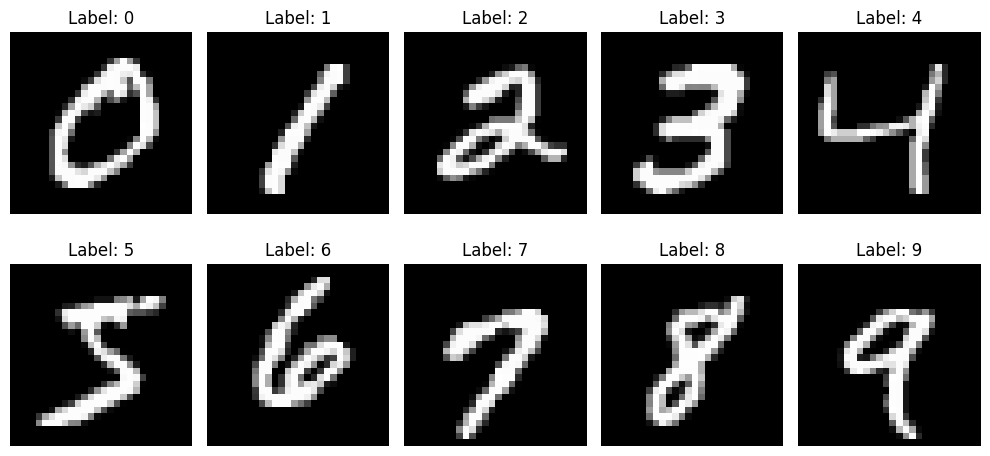

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9 * x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)
unique_classes = np.unique(y_train)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, label in enumerate(unique_classes):
    index = np.where(y_train == label)[0][0]  # Get first occurrence of each class
    ax = axes[i // 5, i % 5]  # Arrange in 2x5 grid
    ax.imshow(x_train[index], cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0



In [ ]:
def train_sweep_mnist(losse):
    run = wandb.init()
    config = wandb.config

    run_name = f"_ac_{config.activation}_opt_{config.optimizer}_ls_{config.layer_size}"
    wandb.run.name = run_name
    wandb.run.save()

    loss_function = losse

    model = NeuralNetwork(
        layers=[784] + [config.layer_size]*5 + [10],
        learning_rate=0.001,
        optimizer=config.optimizer,
        weight_decay=0,
        weight_init="xavier",
        activation=config.activation,
        loss=loss_function
    )
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=10, batch_size=64)

    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    run.finish()


In [ ]:
sweep_config2 = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        # "epochs": {"values": [5, 10]},
        # "hidden_layers": {"values": [3, 4, 5]},
        "layer_size": {"values": [32, 64, 128]},
        # "weight_decay": {"values": [0, 0.0005, 0.5]},
        # "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        # "batch_size": {"values": [16, 32, 64]},
        # "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config2, project="DA6401_Assignment_count250")
wandb.agent(sweep_id, function=lambda: train_sweep_mnist("cross_entropy"), count=50)

Create sweep with ID: cpk04zvi
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment_count250/sweeps/cpk04zvi


wandb: Agent Starting Run: y74wavqb with config:
wandb: 	activation: tanh
wandb: 	layer_size: 32
wandb: 	optimizer: adam


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Epoch 1/10 - Train Acc: 0.5087, Train Loss: 1.3055, Val Acc: 0.4417, Val Loss: 1.4758
Epoch 2/10 - Train Acc: 0.6128, Train Loss: 1.0637, Val Acc: 0.4875, Val Loss: 1.3011
Epoch 3/10 - Train Acc: 0.5992, Train Loss: 1.1221, Val Acc: 0.4835, Val Loss: 1.3530
Epoch 4/10 - Train Acc: 0.6107, Train Loss: 1.1295, Val Acc: 0.4848, Val Loss: 1.4781
Epoch 5/10 - Train Acc: 0.6037, Train Loss: 1.1745, Val Acc: 0.4328, Val Loss: 1.4801
Epoch 6/10 - Train Acc: 0.5656, Train Loss: 1.2545, Val Acc: 0.4302, Val Loss: 1.4357
Epoch 7/10 - Train Acc: 0.5280, Train Loss: 1.3213, Val Acc: 0.3727, Val Loss: 1.4535
Epoch 8/10 - Train Acc: 0.4827, Train Loss: 1.3722, Val Acc: 0.5225, Val Loss: 1.3082
Epoch 9/10 - Train Acc: 0.4858, Train Loss: 1.3756, Val Acc: 0.4890, Val Loss: 1.3272
Epoch 10/10 - Train Acc: 0.4840, Train Loss: 1.3747, Val Acc: 0.4820, Val Loss: 1.3459
Test Accuracy: 48.74%, Test Loss: 1.3566
Final Test Accuracy: 0.4874, Test Loss: 1.3566


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▂█▇██▅▃▁▁▁
Train Loss,▆▁▂▂▃▅▇███
Validation Accuracy,▄▆▆▆▄▄▁█▆▆
Validation Loss,█▁▃██▆▇▁▂▃
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.4874
Test Loss,1.3566
Train Accuracy,0.48398
Train Loss,1.3747


wandb: Agent Starting Run: q4uokq7c with config:
wandb: 	activation: tanh
wandb: 	layer_size: 32
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.5020, Train Loss: 1.3395, Val Acc: 0.4498, Val Loss: 1.4130
Epoch 2/10 - Train Acc: 0.6219, Train Loss: 1.0467, Val Acc: 0.4680, Val Loss: 1.4892
Epoch 3/10 - Train Acc: 0.5797, Train Loss: 1.1463, Val Acc: 0.4450, Val Loss: 1.4934
Epoch 4/10 - Train Acc: 0.5790, Train Loss: 1.1623, Val Acc: 0.4652, Val Loss: 1.3520
Epoch 5/10 - Train Acc: 0.6185, Train Loss: 1.0949, Val Acc: 0.4955, Val Loss: 1.3360
Epoch 6/10 - Train Acc: 0.6125, Train Loss: 1.1051, Val Acc: 0.4940, Val Loss: 1.3164
Epoch 7/10 - Train Acc: 0.6066, Train Loss: 1.1046, Val Acc: 0.4483, Val Loss: 1.3325
Epoch 8/10 - Train Acc: 0.6037, Train Loss: 1.1110, Val Acc: 0.5103, Val Loss: 1.3826
Epoch 9/10 - Train Acc: 0.6040, Train Loss: 1.1289, Val Acc: 0.5103, Val Loss: 1.3653
Epoch 10/10 - Train Acc: 0.6063, Train Loss: 1.1313, Val Acc: 0.4927, Val Loss: 1.4467
Test Accuracy: 61.13%, Test Loss: 1.1244
Final Test Accuracy: 0.6113, Test Loss: 1.1244


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█▆▅█▇▇▇▇▇
Train Loss,█▁▃▄▂▂▂▃▃▃
Validation Accuracy,▂▃▁▃▆▆▁██▆
Validation Loss,▅██▂▂▁▂▄▃▆
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.6113
Test Loss,1.1244
Train Accuracy,0.60633
Train Loss,1.13135


wandb: Agent Starting Run: tfd6fqla with config:
wandb: 	activation: sigmoid
wandb: 	layer_size: 128
wandb: 	optimizer: sgd


Epoch 1/10 - Train Acc: 0.1075, Train Loss: 2.3121, Val Acc: 0.1050, Val Loss: 2.3021
Epoch 2/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3020
Epoch 3/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3021
Epoch 4/10 - Train Acc: 0.1132, Train Loss: 2.3012, Val Acc: 0.1050, Val Loss: 2.3019
Epoch 5/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3019
Epoch 6/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3022
Epoch 7/10 - Train Acc: 0.1132, Train Loss: 2.3012, Val Acc: 0.1050, Val Loss: 2.3026
Epoch 8/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3019
Epoch 9/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3018
Epoch 10/10 - Train Acc: 0.1132, Train Loss: 2.3013, Val Acc: 0.1050, Val Loss: 2.3018
Test Accuracy: 11.35%, Test Loss: 2.3011
Final Test Accuracy: 0.1135, Test Loss: 2.3011


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█████████
Train Loss,█▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▃▃▄▂▂▄█▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1135
Test Loss,2.30106
Train Accuracy,0.11319
Train Loss,2.30128


wandb: Agent Starting Run: oo7kz4c9 with config:
wandb: 	activation: relu
wandb: 	layer_size: 32
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.4691, Train Loss: 1.4079, Val Acc: 0.7140, Val Loss: 5.0539
Epoch 2/10 - Train Acc: 0.7381, Train Loss: 0.8041, Val Acc: 0.8182, Val Loss: 3.2397
Epoch 3/10 - Train Acc: 0.8022, Train Loss: 0.6475, Val Acc: 0.8597, Val Loss: 2.5517
Epoch 4/10 - Train Acc: 0.8354, Train Loss: 0.5544, Val Acc: 0.8720, Val Loss: 2.3057
Epoch 5/10 - Train Acc: 0.8587, Train Loss: 0.4806, Val Acc: 0.8882, Val Loss: 2.0102
Epoch 6/10 - Train Acc: 0.8759, Train Loss: 0.4222, Val Acc: 0.8975, Val Loss: 1.8311
Epoch 7/10 - Train Acc: 0.8880, Train Loss: 0.3792, Val Acc: 0.9058, Val Loss: 1.6934
Epoch 8/10 - Train Acc: 0.8975, Train Loss: 0.3475, Val Acc: 0.9145, Val Loss: 1.5511
Epoch 9/10 - Train Acc: 0.9054, Train Loss: 0.3216, Val Acc: 0.9140, Val Loss: 1.5644
Epoch 10/10 - Train Acc: 0.9107, Train Loss: 0.3012, Val Acc: 0.9165, Val Loss: 1.5226
Test Accuracy: 90.42%, Test Loss: 0.3376
Final Test Accuracy: 0.9042, Test Loss: 0.3376


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇████
Validation Loss,█▄▃▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9042
Test Loss,0.33764
Train Accuracy,0.91069
Train Loss,0.30123


wandb: Agent Starting Run: 6ip5dyxu with config:
wandb: 	activation: relu
wandb: 	layer_size: 64
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6242, Train Loss: 1.0906, Val Acc: 0.7728, Val Loss: 4.0865
Epoch 2/10 - Train Acc: 0.8309, Train Loss: 0.5668, Val Acc: 0.8963, Val Loss: 1.8719
Epoch 3/10 - Train Acc: 0.8864, Train Loss: 0.3968, Val Acc: 0.9222, Val Loss: 1.4079
Epoch 4/10 - Train Acc: 0.9099, Train Loss: 0.3210, Val Acc: 0.9353, Val Loss: 1.1782
Epoch 5/10 - Train Acc: 0.9232, Train Loss: 0.2722, Val Acc: 0.9355, Val Loss: 1.1788
Epoch 6/10 - Train Acc: 0.9322, Train Loss: 0.2374, Val Acc: 0.9410, Val Loss: 1.0722
Epoch 7/10 - Train Acc: 0.9399, Train Loss: 0.2105, Val Acc: 0.9462, Val Loss: 0.9815
Epoch 8/10 - Train Acc: 0.9464, Train Loss: 0.1890, Val Acc: 0.9505, Val Loss: 0.9025
Epoch 9/10 - Train Acc: 0.9523, Train Loss: 0.1696, Val Acc: 0.9443, Val Loss: 1.0142
Epoch 10/10 - Train Acc: 0.9566, Train Loss: 0.1536, Val Acc: 0.9530, Val Loss: 0.8479
Test Accuracy: 94.68%, Test Loss: 0.1934
Final Test Accuracy: 0.9468, Test Loss: 0.1934


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▆▇▇▇█████
Validation Loss,█▃▂▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9468
Test Loss,0.19344
Train Accuracy,0.95659
Train Loss,0.15358


wandb: Agent Starting Run: 4wwf5bm9 with config:
wandb: 	activation: relu
wandb: 	layer_size: 64
wandb: 	optimizer: adam


Epoch 1/10 - Train Acc: 0.6707, Train Loss: 0.9939, Val Acc: 0.8310, Val Loss: 3.0292
Epoch 2/10 - Train Acc: 0.8470, Train Loss: 0.5204, Val Acc: 0.8930, Val Loss: 1.9288
Epoch 3/10 - Train Acc: 0.8869, Train Loss: 0.3921, Val Acc: 0.9118, Val Loss: 1.5902
Epoch 4/10 - Train Acc: 0.9082, Train Loss: 0.3185, Val Acc: 0.9280, Val Loss: 1.3118
Epoch 5/10 - Train Acc: 0.9244, Train Loss: 0.2667, Val Acc: 0.9388, Val Loss: 1.1134
Epoch 6/10 - Train Acc: 0.9387, Train Loss: 0.2144, Val Acc: 0.9480, Val Loss: 0.9364
Epoch 7/10 - Train Acc: 0.9490, Train Loss: 0.1794, Val Acc: 0.9505, Val Loss: 0.9028
Epoch 8/10 - Train Acc: 0.9557, Train Loss: 0.1567, Val Acc: 0.9553, Val Loss: 0.8075
Epoch 9/10 - Train Acc: 0.9605, Train Loss: 0.1378, Val Acc: 0.9590, Val Loss: 0.7476
Epoch 10/10 - Train Acc: 0.9643, Train Loss: 0.1239, Val Acc: 0.9565, Val Loss: 0.7848
Test Accuracy: 95.53%, Test Loss: 0.1602
Final Test Accuracy: 0.9553, Test Loss: 0.1602


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▃▂▂▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇████
Validation Loss,█▅▄▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9553
Test Loss,0.16023
Train Accuracy,0.96431
Train Loss,0.12387


wandb: Agent Starting Run: ekaz0qz1 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7189, Train Loss: 0.8615, Val Acc: 0.8643, Val Loss: 2.4484
Epoch 2/10 - Train Acc: 0.8856, Train Loss: 0.4008, Val Acc: 0.9255, Val Loss: 1.3439
Epoch 3/10 - Train Acc: 0.9241, Train Loss: 0.2675, Val Acc: 0.9458, Val Loss: 0.9810
Epoch 4/10 - Train Acc: 0.9456, Train Loss: 0.1933, Val Acc: 0.9465, Val Loss: 0.9735
Epoch 5/10 - Train Acc: 0.9556, Train Loss: 0.1545, Val Acc: 0.9627, Val Loss: 0.6747
Epoch 6/10 - Train Acc: 0.9637, Train Loss: 0.1263, Val Acc: 0.9652, Val Loss: 0.6273
Epoch 7/10 - Train Acc: 0.9697, Train Loss: 0.1038, Val Acc: 0.9663, Val Loss: 0.6107
Epoch 8/10 - Train Acc: 0.9750, Train Loss: 0.0867, Val Acc: 0.9687, Val Loss: 0.5727
Epoch 9/10 - Train Acc: 0.9782, Train Loss: 0.0740, Val Acc: 0.9660, Val Loss: 0.6166
Epoch 10/10 - Train Acc: 0.9813, Train Loss: 0.0626, Val Acc: 0.9673, Val Loss: 0.5965
Test Accuracy: 96.46%, Test Loss: 0.1316
Final Test Accuracy: 0.9646, Test Loss: 0.1316


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇██████
Validation Loss,█▄▃▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9646
Test Loss,0.1316
Train Accuracy,0.98128
Train Loss,0.06256


wandb: Agent Starting Run: 592qyiuo with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: adam


Epoch 1/10 - Train Acc: 0.6941, Train Loss: 0.8925, Val Acc: 0.8820, Val Loss: 2.1401
Epoch 2/10 - Train Acc: 0.8928, Train Loss: 0.3736, Val Acc: 0.9307, Val Loss: 1.2666
Epoch 3/10 - Train Acc: 0.9283, Train Loss: 0.2526, Val Acc: 0.9415, Val Loss: 1.0689
Epoch 4/10 - Train Acc: 0.9456, Train Loss: 0.1909, Val Acc: 0.9523, Val Loss: 0.8744
Epoch 5/10 - Train Acc: 0.9554, Train Loss: 0.1565, Val Acc: 0.9575, Val Loss: 0.7690
Epoch 6/10 - Train Acc: 0.9640, Train Loss: 0.1284, Val Acc: 0.9602, Val Loss: 0.7247
Epoch 7/10 - Train Acc: 0.9699, Train Loss: 0.1076, Val Acc: 0.9607, Val Loss: 0.7108
Epoch 8/10 - Train Acc: 0.9738, Train Loss: 0.0910, Val Acc: 0.9655, Val Loss: 0.6250
Epoch 9/10 - Train Acc: 0.9775, Train Loss: 0.0752, Val Acc: 0.9703, Val Loss: 0.5414
Epoch 10/10 - Train Acc: 0.9812, Train Loss: 0.0648, Val Acc: 0.9678, Val Loss: 0.5861
Test Accuracy: 96.20%, Test Loss: 0.1432
Final Test Accuracy: 0.9620, Test Loss: 0.1432


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇▇███
Validation Loss,█▄▃▂▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.962
Test Loss,0.14321
Train Accuracy,0.98119
Train Loss,0.06477


wandb: Agent Starting Run: n6wzzwgo with config:
wandb: 	activation: relu
wandb: 	layer_size: 32
wandb: 	optimizer: momentum


Epoch 1/10 - Train Acc: 0.1121, Train Loss: 2.3018, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 2/10 - Train Acc: 0.1132, Train Loss: 2.3012, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 3/10 - Train Acc: 0.1132, Train Loss: 2.3012, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 4/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 5/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 6/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 7/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3012
Epoch 8/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 9/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3013
Epoch 10/10 - Train Acc: 0.1132, Train Loss: 2.3011, Val Acc: 0.1050, Val Loss: 2.3013
Test Accuracy: 11.35%, Test Loss: 2.3010
Final Test Accuracy: 0.1135, Test Loss: 2.3010


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁█████████
Train Loss,█▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▄▄▇▅▇█▁▄▄▇
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.1135
Test Loss,2.30102
Train Accuracy,0.11319
Train Loss,2.30113


wandb: Agent Starting Run: ibfok8o1 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6910, Train Loss: 0.8813, Val Acc: 0.8668, Val Loss: 2.3951
Epoch 2/10 - Train Acc: 0.8873, Train Loss: 0.3833, Val Acc: 0.9272, Val Loss: 1.3080
Epoch 3/10 - Train Acc: 0.9253, Train Loss: 0.2609, Val Acc: 0.9363, Val Loss: 1.1640
Epoch 4/10 - Train Acc: 0.9443, Train Loss: 0.1968, Val Acc: 0.9473, Val Loss: 0.9538
Epoch 5/10 - Train Acc: 0.9550, Train Loss: 0.1574, Val Acc: 0.9567, Val Loss: 0.7850
Epoch 6/10 - Train Acc: 0.9627, Train Loss: 0.1274, Val Acc: 0.9575, Val Loss: 0.7827
Epoch 7/10 - Train Acc: 0.9700, Train Loss: 0.1056, Val Acc: 0.9627, Val Loss: 0.6762
Epoch 8/10 - Train Acc: 0.9747, Train Loss: 0.0884, Val Acc: 0.9597, Val Loss: 0.7388
Epoch 9/10 - Train Acc: 0.9779, Train Loss: 0.0760, Val Acc: 0.9657, Val Loss: 0.6260
Epoch 10/10 - Train Acc: 0.9813, Train Loss: 0.0645, Val Acc: 0.9657, Val Loss: 0.6288
Test Accuracy: 96.47%, Test Loss: 0.1396
Final Test Accuracy: 0.9647, Test Loss: 0.1396


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9647
Test Loss,0.1396
Train Accuracy,0.98133
Train Loss,0.06452


wandb: Agent Starting Run: kivvj7mw with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7328, Train Loss: 0.8306, Val Acc: 0.9015, Val Loss: 1.7723
Epoch 2/10 - Train Acc: 0.9137, Train Loss: 0.3060, Val Acc: 0.9352, Val Loss: 1.1741
Epoch 3/10 - Train Acc: 0.9420, Train Loss: 0.2050, Val Acc: 0.9512, Val Loss: 0.8822
Epoch 4/10 - Train Acc: 0.9556, Train Loss: 0.1558, Val Acc: 0.9580, Val Loss: 0.7515
Epoch 5/10 - Train Acc: 0.9644, Train Loss: 0.1244, Val Acc: 0.9642, Val Loss: 0.6515
Epoch 6/10 - Train Acc: 0.9700, Train Loss: 0.1030, Val Acc: 0.9682, Val Loss: 0.5760
Epoch 7/10 - Train Acc: 0.9743, Train Loss: 0.0858, Val Acc: 0.9667, Val Loss: 0.6054
Epoch 8/10 - Train Acc: 0.9789, Train Loss: 0.0721, Val Acc: 0.9730, Val Loss: 0.4960
Epoch 9/10 - Train Acc: 0.9826, Train Loss: 0.0616, Val Acc: 0.9703, Val Loss: 0.5421
Epoch 10/10 - Train Acc: 0.9842, Train Loss: 0.0545, Val Acc: 0.9722, Val Loss: 0.5033
Test Accuracy: 96.68%, Test Loss: 0.1334
Final Test Accuracy: 0.9668, Test Loss: 0.1334


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇█▇███
Validation Loss,█▅▃▂▂▁▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9668
Test Loss,0.13341
Train Accuracy,0.9842
Train Loss,0.05446


wandb: Agent Starting Run: aikzzsh1 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7119, Train Loss: 0.8235, Val Acc: 0.8718, Val Loss: 2.3195
Epoch 2/10 - Train Acc: 0.8893, Train Loss: 0.3760, Val Acc: 0.9257, Val Loss: 1.3476
Epoch 3/10 - Train Acc: 0.9218, Train Loss: 0.2720, Val Acc: 0.9388, Val Loss: 1.1097
Epoch 4/10 - Train Acc: 0.9374, Train Loss: 0.2174, Val Acc: 0.9483, Val Loss: 0.9366
Epoch 5/10 - Train Acc: 0.9501, Train Loss: 0.1766, Val Acc: 0.9527, Val Loss: 0.8581
Epoch 6/10 - Train Acc: 0.9583, Train Loss: 0.1477, Val Acc: 0.9483, Val Loss: 0.9435
Epoch 7/10 - Train Acc: 0.9652, Train Loss: 0.1244, Val Acc: 0.9593, Val Loss: 0.7461
Epoch 8/10 - Train Acc: 0.9704, Train Loss: 0.1041, Val Acc: 0.9597, Val Loss: 0.7342
Epoch 9/10 - Train Acc: 0.9745, Train Loss: 0.0881, Val Acc: 0.9627, Val Loss: 0.6826
Epoch 10/10 - Train Acc: 0.9794, Train Loss: 0.0721, Val Acc: 0.9673, Val Loss: 0.5884
Test Accuracy: 96.39%, Test Loss: 0.1458
Final Test Accuracy: 0.9639, Test Loss: 0.1458


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇▇▇██
Validation Loss,█▄▃▂▂▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9639
Test Loss,0.14582
Train Accuracy,0.97939
Train Loss,0.07215


wandb: Agent Starting Run: 5v6839sk with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7249, Train Loss: 0.8367, Val Acc: 0.8948, Val Loss: 1.9006
Epoch 2/10 - Train Acc: 0.8959, Train Loss: 0.3629, Val Acc: 0.9275, Val Loss: 1.3073
Epoch 3/10 - Train Acc: 0.9264, Train Loss: 0.2589, Val Acc: 0.9440, Val Loss: 1.0179
Epoch 4/10 - Train Acc: 0.9433, Train Loss: 0.2024, Val Acc: 0.9568, Val Loss: 0.7867
Epoch 5/10 - Train Acc: 0.9533, Train Loss: 0.1647, Val Acc: 0.9602, Val Loss: 0.7258
Epoch 6/10 - Train Acc: 0.9609, Train Loss: 0.1391, Val Acc: 0.9650, Val Loss: 0.6351
Epoch 7/10 - Train Acc: 0.9673, Train Loss: 0.1153, Val Acc: 0.9665, Val Loss: 0.6088
Epoch 8/10 - Train Acc: 0.9718, Train Loss: 0.0972, Val Acc: 0.9672, Val Loss: 0.6029
Epoch 9/10 - Train Acc: 0.9757, Train Loss: 0.0815, Val Acc: 0.9695, Val Loss: 0.5572
Epoch 10/10 - Train Acc: 0.9792, Train Loss: 0.0703, Val Acc: 0.9683, Val Loss: 0.5801
Test Accuracy: 96.57%, Test Loss: 0.1346
Final Test Accuracy: 0.9657, Test Loss: 0.1346


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▇▇█████
Validation Loss,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9657
Test Loss,0.13458
Train Accuracy,0.97919
Train Loss,0.07032


wandb: Agent Starting Run: eev8v7g2 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7177, Train Loss: 0.8492, Val Acc: 0.8720, Val Loss: 2.3205
Epoch 2/10 - Train Acc: 0.8940, Train Loss: 0.3656, Val Acc: 0.9322, Val Loss: 1.2398
Epoch 3/10 - Train Acc: 0.9272, Train Loss: 0.2541, Val Acc: 0.9453, Val Loss: 0.9971
Epoch 4/10 - Train Acc: 0.9446, Train Loss: 0.1944, Val Acc: 0.9537, Val Loss: 0.8380
Epoch 5/10 - Train Acc: 0.9563, Train Loss: 0.1515, Val Acc: 0.9617, Val Loss: 0.7035
Epoch 6/10 - Train Acc: 0.9646, Train Loss: 0.1226, Val Acc: 0.9652, Val Loss: 0.6329
Epoch 7/10 - Train Acc: 0.9705, Train Loss: 0.1013, Val Acc: 0.9667, Val Loss: 0.6096
Epoch 8/10 - Train Acc: 0.9757, Train Loss: 0.0823, Val Acc: 0.9635, Val Loss: 0.6674
Epoch 9/10 - Train Acc: 0.9804, Train Loss: 0.0699, Val Acc: 0.9677, Val Loss: 0.5917
Epoch 10/10 - Train Acc: 0.9820, Train Loss: 0.0623, Val Acc: 0.9665, Val Loss: 0.6051
Test Accuracy: 96.52%, Test Loss: 0.1353
Final Test Accuracy: 0.9652, Test Loss: 0.1353


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇██████
Validation Loss,█▄▃▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9652
Test Loss,0.13529
Train Accuracy,0.98202
Train Loss,0.06226


wandb: Agent Starting Run: 3gxalvzp with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7249, Train Loss: 0.8297, Val Acc: 0.8918, Val Loss: 1.9456
Epoch 2/10 - Train Acc: 0.8957, Train Loss: 0.3656, Val Acc: 0.9235, Val Loss: 1.3849
Epoch 3/10 - Train Acc: 0.9270, Train Loss: 0.2612, Val Acc: 0.9417, Val Loss: 1.0611
Epoch 4/10 - Train Acc: 0.9409, Train Loss: 0.2097, Val Acc: 0.9480, Val Loss: 0.9454
Epoch 5/10 - Train Acc: 0.9514, Train Loss: 0.1713, Val Acc: 0.9533, Val Loss: 0.8501
Epoch 6/10 - Train Acc: 0.9606, Train Loss: 0.1404, Val Acc: 0.9568, Val Loss: 0.7873
Epoch 7/10 - Train Acc: 0.9679, Train Loss: 0.1141, Val Acc: 0.9605, Val Loss: 0.7235
Epoch 8/10 - Train Acc: 0.9723, Train Loss: 0.0970, Val Acc: 0.9623, Val Loss: 0.6891
Epoch 9/10 - Train Acc: 0.9762, Train Loss: 0.0827, Val Acc: 0.9582, Val Loss: 0.7652
Epoch 10/10 - Train Acc: 0.9803, Train Loss: 0.0694, Val Acc: 0.9658, Val Loss: 0.6239
Test Accuracy: 96.34%, Test Loss: 0.1467
Final Test Accuracy: 0.9634, Test Loss: 0.1467


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇█▇█
Validation Loss,█▅▃▃▂▂▂▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9634
Test Loss,0.1467
Train Accuracy,0.98028
Train Loss,0.06936


wandb: Agent Starting Run: gb8rszcv with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7057, Train Loss: 0.8623, Val Acc: 0.8952, Val Loss: 1.9025
Epoch 2/10 - Train Acc: 0.9000, Train Loss: 0.3454, Val Acc: 0.9307, Val Loss: 1.2574
Epoch 3/10 - Train Acc: 0.9321, Train Loss: 0.2320, Val Acc: 0.9520, Val Loss: 0.8709
Epoch 4/10 - Train Acc: 0.9492, Train Loss: 0.1746, Val Acc: 0.9553, Val Loss: 0.8164
Epoch 5/10 - Train Acc: 0.9588, Train Loss: 0.1404, Val Acc: 0.9625, Val Loss: 0.6828
Epoch 6/10 - Train Acc: 0.9675, Train Loss: 0.1133, Val Acc: 0.9580, Val Loss: 0.7644
Epoch 7/10 - Train Acc: 0.9733, Train Loss: 0.0914, Val Acc: 0.9610, Val Loss: 0.7147
Epoch 8/10 - Train Acc: 0.9777, Train Loss: 0.0779, Val Acc: 0.9682, Val Loss: 0.5748
Epoch 9/10 - Train Acc: 0.9804, Train Loss: 0.0659, Val Acc: 0.9697, Val Loss: 0.5547
Epoch 10/10 - Train Acc: 0.9841, Train Loss: 0.0560, Val Acc: 0.9745, Val Loss: 0.4617
Test Accuracy: 96.91%, Test Loss: 0.1219
Final Test Accuracy: 0.9691, Test Loss: 0.1219


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇▇██
Validation Loss,█▅▃▃▂▂▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9691
Test Loss,0.12187
Train Accuracy,0.98413
Train Loss,0.05598


wandb: Agent Starting Run: go4fib2u with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6881, Train Loss: 0.8880, Val Acc: 0.8612, Val Loss: 2.4899
Epoch 2/10 - Train Acc: 0.8883, Train Loss: 0.3884, Val Acc: 0.9185, Val Loss: 1.4710
Epoch 3/10 - Train Acc: 0.9267, Train Loss: 0.2643, Val Acc: 0.9410, Val Loss: 1.0690
Epoch 4/10 - Train Acc: 0.9435, Train Loss: 0.2020, Val Acc: 0.9520, Val Loss: 0.8734
Epoch 5/10 - Train Acc: 0.9532, Train Loss: 0.1653, Val Acc: 0.9585, Val Loss: 0.7578
Epoch 6/10 - Train Acc: 0.9605, Train Loss: 0.1383, Val Acc: 0.9610, Val Loss: 0.7089
Epoch 7/10 - Train Acc: 0.9672, Train Loss: 0.1158, Val Acc: 0.9630, Val Loss: 0.6788
Epoch 8/10 - Train Acc: 0.9719, Train Loss: 0.0979, Val Acc: 0.9640, Val Loss: 0.6484
Epoch 9/10 - Train Acc: 0.9757, Train Loss: 0.0835, Val Acc: 0.9680, Val Loss: 0.5833
Epoch 10/10 - Train Acc: 0.9796, Train Loss: 0.0698, Val Acc: 0.9695, Val Loss: 0.5541
Test Accuracy: 96.45%, Test Loss: 0.1343
Final Test Accuracy: 0.9645, Test Loss: 0.1343


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9645
Test Loss,0.13433
Train Accuracy,0.97956
Train Loss,0.06983


wandb: Agent Starting Run: vsyaxynm with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7009, Train Loss: 0.8697, Val Acc: 0.8643, Val Loss: 2.4559
Epoch 2/10 - Train Acc: 0.8891, Train Loss: 0.3732, Val Acc: 0.9367, Val Loss: 1.1535
Epoch 3/10 - Train Acc: 0.9364, Train Loss: 0.2231, Val Acc: 0.9547, Val Loss: 0.8207
Epoch 4/10 - Train Acc: 0.9536, Train Loss: 0.1603, Val Acc: 0.9650, Val Loss: 0.6378
Epoch 5/10 - Train Acc: 0.9642, Train Loss: 0.1222, Val Acc: 0.9640, Val Loss: 0.6591
Epoch 6/10 - Train Acc: 0.9712, Train Loss: 0.0993, Val Acc: 0.9670, Val Loss: 0.6041
Epoch 7/10 - Train Acc: 0.9758, Train Loss: 0.0830, Val Acc: 0.9697, Val Loss: 0.5552
Epoch 8/10 - Train Acc: 0.9796, Train Loss: 0.0713, Val Acc: 0.9707, Val Loss: 0.5385
Epoch 9/10 - Train Acc: 0.9821, Train Loss: 0.0607, Val Acc: 0.9712, Val Loss: 0.5267
Epoch 10/10 - Train Acc: 0.9846, Train Loss: 0.0521, Val Acc: 0.9735, Val Loss: 0.4834
Test Accuracy: 97.03%, Test Loss: 0.1169
Final Test Accuracy: 0.9703, Test Loss: 0.1169


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▂▂▂▁▁▁▁▁
Validation Accuracy,▁▆▇▇▇█████
Validation Loss,█▃▂▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9703
Test Loss,0.11686
Train Accuracy,0.98457
Train Loss,0.05208


wandb: Agent Starting Run: gikmovkp with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7696, Train Loss: 0.7152, Val Acc: 0.9040, Val Loss: 1.7208
Epoch 2/10 - Train Acc: 0.9028, Train Loss: 0.3346, Val Acc: 0.9307, Val Loss: 1.2580
Epoch 3/10 - Train Acc: 0.9341, Train Loss: 0.2292, Val Acc: 0.9543, Val Loss: 0.8300
Epoch 4/10 - Train Acc: 0.9499, Train Loss: 0.1725, Val Acc: 0.9618, Val Loss: 0.6928
Epoch 5/10 - Train Acc: 0.9594, Train Loss: 0.1376, Val Acc: 0.9642, Val Loss: 0.6488
Epoch 6/10 - Train Acc: 0.9672, Train Loss: 0.1133, Val Acc: 0.9672, Val Loss: 0.5892
Epoch 7/10 - Train Acc: 0.9721, Train Loss: 0.0942, Val Acc: 0.9672, Val Loss: 0.5954
Epoch 8/10 - Train Acc: 0.9766, Train Loss: 0.0802, Val Acc: 0.9715, Val Loss: 0.5221
Epoch 9/10 - Train Acc: 0.9796, Train Loss: 0.0693, Val Acc: 0.9667, Val Loss: 0.5983
Epoch 10/10 - Train Acc: 0.9821, Train Loss: 0.0603, Val Acc: 0.9675, Val Loss: 0.5925
Test Accuracy: 96.61%, Test Loss: 0.1341
Final Test Accuracy: 0.9661, Test Loss: 0.1341


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▇▇███▇█
Validation Loss,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9661
Test Loss,0.13414
Train Accuracy,0.98215
Train Loss,0.06033


wandb: Agent Starting Run: 6upg7pk1 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6919, Train Loss: 0.8932, Val Acc: 0.8618, Val Loss: 2.4872
Epoch 2/10 - Train Acc: 0.8796, Train Loss: 0.4106, Val Acc: 0.9228, Val Loss: 1.4074
Epoch 3/10 - Train Acc: 0.9196, Train Loss: 0.2835, Val Acc: 0.9425, Val Loss: 1.0367
Epoch 4/10 - Train Acc: 0.9391, Train Loss: 0.2168, Val Acc: 0.9473, Val Loss: 0.9579
Epoch 5/10 - Train Acc: 0.9505, Train Loss: 0.1745, Val Acc: 0.9598, Val Loss: 0.7336
Epoch 6/10 - Train Acc: 0.9615, Train Loss: 0.1406, Val Acc: 0.9603, Val Loss: 0.7175
Epoch 7/10 - Train Acc: 0.9675, Train Loss: 0.1173, Val Acc: 0.9623, Val Loss: 0.6884
Epoch 8/10 - Train Acc: 0.9729, Train Loss: 0.0972, Val Acc: 0.9663, Val Loss: 0.6090
Epoch 9/10 - Train Acc: 0.9769, Train Loss: 0.0802, Val Acc: 0.9712, Val Loss: 0.5243
Epoch 10/10 - Train Acc: 0.9803, Train Loss: 0.0682, Val Acc: 0.9688, Val Loss: 0.5676
Test Accuracy: 96.41%, Test Loss: 0.1411
Final Test Accuracy: 0.9641, Test Loss: 0.1411


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇▇███
Validation Loss,█▄▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9641
Test Loss,0.14114
Train Accuracy,0.98026
Train Loss,0.06818


wandb: Agent Starting Run: e2tn3fyy with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: adam


Epoch 1/10 - Train Acc: 0.7207, Train Loss: 0.8346, Val Acc: 0.9055, Val Loss: 1.7018
Epoch 2/10 - Train Acc: 0.9096, Train Loss: 0.3077, Val Acc: 0.9425, Val Loss: 1.0386
Epoch 3/10 - Train Acc: 0.9402, Train Loss: 0.2017, Val Acc: 0.9563, Val Loss: 0.8002
Epoch 4/10 - Train Acc: 0.9538, Train Loss: 0.1568, Val Acc: 0.9602, Val Loss: 0.7296
Epoch 5/10 - Train Acc: 0.9632, Train Loss: 0.1255, Val Acc: 0.9583, Val Loss: 0.7548
Epoch 6/10 - Train Acc: 0.9701, Train Loss: 0.1031, Val Acc: 0.9668, Val Loss: 0.6074
Epoch 7/10 - Train Acc: 0.9749, Train Loss: 0.0858, Val Acc: 0.9660, Val Loss: 0.6227
Epoch 8/10 - Train Acc: 0.9782, Train Loss: 0.0744, Val Acc: 0.9653, Val Loss: 0.6210
Epoch 9/10 - Train Acc: 0.9822, Train Loss: 0.0629, Val Acc: 0.9698, Val Loss: 0.5503
Epoch 10/10 - Train Acc: 0.9843, Train Loss: 0.0535, Val Acc: 0.9707, Val Loss: 0.5332
Test Accuracy: 96.98%, Test Loss: 0.1198
Final Test Accuracy: 0.9698, Test Loss: 0.1198


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇█▇▇██
Validation Loss,█▄▃▂▂▁▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9698
Test Loss,0.11982
Train Accuracy,0.98426
Train Loss,0.05354


wandb: Agent Starting Run: smsy7k1j with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6917, Train Loss: 0.8842, Val Acc: 0.8893, Val Loss: 2.0080
Epoch 2/10 - Train Acc: 0.8919, Train Loss: 0.3771, Val Acc: 0.9343, Val Loss: 1.1942
Epoch 3/10 - Train Acc: 0.9291, Train Loss: 0.2512, Val Acc: 0.9482, Val Loss: 0.9448
Epoch 4/10 - Train Acc: 0.9503, Train Loss: 0.1766, Val Acc: 0.9587, Val Loss: 0.7556
Epoch 5/10 - Train Acc: 0.9612, Train Loss: 0.1382, Val Acc: 0.9643, Val Loss: 0.6474
Epoch 6/10 - Train Acc: 0.9684, Train Loss: 0.1105, Val Acc: 0.9673, Val Loss: 0.5970
Epoch 7/10 - Train Acc: 0.9747, Train Loss: 0.0924, Val Acc: 0.9692, Val Loss: 0.5653
Epoch 8/10 - Train Acc: 0.9787, Train Loss: 0.0760, Val Acc: 0.9658, Val Loss: 0.6294
Epoch 9/10 - Train Acc: 0.9819, Train Loss: 0.0631, Val Acc: 0.9692, Val Loss: 0.5606
Epoch 10/10 - Train Acc: 0.9841, Train Loss: 0.0552, Val Acc: 0.9693, Val Loss: 0.5515
Test Accuracy: 96.71%, Test Loss: 0.1378
Final Test Accuracy: 0.9671, Test Loss: 0.1378


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▇██████
Validation Loss,█▄▃▂▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9671
Test Loss,0.13777
Train Accuracy,0.98407
Train Loss,0.05519


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzaztvbn with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7229, Train Loss: 0.8276, Val Acc: 0.8785, Val Loss: 2.1913
Epoch 2/10 - Train Acc: 0.8851, Train Loss: 0.4011, Val Acc: 0.9207, Val Loss: 1.4335
Epoch 3/10 - Train Acc: 0.9205, Train Loss: 0.2800, Val Acc: 0.9400, Val Loss: 1.0912
Epoch 4/10 - Train Acc: 0.9398, Train Loss: 0.2119, Val Acc: 0.9533, Val Loss: 0.8524
Epoch 5/10 - Train Acc: 0.9520, Train Loss: 0.1685, Val Acc: 0.9568, Val Loss: 0.7763
Epoch 6/10 - Train Acc: 0.9612, Train Loss: 0.1340, Val Acc: 0.9610, Val Loss: 0.7102
Epoch 7/10 - Train Acc: 0.9684, Train Loss: 0.1089, Val Acc: 0.9613, Val Loss: 0.7054
Epoch 8/10 - Train Acc: 0.9738, Train Loss: 0.0901, Val Acc: 0.9667, Val Loss: 0.6081
Epoch 9/10 - Train Acc: 0.9779, Train Loss: 0.0754, Val Acc: 0.9708, Val Loss: 0.5329
Epoch 10/10 - Train Acc: 0.9809, Train Loss: 0.0646, Val Acc: 0.9725, Val Loss: 0.4976
Test Accuracy: 96.83%, Test Loss: 0.1260
Final Test Accuracy: 0.9683, Test Loss: 0.1260


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇▇███
Validation Loss,█▅▃▂▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9683
Test Loss,0.12598
Train Accuracy,0.98091
Train Loss,0.06456


wandb: Agent Starting Run: 9tsz0j1j with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7053, Train Loss: 0.8723, Val Acc: 0.8827, Val Loss: 2.1086
Epoch 2/10 - Train Acc: 0.8864, Train Loss: 0.3768, Val Acc: 0.9247, Val Loss: 1.3631
Epoch 3/10 - Train Acc: 0.9212, Train Loss: 0.2652, Val Acc: 0.9347, Val Loss: 1.1861
Epoch 4/10 - Train Acc: 0.9386, Train Loss: 0.2091, Val Acc: 0.9437, Val Loss: 1.0336
Epoch 5/10 - Train Acc: 0.9500, Train Loss: 0.1721, Val Acc: 0.9480, Val Loss: 0.9459
Epoch 6/10 - Train Acc: 0.9583, Train Loss: 0.1446, Val Acc: 0.9565, Val Loss: 0.7911
Epoch 7/10 - Train Acc: 0.9644, Train Loss: 0.1249, Val Acc: 0.9600, Val Loss: 0.7328
Epoch 8/10 - Train Acc: 0.9690, Train Loss: 0.1078, Val Acc: 0.9625, Val Loss: 0.6900
Epoch 9/10 - Train Acc: 0.9727, Train Loss: 0.0934, Val Acc: 0.9660, Val Loss: 0.6180
Epoch 10/10 - Train Acc: 0.9768, Train Loss: 0.0797, Val Acc: 0.9662, Val Loss: 0.6233
Test Accuracy: 96.13%, Test Loss: 0.1515
Final Test Accuracy: 0.9613, Test Loss: 0.1515


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▅▆▆▇▇███
Validation Loss,█▄▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9613
Test Loss,0.15155
Train Accuracy,0.97678
Train Loss,0.07969


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o8febehx with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7049, Train Loss: 0.8740, Val Acc: 0.8590, Val Loss: 2.5417
Epoch 2/10 - Train Acc: 0.8706, Train Loss: 0.4342, Val Acc: 0.9213, Val Loss: 1.4179
Epoch 3/10 - Train Acc: 0.9178, Train Loss: 0.2857, Val Acc: 0.9392, Val Loss: 1.1067
Epoch 4/10 - Train Acc: 0.9361, Train Loss: 0.2225, Val Acc: 0.9480, Val Loss: 0.9474
Epoch 5/10 - Train Acc: 0.9491, Train Loss: 0.1794, Val Acc: 0.9518, Val Loss: 0.8815
Epoch 6/10 - Train Acc: 0.9581, Train Loss: 0.1495, Val Acc: 0.9633, Val Loss: 0.6685
Epoch 7/10 - Train Acc: 0.9643, Train Loss: 0.1259, Val Acc: 0.9622, Val Loss: 0.6902
Epoch 8/10 - Train Acc: 0.9693, Train Loss: 0.1063, Val Acc: 0.9605, Val Loss: 0.7225
Epoch 9/10 - Train Acc: 0.9747, Train Loss: 0.0869, Val Acc: 0.9582, Val Loss: 0.7614
Epoch 10/10 - Train Acc: 0.9786, Train Loss: 0.0739, Val Acc: 0.9680, Val Loss: 0.5858
Test Accuracy: 96.60%, Test Loss: 0.1391
Final Test Accuracy: 0.9660, Test Loss: 0.1391


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇███▇█
Validation Loss,█▄▃▂▂▁▁▁▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.966
Test Loss,0.13907
Train Accuracy,0.97859
Train Loss,0.07394


wandb: Agent Starting Run: 92r01l9d with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6513, Train Loss: 0.9645, Val Acc: 0.8547, Val Loss: 2.6033
Epoch 2/10 - Train Acc: 0.8758, Train Loss: 0.4163, Val Acc: 0.9123, Val Loss: 1.5906
Epoch 3/10 - Train Acc: 0.9176, Train Loss: 0.2842, Val Acc: 0.9448, Val Loss: 0.9962
Epoch 4/10 - Train Acc: 0.9425, Train Loss: 0.2010, Val Acc: 0.9538, Val Loss: 0.8392
Epoch 5/10 - Train Acc: 0.9557, Train Loss: 0.1569, Val Acc: 0.9598, Val Loss: 0.7283
Epoch 6/10 - Train Acc: 0.9636, Train Loss: 0.1282, Val Acc: 0.9665, Val Loss: 0.6020
Epoch 7/10 - Train Acc: 0.9694, Train Loss: 0.1076, Val Acc: 0.9672, Val Loss: 0.5971
Epoch 8/10 - Train Acc: 0.9740, Train Loss: 0.0901, Val Acc: 0.9633, Val Loss: 0.6623
Epoch 9/10 - Train Acc: 0.9777, Train Loss: 0.0763, Val Acc: 0.9678, Val Loss: 0.5869
Epoch 10/10 - Train Acc: 0.9812, Train Loss: 0.0641, Val Acc: 0.9690, Val Loss: 0.5683
Test Accuracy: 96.80%, Test Loss: 0.1360
Final Test Accuracy: 0.9680, Test Loss: 0.1360


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▅▇▇▇█████
Validation Loss,█▅▂▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.968
Test Loss,0.13599
Train Accuracy,0.98122
Train Loss,0.06415


wandb: Agent Starting Run: r8jmqezz with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7064, Train Loss: 0.8634, Val Acc: 0.8618, Val Loss: 2.4685
Epoch 2/10 - Train Acc: 0.8972, Train Loss: 0.3456, Val Acc: 0.9272, Val Loss: 1.3151
Epoch 3/10 - Train Acc: 0.9359, Train Loss: 0.2181, Val Acc: 0.9535, Val Loss: 0.8354
Epoch 4/10 - Train Acc: 0.9531, Train Loss: 0.1619, Val Acc: 0.9582, Val Loss: 0.7588
Epoch 5/10 - Train Acc: 0.9624, Train Loss: 0.1294, Val Acc: 0.9610, Val Loss: 0.7031
Epoch 6/10 - Train Acc: 0.9692, Train Loss: 0.1069, Val Acc: 0.9637, Val Loss: 0.6600
Epoch 7/10 - Train Acc: 0.9722, Train Loss: 0.0906, Val Acc: 0.9675, Val Loss: 0.5876
Epoch 8/10 - Train Acc: 0.9779, Train Loss: 0.0763, Val Acc: 0.9680, Val Loss: 0.5820
Epoch 9/10 - Train Acc: 0.9805, Train Loss: 0.0647, Val Acc: 0.9712, Val Loss: 0.5224
Epoch 10/10 - Train Acc: 0.9836, Train Loss: 0.0558, Val Acc: 0.9700, Val Loss: 0.5486
Test Accuracy: 96.58%, Test Loss: 0.1311
Final Test Accuracy: 0.9658, Test Loss: 0.1311


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▇▇▇█████
Validation Loss,█▄▂▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9658
Test Loss,0.13114
Train Accuracy,0.98359
Train Loss,0.0558


wandb: Agent Starting Run: 2rpv9o3c with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7021, Train Loss: 0.8864, Val Acc: 0.8417, Val Loss: 2.8506
Epoch 2/10 - Train Acc: 0.8626, Train Loss: 0.4518, Val Acc: 0.9045, Val Loss: 1.7199
Epoch 3/10 - Train Acc: 0.9073, Train Loss: 0.3135, Val Acc: 0.9307, Val Loss: 1.2563
Epoch 4/10 - Train Acc: 0.9286, Train Loss: 0.2433, Val Acc: 0.9440, Val Loss: 1.0138
Epoch 5/10 - Train Acc: 0.9422, Train Loss: 0.1998, Val Acc: 0.9488, Val Loss: 0.9354
Epoch 6/10 - Train Acc: 0.9533, Train Loss: 0.1648, Val Acc: 0.9590, Val Loss: 0.7489
Epoch 7/10 - Train Acc: 0.9617, Train Loss: 0.1330, Val Acc: 0.9622, Val Loss: 0.6895
Epoch 8/10 - Train Acc: 0.9685, Train Loss: 0.1073, Val Acc: 0.9637, Val Loss: 0.6640
Epoch 9/10 - Train Acc: 0.9735, Train Loss: 0.0907, Val Acc: 0.9700, Val Loss: 0.5477
Epoch 10/10 - Train Acc: 0.9773, Train Loss: 0.0773, Val Acc: 0.9695, Val Loss: 0.5577
Test Accuracy: 96.70%, Test Loss: 0.1363
Final Test Accuracy: 0.9670, Test Loss: 0.1363


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▇▇▇████
Validation Loss,█▅▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.967
Test Loss,0.13629
Train Accuracy,0.97733
Train Loss,0.07725


wandb: Agent Starting Run: 1nreotsh with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7152, Train Loss: 0.8731, Val Acc: 0.8547, Val Loss: 2.6241
Epoch 2/10 - Train Acc: 0.8804, Train Loss: 0.4130, Val Acc: 0.9228, Val Loss: 1.4016
Epoch 3/10 - Train Acc: 0.9197, Train Loss: 0.2830, Val Acc: 0.9383, Val Loss: 1.1221
Epoch 4/10 - Train Acc: 0.9387, Train Loss: 0.2189, Val Acc: 0.9435, Val Loss: 1.0315
Epoch 5/10 - Train Acc: 0.9494, Train Loss: 0.1796, Val Acc: 0.9493, Val Loss: 0.9231
Epoch 6/10 - Train Acc: 0.9572, Train Loss: 0.1512, Val Acc: 0.9542, Val Loss: 0.8378
Epoch 7/10 - Train Acc: 0.9648, Train Loss: 0.1273, Val Acc: 0.9602, Val Loss: 0.7242
Epoch 8/10 - Train Acc: 0.9709, Train Loss: 0.1056, Val Acc: 0.9582, Val Loss: 0.7634
Epoch 9/10 - Train Acc: 0.9753, Train Loss: 0.0866, Val Acc: 0.9615, Val Loss: 0.7041
Epoch 10/10 - Train Acc: 0.9784, Train Loss: 0.0754, Val Acc: 0.9640, Val Loss: 0.6559
Test Accuracy: 96.34%, Test Loss: 0.1498
Final Test Accuracy: 0.9634, Test Loss: 0.1498


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9634
Test Loss,0.1498
Train Accuracy,0.97841
Train Loss,0.07545


wandb: Agent Starting Run: dzag73a6 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: adam


Epoch 1/10 - Train Acc: 0.6680, Train Loss: 0.9495, Val Acc: 0.8542, Val Loss: 2.6299
Epoch 2/10 - Train Acc: 0.8592, Train Loss: 0.4645, Val Acc: 0.9162, Val Loss: 1.5255
Epoch 3/10 - Train Acc: 0.9123, Train Loss: 0.3004, Val Acc: 0.9417, Val Loss: 1.0582
Epoch 4/10 - Train Acc: 0.9344, Train Loss: 0.2248, Val Acc: 0.9507, Val Loss: 0.9012
Epoch 5/10 - Train Acc: 0.9488, Train Loss: 0.1793, Val Acc: 0.9567, Val Loss: 0.7912
Epoch 6/10 - Train Acc: 0.9572, Train Loss: 0.1482, Val Acc: 0.9608, Val Loss: 0.7131
Epoch 7/10 - Train Acc: 0.9643, Train Loss: 0.1236, Val Acc: 0.9650, Val Loss: 0.6399
Epoch 8/10 - Train Acc: 0.9698, Train Loss: 0.1036, Val Acc: 0.9650, Val Loss: 0.6357
Epoch 9/10 - Train Acc: 0.9754, Train Loss: 0.0862, Val Acc: 0.9640, Val Loss: 0.6605
Epoch 10/10 - Train Acc: 0.9781, Train Loss: 0.0765, Val Acc: 0.9675, Val Loss: 0.5934
Test Accuracy: 95.90%, Test Loss: 0.1624
Final Test Accuracy: 0.9590, Test Loss: 0.1624


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇█████
Validation Loss,█▄▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.959
Test Loss,0.16239
Train Accuracy,0.97811
Train Loss,0.07648


wandb: Agent Starting Run: 60nobjyj with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6965, Train Loss: 0.9050, Val Acc: 0.8757, Val Loss: 2.2492
Epoch 2/10 - Train Acc: 0.8948, Train Loss: 0.3753, Val Acc: 0.9333, Val Loss: 1.2198
Epoch 3/10 - Train Acc: 0.9335, Train Loss: 0.2340, Val Acc: 0.9510, Val Loss: 0.8883
Epoch 4/10 - Train Acc: 0.9510, Train Loss: 0.1689, Val Acc: 0.9575, Val Loss: 0.7722
Epoch 5/10 - Train Acc: 0.9611, Train Loss: 0.1363, Val Acc: 0.9648, Val Loss: 0.6349
Epoch 6/10 - Train Acc: 0.9684, Train Loss: 0.1104, Val Acc: 0.9677, Val Loss: 0.5945
Epoch 7/10 - Train Acc: 0.9733, Train Loss: 0.0928, Val Acc: 0.9695, Val Loss: 0.5589
Epoch 8/10 - Train Acc: 0.9776, Train Loss: 0.0776, Val Acc: 0.9572, Val Loss: 0.7801
Epoch 9/10 - Train Acc: 0.9805, Train Loss: 0.0681, Val Acc: 0.9697, Val Loss: 0.5520
Epoch 10/10 - Train Acc: 0.9824, Train Loss: 0.0585, Val Acc: 0.9712, Val Loss: 0.5242
Test Accuracy: 96.69%, Test Loss: 0.1275
Final Test Accuracy: 0.9669, Test Loss: 0.1275


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▇▇███▇██
Validation Loss,█▄▂▂▁▁▁▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9669
Test Loss,0.12749
Train Accuracy,0.98237
Train Loss,0.05855


wandb: Agent Starting Run: 6uw1jl7m with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7230, Train Loss: 0.8283, Val Acc: 0.9053, Val Loss: 1.7078
Epoch 2/10 - Train Acc: 0.9098, Train Loss: 0.3113, Val Acc: 0.9405, Val Loss: 1.0769
Epoch 3/10 - Train Acc: 0.9399, Train Loss: 0.2056, Val Acc: 0.9557, Val Loss: 0.8027
Epoch 4/10 - Train Acc: 0.9569, Train Loss: 0.1505, Val Acc: 0.9603, Val Loss: 0.7210
Epoch 5/10 - Train Acc: 0.9654, Train Loss: 0.1180, Val Acc: 0.9647, Val Loss: 0.6452
Epoch 6/10 - Train Acc: 0.9716, Train Loss: 0.0964, Val Acc: 0.9657, Val Loss: 0.6202
Epoch 7/10 - Train Acc: 0.9762, Train Loss: 0.0815, Val Acc: 0.9683, Val Loss: 0.5723
Epoch 8/10 - Train Acc: 0.9791, Train Loss: 0.0696, Val Acc: 0.9733, Val Loss: 0.4852
Epoch 9/10 - Train Acc: 0.9831, Train Loss: 0.0582, Val Acc: 0.9718, Val Loss: 0.5112
Epoch 10/10 - Train Acc: 0.9849, Train Loss: 0.0500, Val Acc: 0.9707, Val Loss: 0.5378
Test Accuracy: 96.64%, Test Loss: 0.1267
Final Test Accuracy: 0.9664, Test Loss: 0.1267


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▂▂▂▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇▇███
Validation Loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9664
Test Loss,0.12672
Train Accuracy,0.98491
Train Loss,0.04998


wandb: Agent Starting Run: jvkv2to7 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7437, Train Loss: 0.7925, Val Acc: 0.9072, Val Loss: 1.6887
Epoch 2/10 - Train Acc: 0.9101, Train Loss: 0.3168, Val Acc: 0.9325, Val Loss: 1.2283
Epoch 3/10 - Train Acc: 0.9387, Train Loss: 0.2162, Val Acc: 0.9530, Val Loss: 0.8519
Epoch 4/10 - Train Acc: 0.9529, Train Loss: 0.1625, Val Acc: 0.9585, Val Loss: 0.7571
Epoch 5/10 - Train Acc: 0.9629, Train Loss: 0.1280, Val Acc: 0.9630, Val Loss: 0.6754
Epoch 6/10 - Train Acc: 0.9690, Train Loss: 0.1063, Val Acc: 0.9667, Val Loss: 0.6086
Epoch 7/10 - Train Acc: 0.9740, Train Loss: 0.0882, Val Acc: 0.9683, Val Loss: 0.5818
Epoch 8/10 - Train Acc: 0.9783, Train Loss: 0.0751, Val Acc: 0.9703, Val Loss: 0.5428
Epoch 9/10 - Train Acc: 0.9817, Train Loss: 0.0648, Val Acc: 0.9670, Val Loss: 0.6016
Epoch 10/10 - Train Acc: 0.9839, Train Loss: 0.0546, Val Acc: 0.9685, Val Loss: 0.5760
Test Accuracy: 96.38%, Test Loss: 0.1444
Final Test Accuracy: 0.9638, Test Loss: 0.1444


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▃▂▂▁▁▁▁▁
Validation Accuracy,▁▄▆▇▇█████
Validation Loss,█▅▃▂▂▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9638
Test Loss,0.14437
Train Accuracy,0.98385
Train Loss,0.05464


wandb: Agent Starting Run: 7vj6241i with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.6373, Train Loss: 1.0102, Val Acc: 0.8463, Val Loss: 2.7681
Epoch 2/10 - Train Acc: 0.8708, Train Loss: 0.4437, Val Acc: 0.9115, Val Loss: 1.6138
Epoch 3/10 - Train Acc: 0.9139, Train Loss: 0.2973, Val Acc: 0.9413, Val Loss: 1.0673
Epoch 4/10 - Train Acc: 0.9357, Train Loss: 0.2220, Val Acc: 0.9500, Val Loss: 0.9047
Epoch 5/10 - Train Acc: 0.9501, Train Loss: 0.1723, Val Acc: 0.9590, Val Loss: 0.7481
Epoch 6/10 - Train Acc: 0.9594, Train Loss: 0.1393, Val Acc: 0.9580, Val Loss: 0.7528
Epoch 7/10 - Train Acc: 0.9676, Train Loss: 0.1144, Val Acc: 0.9652, Val Loss: 0.6317
Epoch 8/10 - Train Acc: 0.9727, Train Loss: 0.0962, Val Acc: 0.9632, Val Loss: 0.6721
Epoch 9/10 - Train Acc: 0.9763, Train Loss: 0.0822, Val Acc: 0.9677, Val Loss: 0.5927
Epoch 10/10 - Train Acc: 0.9784, Train Loss: 0.0707, Val Acc: 0.9703, Val Loss: 0.5392
Test Accuracy: 96.31%, Test Loss: 0.1471
Final Test Accuracy: 0.9631, Test Loss: 0.1471


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9631
Test Loss,0.1471
Train Accuracy,0.97841
Train Loss,0.07074


wandb: Agent Starting Run: hjfn0nat with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7218, Train Loss: 0.8510, Val Acc: 0.8910, Val Loss: 1.9616
Epoch 2/10 - Train Acc: 0.8982, Train Loss: 0.3554, Val Acc: 0.9357, Val Loss: 1.1728
Epoch 3/10 - Train Acc: 0.9288, Train Loss: 0.2467, Val Acc: 0.9443, Val Loss: 1.0043
Epoch 4/10 - Train Acc: 0.9458, Train Loss: 0.1906, Val Acc: 0.9543, Val Loss: 0.8375
Epoch 5/10 - Train Acc: 0.9557, Train Loss: 0.1564, Val Acc: 0.9557, Val Loss: 0.8128
Epoch 6/10 - Train Acc: 0.9625, Train Loss: 0.1313, Val Acc: 0.9602, Val Loss: 0.7283
Epoch 7/10 - Train Acc: 0.9689, Train Loss: 0.1104, Val Acc: 0.9608, Val Loss: 0.7168
Epoch 8/10 - Train Acc: 0.9731, Train Loss: 0.0948, Val Acc: 0.9637, Val Loss: 0.6626
Epoch 9/10 - Train Acc: 0.9763, Train Loss: 0.0821, Val Acc: 0.9625, Val Loss: 0.6820
Epoch 10/10 - Train Acc: 0.9788, Train Loss: 0.0724, Val Acc: 0.9675, Val Loss: 0.5898
Test Accuracy: 96.43%, Test Loss: 0.1422
Final Test Accuracy: 0.9643, Test Loss: 0.1422


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇▇███
Validation Loss,█▄▃▂▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9643
Test Loss,0.14215
Train Accuracy,0.97876
Train Loss,0.07236


wandb: Agent Starting Run: ndt75ijm with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7118, Train Loss: 0.8421, Val Acc: 0.8805, Val Loss: 2.1641
Epoch 2/10 - Train Acc: 0.8891, Train Loss: 0.3711, Val Acc: 0.9280, Val Loss: 1.3144
Epoch 3/10 - Train Acc: 0.9262, Train Loss: 0.2530, Val Acc: 0.9463, Val Loss: 0.9794
Epoch 4/10 - Train Acc: 0.9433, Train Loss: 0.1936, Val Acc: 0.9488, Val Loss: 0.9329
Epoch 5/10 - Train Acc: 0.9549, Train Loss: 0.1556, Val Acc: 0.9602, Val Loss: 0.7274
Epoch 6/10 - Train Acc: 0.9631, Train Loss: 0.1253, Val Acc: 0.9597, Val Loss: 0.7351
Epoch 7/10 - Train Acc: 0.9699, Train Loss: 0.1026, Val Acc: 0.9627, Val Loss: 0.6865
Epoch 8/10 - Train Acc: 0.9743, Train Loss: 0.0861, Val Acc: 0.9665, Val Loss: 0.6130
Epoch 9/10 - Train Acc: 0.9786, Train Loss: 0.0724, Val Acc: 0.9667, Val Loss: 0.6039
Epoch 10/10 - Train Acc: 0.9814, Train Loss: 0.0627, Val Acc: 0.9695, Val Loss: 0.5576
Test Accuracy: 96.72%, Test Loss: 0.1277
Final Test Accuracy: 0.9672, Test Loss: 0.1277


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇▇███
Validation Loss,█▄▃▃▂▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9672
Test Loss,0.12772
Train Accuracy,0.98139
Train Loss,0.06274


wandb: Agent Starting Run: f0mfrre4 with config:
wandb: 	activation: relu
wandb: 	layer_size: 128
wandb: 	optimizer: nadam


Epoch 1/10 - Train Acc: 0.7309, Train Loss: 0.8219, Val Acc: 0.8875, Val Loss: 2.0113
Epoch 2/10 - Train Acc: 0.8890, Train Loss: 0.3838, Val Acc: 0.9320, Val Loss: 1.2313
Epoch 3/10 - Train Acc: 0.9280, Train Loss: 0.2500, Val Acc: 0.9463, Val Loss: 0.9742
Epoch 4/10 - Train Acc: 0.9437, Train Loss: 0.1956, Val Acc: 0.9522, Val Loss: 0.8694


In [ ]:
import argparse
import wandb
import numpy as np

def main():
    parser = argparse.ArgumentParser(description="Train a Neural Network with wandb logging")

    # Required wandb args
    parser.add_argument("-wp", "--wandb_project", type=str, default="myprojectname", help="Wandb project name")
    parser.add_argument("-we", "--wandb_entity", type=str, default="myname", help="Wandb entity name")

    # Training hyperparameters
    parser.add_argument("-d", "--dataset", type=str, choices=["mnist", "fashion_mnist"], default="fashion_mnist", help="Dataset to use")
    parser.add_argument("-e", "--epochs", type=int, default=10, help="Number of epochs")
    parser.add_argument("-b", "--batch_size", type=int, default=32, help="Batch size")
    parser.add_argument("-l", "--loss", type=str, choices=["mean_squared_error", "cross_entropy"], default="cross_entropy", help="Loss function")
    parser.add_argument("-o", "--optimizer", type=str, choices=["sgd", "momentum", "nag", "rmsprop", "adam", "nadam"], default="adam", help="Optimizer")
    parser.add_argument("-lr", "--learning_rate", type=float, default=0.001, help="Learning rate")
    parser.add_argument("-m", "--momentum", type=float, default=0.9, help="Momentum for optimizers")
    parser.add_argument("-beta", "--beta", type=float, default=0.9, help="Beta for RMSprop")
    parser.add_argument("-beta1", "--beta1", type=float, default=0.9, help="Beta1 for Adam/Nadam")
    parser.add_argument("-beta2", "--beta2", type=float, default=0.999, help="Beta2 for Adam/Nadam")
    parser.add_argument("-eps", "--epsilon", type=float, default=1e-6, help="Epsilon for optimizers")
    parser.add_argument("-w_d", "--weight_decay", type=float, default=0.0005, help="Weight decay")
    parser.add_argument("-w_i", "--weight_init", type=str, choices=["random", "Xavier"], default="Xavier", help="Weight initialization")
    parser.add_argument("-nhl", "--num_layers", type=int, default=4, help="Number of hidden layers")
    parser.add_argument("-sz", "--hidden_size", type=int, default=64, help="Hidden layer size")
    parser.add_argument("-a", "--activation", type=str, choices=["identity", "sigmoid", "tanh", "ReLU"], default="ReLU", help="Activation function")

    args = parser.parse_args()

    # Initialize wandb
    wandb.init(project=args.wandb_project, entity=args.wandb_entity, config=vars(args))

    # Load dataset
    x_train, y_train_ohe, x_val, y_val_ohe, x_test, y_test_ohe = load_data(args.dataset)

    # Define model
    model = NeuralNetwork(
        layers=[784] + [args.hidden_size]*args.num_layers + [10],
        learning_rate=args.learning_rate,
        optimizer=args.optimizer,
        weight_decay=args.weight_decay,
        weight_init=args.weight_init,
        activation=args.activation,
        loss=args.loss
    )

    # Train model
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=args.epochs, batch_size=args.batch_size)

    # Evaluate model
    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    # Log final results
    wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    wandb.finish()

if __name__ == "__main__":
    main()
